In [2]:
import numpy as np
import pandas as pd
from glob import glob
import gzip
import shutil
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import math

# Preprocessing

In [3]:
instruments = ['USD000000TOD', 'USD000UTSTOM', 'EUR_RUB__TOD', 'EUR_RUB__TOM', 'EURUSD000TOM', 'EURUSD000TOD']

instruments_info = {'USD000000TOD': {'SCHEDULE': 174500000000, 'PRICE_STEP': 0.0025},
                    'USD000UTSTOM': {'SCHEDULE': 235000000000, 'PRICE_STEP': 0.0025},
                    'EUR_RUB__TOD': {'SCHEDULE': 150000000000, 'PRICE_STEP': 0.0025},
                    'EUR_RUB__TOM': {'SCHEDULE': 235000000000, 'PRICE_STEP': 0.0025},
                    'EURUSD000TOM': {'SCHEDULE': 235000000000, 'PRICE_STEP': 0.00001},
                    'EURUSD000TOD': {'SCHEDULE': 150000000000, 'PRICE_STEP': 0.00001}}

In [26]:
for file in tqdm(glob('.\\MOEX-FX\\*\\OrderLog*.txt.gz')):
    df = pd.read_csv(file)
    date = file[-15: -7]
    for ins in instruments:
        new_df = df.loc[df['SECCODE'] == ins]
        new_df.to_csv('fx_separated/' + ins + '/orderlog' + date + '.txt')

100%|███████████████████████████████████████████████████████████████████████████████████| 64/64 [2:11:09<00:00, 122.96s/it]


# Generate Spectrum and Orderbooks

In [27]:
class Spectrum:
    def __init__(self, price_step):
        self.price_step = price_step
        self.buy_bins = []
        self.all_buy_bins = []
        self.all_buy_volumes = []
        self.all_sell_bins = []
        self.all_sell_volumes = []
        self.sell_bins = []
        self.best_sell = -1
        self.best_buy = -1
        self.buy_volumes = [0 for i in range(50)]
        self.sell_volumes = [0 for i in range(50)]
        self.spectrum_sell_bins = []
        self.spectrum_buy_bins = []
        self.spectrum_sell = [0 for i in range(10)]
        self.spectrum_buy = [0 for i in range(10)]

    def insert_to_buy(self, price, volume):
        max_price = self.all_buy_bins[0]
        # new one is greater than the currently recorded maximum
        if price > max_price:
            dist = math.ceil((price - max_price) / self.price_step)
            self.all_buy_bins = [i for i in np.arange(price, max_price, -self.price_step)] + self.all_buy_bins
            self.all_buy_volumes = [0 for i in range(len(self.all_buy_bins) - len(self.all_buy_volumes))] + self.all_buy_volumes
            self.all_buy_volumes[0] += volume
            return 0
        else:
            idx = math.ceil((max_price - price) / self.price_step)
            if idx < len(self.all_buy_bins):
                self.all_buy_volumes[idx] += volume
                return idx
            else:
                dist = idx - len(self.all_buy_bins) + 1
                self.all_buy_bins = self.all_buy_bins + [i for i in np.arange(self.all_buy_bins[-1] - self.price_step, price - 1, -self.price_step)]
                self.all_buy_volumes = self.all_buy_volumes + [0 for i in range(len(self.all_buy_bins) - len(self.all_buy_volumes))]
                self.all_buy_volumes[idx] += volume
                return idx

    def insert_to_sell(self, price, volume):
        min_price = self.all_sell_bins[0]
        # new one is less than the currently recorded minimum
        if price < min_price:
            dist = math.ceil((min_price - price) / self.price_step)
            self.all_sell_bins = [i for i in np.arange(price, min_price, self.price_step)] + self.all_sell_bins
            self.all_sell_volumes = [0 for i in range(len(self.all_sell_bins) - len(self.all_sell_volumes))] + self.all_sell_volumes
            self.all_sell_volumes[0] += volume
            return 0
        else:
            idx = math.ceil((price - min_price) / self.price_step)
            if idx < len(self.all_sell_bins):
                self.all_sell_volumes[idx] += volume
                return idx
            else:
                dist = idx - len(self.all_sell_bins) + 1
                self.all_sell_bins = self.all_sell_bins + [i for i in np.arange(self.all_sell_bins[-1] + self.price_step, price + 1, self.price_step)]
                self.all_sell_volumes = self.all_sell_volumes + [0 for i in range(len(self.all_sell_bins) - len(self.all_sell_volumes))]
                self.all_sell_volumes[idx] += volume
                return idx

    def delete_from_buy(self, price, volume):
        max_price = self.all_buy_bins[0]
        idx = math.ceil((max_price - price) / self.price_step)
        if 0 <= idx < len(self.all_buy_bins):
            if volume < self.all_buy_volumes[idx]:
                self.all_buy_volumes[idx] -= volume
                return idx
            # find first non-zero element
            else:
                self.all_buy_volumes[idx] = 0
                while self.all_buy_volumes[idx] == 0:
                    if (idx == len(self.all_buy_volumes) - 1):
                        break
                    idx += 1
                return idx
        else:
            return -1

    def delete_from_sell(self, price, volume):
        min_price = self.all_sell_bins[0]
        idx = math.ceil((price - min_price) / self.price_step)
        if 0 <= idx < len(self.all_sell_bins):
            if volume < self.all_sell_volumes[idx]:
                self.all_sell_volumes[idx] -= volume
                return idx
            # find first non-zero element
            else:
                self.all_sell_volumes[idx] = 0
                while self.all_sell_volumes[idx] == 0:
                    if (idx == len(self.all_sell_volumes) - 1):
                        break
                    idx += 1
                return idx
        else:
            return -1

    def find_idx_sell(self, price):
        k = math.ceil((price - self.best_sell) / self.price_step)
        if k == 50:
            k = 49
        return int(k)

    def find_idx_buy(self, price):
        k = math.ceil((self.best_buy - price) / self.price_step)
        if k == 50:
            k = 49
        return int(k)

    def find_idx_spectrum_sell(self, price):
        k = math.ceil((price - self.best_sell) / self.price_step) // 5
        if k == 10:
            k = 9
        return k

    def find_idx_spectrum_buy(self, price):
        k = math.ceil((self.best_buy - price) / self.price_step) // 5
        if k == 10:
            k = 9
        return k

    def recalc_spectrum_sell(self):
        self.spectrum_sell_bins = [self.sell_bins[i] for i in range(0, 50, 5)]
        self.spectrum_sell = [sum(self.sell_volumes[i:i+5]) for i in range(0, 50, 5)]
        
    def recalc_spectrum_buy(self):
        self.spectrum_buy_bins = [self.buy_bins[i] for i in range(0, 50, 5)]
        self.spectrum_buy = [sum(self.buy_volumes[i:i+5]) for i in range(0, 50, 5)]

    def new_sell_order(self, price, volume):
        # no sell orders recorded yet
        if self.best_sell == -1:
            self.best_sell = price
            max_sell = self.best_sell + 50 * self.price_step
            self.sell_bins = [p for p in np.arange(self.best_sell, max_sell, self.price_step)]
            self.spectrum_sell_bins = [p for p in np.arange(self.best_sell, max_sell, self.price_step * 5)]
            self.sell_volumes[0] = volume
            self.spectrum_sell[0] = volume
            self.all_sell_bins = self.sell_bins.copy()
            self.all_sell_volumes = self.sell_volumes.copy()
        else:
            # sell order falls somewhere in the existing bins
            if self.best_sell <= price < self.best_sell + 50 * self.price_step:
                idx = self.find_idx_sell(price)
                if idx == 50:
                    idx = 49
                self.sell_volumes[idx] += volume
                spect_idx = self.find_idx_spectrum_sell(price)
                self.spectrum_sell[spect_idx] += volume
                _ = self.insert_to_sell(price, volume)
            else:
                # found new best, update everything
                if self.best_sell > price:
                    idx = self.insert_to_sell(price, volume)
                    self.best_sell = price
                    if idx + 50 < len(self.all_sell_bins):
                        self.sell_bins = self.all_sell_bins[idx:idx+50]
                        self.sell_volumes = self.all_sell_volumes[idx:idx+50]
                    else:
                        self.sell_bins = [p for p in np.arange(self.best_sell, self.best_sell + 50 * self.price_step, self.price_step)]
                        self.sell_volumes = self.all_sell_volumes[idx:] + [0 for i in range(50 - len(self.all_sell_volumes) + idx)]
                    self.recalc_spectrum_sell()
                # save for the later usage
                else:
                    _ = self.insert_to_sell(price, volume)
                    
    def new_buy_order(self, price, volume):
        # no buy orders recorded yet
        if self.best_buy == -1:
            self.best_buy = price
            min_buy = self.best_buy - 50 * self.price_step
            self.buy_bins = [p for p in np.arange(self.best_buy, min_buy, -self.price_step)]
            self.spectrum_buy_bins = [p for p in np.arange(self.best_buy, min_buy, -self.price_step * 5)]
            self.buy_volumes[0] = volume
            self.spectrum_buy[0] = volume
            self.all_buy_bins = self.buy_bins.copy()
            self.all_buy_volumes = self.buy_volumes.copy()
        else:
            # buy order falls somewhere in the existing bins
            if self.best_buy >= price > self.best_buy - 50 * self.price_step:
                idx = self.find_idx_buy(price)
                if idx == 50:
                    idx = 49
                self.buy_volumes[idx] += volume
                spect_idx = self.find_idx_spectrum_buy(price)
                self.spectrum_buy[spect_idx] += volume
                _ = self.insert_to_buy(price, volume)
            else:
                # found new best, update everything
                if self.best_buy < price:
                    idx = self.insert_to_buy(price, volume)
                    self.best_buy = price
                    if idx + 50 < len(self.all_buy_bins):
                        self.buy_bins = self.all_buy_bins[idx:idx+50]
                        self.buy_volumes = self.all_buy_volumes[idx:idx+50]
                    else:
                        self.buy_bins = [p for p in np.arange(self.best_buy, self.best_buy - 50 * self.price_step, -self.price_step)]
                        self.buy_volumes = self.all_buy_volumes[idx:] + [0 for i in range(50 - len(self.all_buy_volumes) + idx)]
                    self.recalc_spectrum_buy()
                # save for the later usage
                else:
                    _ = self.insert_to_buy(price, volume)
                    
    def delete_sell_order(self, price, volume):
        # does not remove current best
        if self.best_sell + 50 * self.price_step > price > self.best_sell or price == self.best_sell and volume < self.sell_volumes[0]:
            idx = self.find_idx_sell(price)
            self.sell_volumes[idx] = max(0, self.sell_volumes[idx] - volume)
            spect_idx = self.find_idx_spectrum_sell(price)
            self.spectrum_sell[spect_idx] = max(0, self.spectrum_sell[spect_idx] - volume)
        else:
            # if removes current best
            if price == self.best_sell and volume >= self.sell_volumes[0]:
                idx = self.delete_from_sell(price, volume)
                self.best_sell = self.all_sell_bins[idx]
                if idx + 50 < len(self.all_sell_bins):
                    self.sell_bins = self.all_sell_bins[idx:idx+50]
                    self.sell_volumes = self.all_sell_volumes[idx:idx+50]
                else:
                    self.sell_bins = [p for p in np.arange(self.best_sell, self.best_sell + 50 * self.price_step, self.price_step)]
                    self.sell_volumes = self.all_sell_volumes[idx:] + [0 for i in range(50 - len(self.all_sell_volumes) + idx)]
                self.recalc_spectrum_sell()
            # if does not fall in 50 steps
            elif price > self.best_sell + 50 * self.price_step:
                _ = self.delete_from_sell(price, volume)
                
    def delete_buy_order(self, price, volume):
        # does not remove current best
        if self.best_buy - 50 * self.price_step < price < self.best_buy or price == self.best_buy and volume < self.buy_volumes[0]:
            idx = self.find_idx_buy(price)
            self.buy_volumes[idx] = max(0, self.buy_volumes[idx] - volume)
            spect_idx = self.find_idx_spectrum_buy(price)
            self.spectrum_buy[spect_idx] = max(0, self.spectrum_buy[spect_idx] - volume)
        else:
            # if removes current best
            if price == self.best_buy and volume >= self.buy_volumes[0]:
                idx = self.delete_from_buy(price, volume)
                self.best_buy = self.all_buy_bins[idx]
                if idx + 50 < len(self.all_buy_bins):
                    self.buy_bins = self.all_buy_bins[idx:idx+50]
                    self.buy_volumes = self.all_buy_volumes[idx:idx+50]
                else:
                    self.buy_bins = [p for p in np.arange(self.best_buy, self.best_buy - 50 * self.price_step, -self.price_step)]
                    self.buy_volumes = self.all_buy_volumes[idx:] + [0 for i in range(50 - len(self.all_buy_volumes) + idx)]
                self.recalc_spectrum_buy()
            # if does not fall in 50 steps
            elif price > self.best_buy + 50 * self.price_step:
                _ = self.delete_from_buy(price, volume)

In [28]:
class OrderBookSpectrum():

    # def __init__(self, tradelog_labels):
    def __init__(self, price_step, spectrum_filename):
        self.ob_df = {}
        self.collisions = 0
        self.spectrum = Spectrum(price_step)
        self.spectrum_file = open(spectrum_filename, "w+")
        # self.order_book_spectrum = open("my_order_book_spectrum.txt", "w") # Add name for particular order book
        # self.price_step = 0.0025


    def write_to_file(self, time):
        buy_spect = np.array(self.spectrum.spectrum_buy)
        sell_spect = np.array(self.spectrum.spectrum_sell)
        if buy_spect.sum() > 0 and sell_spect.sum() > 0:
            buy_norm = buy_spect / buy_spect.sum()
            sell_norm = sell_spect / sell_spect.sum()
            buy = ', '.join([str(i) for i in buy_norm])
            sell = ', '.join([str(i) for i in sell_norm])
            to_write = str(time) + ', ' + sell + ', ' + buy + '\n'
            #print(to_write)
            self.spectrum_file.write(to_write)


    def post_order(self, orderno, volume, buysell, price, time):
        self.ob_df[orderno] = {'volume': volume, 'buysell': buysell, 'price': price, 'time': time}
        if buysell == 'B':
            self.spectrum.new_buy_order(price, volume)
        else:
            self.spectrum.new_sell_order(price, volume)


    def revoke_order(self, orderno, volume, buysell, price, time):

        if orderno in self.ob_df:
            if volume == self.ob_df[orderno]['volume']:
                self.ob_df.pop(orderno, None)
                if buysell == 'B':
                    self.spectrum.delete_buy_order(price, volume)
                else:
                    self.spectrum.delete_sell_order(price, volume)
            elif volume < self.ob_df[orderno]['volume']:
                self.ob_df[orderno]['volume'] -= volume
                if buysell == 'B':
                    self.spectrum.delete_buy_order(price, volume)
                else:
                    self.spectrum.delete_sell_order(price, volume)
            else:
                print('\nException: not possible volume for match: \n', orderno)
                self.collisions += 1
                self.delete_collision(order)
        else:
            print('\nException: orderno does not exist: \n', orderno)
            self.collisions += 1
            self.delete_collision(order)
    

    def match_order(self, orderno, volume, buysell, price, time):

        if orderno in self.ob_df:
            if volume == self.ob_df[orderno]['volume']:
                self.ob_df.pop(orderno, None)
                if buysell == 'B':
                    self.spectrum.delete_buy_order(price, volume)
                else:
                    self.spectrum.delete_sell_order(price, volume)
            elif volume < self.ob_df[orderno]['volume']:
                self.ob_df[orderno]['volume'] -= volume
                if buysell == 'B':
                    self.spectrum.delete_buy_order(price, volume)
                else:
                    self.spectrum.delete_sell_order(price, volume)
            else:
                print('\nException: not possible volume for match: \n', orderno)
                self.collisions += 1
        else:
            print('\nException: orderno does not exist: \n', orderno)
            self.collisions += 1


    def delete_collision(self, orderno):
        print('Delete collisioned orders with ORDERNO: ' + orderno)
        self.ob_df.pop(orderno, None)
        print('Current number of collisions: {}\n'.format(self.collisions))


    def new_order(self, action, orderno, volume, buysell, price, time):
        if action == 1:
            self.post_order(orderno, volume, buysell, price, time)
        elif action == 0:
            self.revoke_order(orderno, volume, buysell, price, time)
        elif action == 2:
            self.match_order(orderno, volume, buysell, price, time)
        else: 
            self.collisions += 1
        self.write_to_file(time)

In [29]:
def generate_orderbook(orderlog_path, output_path, instrument, price_step, filename):
    df = pd.read_csv(orderlog_path)
    actions = df['ACTION'].to_numpy()
    ordernos = df['ORDERNO'].to_numpy()
    volumes = df['VOLUME'].to_numpy()
    buysells = df['BUYSELL'].to_numpy()
    prices = df['PRICE'].to_numpy()
    times = df['TIME'].to_numpy()
    
    ob = OrderBookSpectrum(price_step, filename)

    for i in range(len(df)):
        ob.new_order(actions[i], ordernos[i], volumes[i], buysells[i], prices[i], times[i])

#     ob_file = open(output_path, "w+")
#     ob_file.write('time, orderno, buysell, price, volume\n')
#     for k, v in ob.ob_df.items():
#         to_write = str(v['time']) + ', ' + str(k) + ', ' + str(v['buysell']) + ', ' + str(v['price']) + ', ' + str(v['volume']) + '\n'
#         ob_file.write(to_write)

    return ob

### Generate Spectrums for all days

In [30]:
instruments_generate = ['EURUSD000TOM', 'EUR_RUB__TOM', 'USD000UTSTOM']
for i in tqdm(instruments_generate):
    day = 1
    for j in glob('fx_separated\\' + i + '\\orderlog*.txt'):
        i_pricestep = instruments_info[i]['PRICE_STEP']
        spectrum_filename = 'spectrum/' + i + '_spectrum_day' + str(day) + '.txt'
        orderbook_filename = 'orderbooks/' + i + '_orderbook_20180301.txt'

        generate_orderbook(j, orderbook_filename, i, i_pricestep, spectrum_filename)
        day += 1

  0%|                                                                                                | 0/3 [00:00<?, ?it/s]


Exception: not possible volume for match: 
 2413741

Exception: not possible volume for match: 
 423723

Exception: not possible volume for match: 
 695461

Exception: not possible volume for match: 
 1271881

Exception: not possible volume for match: 
 1297896

Exception: not possible volume for match: 
 1312302

Exception: not possible volume for match: 
 440034

Exception: not possible volume for match: 
 441521

Exception: not possible volume for match: 
 441523

Exception: not possible volume for match: 
 829057

Exception: not possible volume for match: 
 1555406

Exception: not possible volume for match: 
 883110

Exception: not possible volume for match: 
 1045531

Exception: not possible volume for match: 
 1829943

Exception: not possible volume for match: 
 1878035

Exception: not possible volume for match: 
 1878040

Exception: not possible volume for match: 
 1878044

Exception: not possible volume for match: 
 1074381

Exception: not possible volume for match: 
 1074436


 33%|██████████████████████████▎                                                    | 1/3 [15:50:54<31:41:49, 57054.95s/it]


Exception: not possible volume for match: 
 1416082

Exception: not possible volume for match: 
 1416087

Exception: not possible volume for match: 
 1425609

Exception: not possible volume for match: 
 1452376

Exception: not possible volume for match: 
 1454806

Exception: not possible volume for match: 
 1505145

Exception: not possible volume for match: 
 1505168

Exception: not possible volume for match: 
 1505190

Exception: not possible volume for match: 
 1505207

Exception: not possible volume for match: 
 1505254

Exception: not possible volume for match: 
 1506670

Exception: not possible volume for match: 
 1697420

Exception: not possible volume for match: 
 1950980

Exception: not possible volume for match: 
 1952363

Exception: not possible volume for match: 
 1987959

Exception: not possible volume for match: 
 1993515

Exception: not possible volume for match: 
 2001534

Exception: not possible volume for match: 
 2264539

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 145789

Exception: not possible volume for match: 
 274281

Exception: not possible volume for match: 
 1090237

Exception: not possible volume for match: 
 1092338

Exception: not possible volume for match: 
 1419259

Exception: not possible volume for match: 
 1422814

Exception: not possible volume for match: 
 1422818

Exception: not possible volume for match: 
 1422846

Exception: not possible volume for match: 
 1531599

Exception: not possible volume for match: 
 1535385

Exception: not possible volume for match: 
 1536124

Exception: not possible volume for match: 
 1536331

Exception: not possible volume for match: 
 1656832

Exception: not possible volume for match: 
 2278136

Exception: not possible volume for match: 
 2278142

Exception: not possible volume for match: 
 2278144

Exception: not possible volume for match: 
 2278938

Exception: not possible volume for match: 
 2278967

Exception: not possible volume for match: 
 227


Exception: not possible volume for match: 
 1226824

Exception: not possible volume for match: 
 1226827

Exception: not possible volume for match: 
 1226839

Exception: not possible volume for match: 
 1986318

Exception: not possible volume for match: 
 1988027

Exception: not possible volume for match: 
 1988037

Exception: not possible volume for match: 
 1992827

Exception: not possible volume for match: 
 2016247

Exception: not possible volume for match: 
 2062089

Exception: not possible volume for match: 
 2067879

Exception: not possible volume for match: 
 2067881

Exception: not possible volume for match: 
 2119924

Exception: not possible volume for match: 
 2120440

Exception: not possible volume for match: 
 2159477

Exception: not possible volume for match: 
 2180679

Exception: not possible volume for match: 
 2181996

Exception: not possible volume for match: 
 2182011

Exception: not possible volume for match: 
 2182015

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 372427

Exception: not possible volume for match: 
 375912

Exception: not possible volume for match: 
 375932

Exception: not possible volume for match: 
 699154

Exception: not possible volume for match: 
 740085

Exception: not possible volume for match: 
 741365

Exception: not possible volume for match: 
 742195

Exception: not possible volume for match: 
 844084

Exception: not possible volume for match: 
 1009624

Exception: not possible volume for match: 
 1011648

Exception: not possible volume for match: 
 1016693

Exception: not possible volume for match: 
 1016917

Exception: not possible volume for match: 
 1017383

Exception: not possible volume for match: 
 1017680

Exception: not possible volume for match: 
 1017864

Exception: not possible volume for match: 
 1019249

Exception: not possible volume for match: 
 1020211

Exception: not possible volume for match: 
 1022180

Exception: not possible volume for match: 
 1026202




Exception: not possible volume for match: 
 61227

Exception: not possible volume for match: 
 73849

Exception: not possible volume for match: 
 79876

Exception: not possible volume for match: 
 80110

Exception: not possible volume for match: 
 80202

Exception: not possible volume for match: 
 80294

Exception: not possible volume for match: 
 80298

Exception: not possible volume for match: 
 78920

Exception: not possible volume for match: 
 80612

Exception: not possible volume for match: 
 81637

Exception: not possible volume for match: 
 80305

Exception: not possible volume for match: 
 81640

Exception: not possible volume for match: 
 82058

Exception: not possible volume for match: 
 113571

Exception: not possible volume for match: 
 211236

Exception: not possible volume for match: 
 431537

Exception: not possible volume for match: 
 472765

Exception: not possible volume for match: 
 473718

Exception: not possible volume for match: 
 473877

Exception: not possible 


Exception: not possible volume for match: 
 770007

Exception: not possible volume for match: 
 775690

Exception: not possible volume for match: 
 1191484

Exception: not possible volume for match: 
 1191494

Exception: not possible volume for match: 
 1191512

Exception: not possible volume for match: 
 1191561

Exception: not possible volume for match: 
 3341323

Exception: not possible volume for match: 
 3341326

Exception: not possible volume for match: 
 3341335

Exception: not possible volume for match: 
 4064353

Exception: not possible volume for match: 
 4080420

Exception: not possible volume for match: 
 4080703

Exception: not possible volume for match: 
 4081394

Exception: not possible volume for match: 
 4083768

Exception: not possible volume for match: 
 4088240

Exception: not possible volume for match: 
 4089950

Exception: not possible volume for match: 
 4935422

Exception: not possible volume for match: 
 4935423

Exception: not possible volume for match: 
 493


Exception: not possible volume for match: 
 1482156

Exception: not possible volume for match: 
 1566162

Exception: not possible volume for match: 
 1566199

Exception: not possible volume for match: 
 1566323

Exception: not possible volume for match: 
 1567887

Exception: not possible volume for match: 
 1568058

Exception: not possible volume for match: 
 1826860

Exception: not possible volume for match: 
 1826865

Exception: not possible volume for match: 
 1830026

Exception: not possible volume for match: 
 1831476

Exception: not possible volume for match: 
 1994287

Exception: not possible volume for match: 
 2009838

Exception: not possible volume for match: 
 2081591

Exception: not possible volume for match: 
 2085324

Exception: not possible volume for match: 
 2096413

Exception: not possible volume for match: 
 2096552

Exception: not possible volume for match: 
 2096572

Exception: not possible volume for match: 
 2096617

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 1873404

Exception: not possible volume for match: 
 1889161

Exception: not possible volume for match: 
 1889167

Exception: not possible volume for match: 
 1889174

Exception: not possible volume for match: 
 1889230

Exception: not possible volume for match: 
 1868181

Exception: not possible volume for match: 
 1914194

Exception: not possible volume for match: 
 1914214

Exception: not possible volume for match: 
 2013628

Exception: not possible volume for match: 
 2015046

Exception: not possible volume for match: 
 2023323

Exception: not possible volume for match: 
 2130445

Exception: not possible volume for match: 
 2180987

Exception: not possible volume for match: 
 2181008

Exception: not possible volume for match: 
 2242217

Exception: not possible volume for match: 
 558910

Exception: not possible volume for match: 
 1371907

Exception: not possible volume for match: 
 2267334

Exception: not possible volume for match: 
 22


Exception: not possible volume for match: 
 2204313

Exception: not possible volume for match: 
 2204314

Exception: not possible volume for match: 
 2204316

Exception: not possible volume for match: 
 2204318

Exception: not possible volume for match: 
 2204324

Exception: not possible volume for match: 
 2204327

Exception: not possible volume for match: 
 2204333

Exception: not possible volume for match: 
 2204341

Exception: not possible volume for match: 
 2204446

Exception: not possible volume for match: 
 2204558

Exception: not possible volume for match: 
 2204648

Exception: not possible volume for match: 
 2204867

Exception: not possible volume for match: 
 2204878

Exception: not possible volume for match: 
 2205374

Exception: not possible volume for match: 
 2251782

Exception: not possible volume for match: 
 2251785

Exception: not possible volume for match: 
 2252590

Exception: not possible volume for match: 
 2253226

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 914744

Exception: not possible volume for match: 
 914852

Exception: not possible volume for match: 
 915485

Exception: not possible volume for match: 
 915539

Exception: not possible volume for match: 
 915756

Exception: not possible volume for match: 
 916635

Exception: not possible volume for match: 
 962450

Exception: not possible volume for match: 
 1134317

Exception: not possible volume for match: 
 1134323

Exception: not possible volume for match: 
 1134330

Exception: not possible volume for match: 
 1134331

Exception: not possible volume for match: 
 1134395

Exception: not possible volume for match: 
 1180661

Exception: not possible volume for match: 
 1180665

Exception: not possible volume for match: 
 1180679

Exception: not possible volume for match: 
 1180681

Exception: not possible volume for match: 
 1180683

Exception: not possible volume for match: 
 1180711

Exception: not possible volume for match: 
 1180733



Exception: not possible volume for match: 
 3321543

Exception: not possible volume for match: 
 3322344

Exception: not possible volume for match: 
 3322359

Exception: not possible volume for match: 
 3322386

Exception: not possible volume for match: 
 3322414

Exception: not possible volume for match: 
 3322451

Exception: not possible volume for match: 
 3322978

Exception: not possible volume for match: 
 3326951

Exception: not possible volume for match: 
 3327737

Exception: not possible volume for match: 
 3333345

Exception: not possible volume for match: 
 3343744

Exception: not possible volume for match: 
 3344313

Exception: not possible volume for match: 
 3344806

Exception: not possible volume for match: 
 3345225

Exception: not possible volume for match: 
 3346365

Exception: not possible volume for match: 
 170535

Exception: not possible volume for match: 
 170541

Exception: not possible volume for match: 
 170545

Exception: not possible volume for match: 
 1705


Exception: not possible volume for match: 
 250854

Exception: not possible volume for match: 
 250862

Exception: not possible volume for match: 
 250871

Exception: not possible volume for match: 
 250936

Exception: not possible volume for match: 
 259607

Exception: not possible volume for match: 
 259924

Exception: not possible volume for match: 
 260861

Exception: not possible volume for match: 
 261092

Exception: not possible volume for match: 
 414897

Exception: not possible volume for match: 
 418699

Exception: not possible volume for match: 
 418741

Exception: not possible volume for match: 
 418778

Exception: not possible volume for match: 
 551604

Exception: not possible volume for match: 
 551610

Exception: not possible volume for match: 
 636817

Exception: not possible volume for match: 
 1075614

Exception: not possible volume for match: 
 1076266

Exception: not possible volume for match: 
 1310339

Exception: not possible volume for match: 
 1384453

Excepti


Exception: not possible volume for match: 
 1805789

Exception: not possible volume for match: 
 1805792

Exception: not possible volume for match: 
 1805810

Exception: not possible volume for match: 
 1567909

Exception: not possible volume for match: 
 1840128

Exception: not possible volume for match: 
 1840693

Exception: not possible volume for match: 
 1842388

Exception: not possible volume for match: 
 1843296

Exception: not possible volume for match: 
 1859969

Exception: not possible volume for match: 
 1865018

Exception: not possible volume for match: 
 1865547

Exception: not possible volume for match: 
 1866037

Exception: not possible volume for match: 
 2214462

Exception: not possible volume for match: 
 2238803

Exception: not possible volume for match: 
 2238808

Exception: not possible volume for match: 
 2238815

Exception: not possible volume for match: 
 2238823

Exception: not possible volume for match: 
 2360591

Exception: not possible volume for match: 
 2

 67%|████████████████████████████████████████████████████▋                          | 2/3 [25:17:39<12:04:55, 43495.80s/it]


Exception: not possible volume for match: 
 52056

Exception: not possible volume for match: 
 52057

Exception: not possible volume for match: 
 52070

Exception: not possible volume for match: 
 52114

Exception: not possible volume for match: 
 52957

Exception: not possible volume for match: 
 53871

Exception: not possible volume for match: 
 53875

Exception: not possible volume for match: 
 54186

Exception: not possible volume for match: 
 88904

Exception: not possible volume for match: 
 93891

Exception: not possible volume for match: 
 94223

Exception: not possible volume for match: 
 94257

Exception: not possible volume for match: 
 104059

Exception: not possible volume for match: 
 104060

Exception: not possible volume for match: 
 104061

Exception: not possible volume for match: 
 104062

Exception: not possible volume for match: 
 107551

Exception: not possible volume for match: 
 110895

Exception: not possible volume for match: 
 110994

Exception: not possible


Exception: not possible volume for match: 
 616995

Exception: not possible volume for match: 
 628979

Exception: not possible volume for match: 
 628981

Exception: not possible volume for match: 
 628990

Exception: not possible volume for match: 
 629008

Exception: not possible volume for match: 
 629057

Exception: not possible volume for match: 
 629168

Exception: not possible volume for match: 
 629191

Exception: not possible volume for match: 
 629550

Exception: not possible volume for match: 
 629564

Exception: not possible volume for match: 
 634597

Exception: not possible volume for match: 
 635881

Exception: not possible volume for match: 
 635886

Exception: not possible volume for match: 
 635905

Exception: not possible volume for match: 
 645318

Exception: not possible volume for match: 
 665527

Exception: not possible volume for match: 
 665528

Exception: not possible volume for match: 
 665529

Exception: not possible volume for match: 
 665530

Exception: 


Exception: not possible volume for match: 
 978829

Exception: not possible volume for match: 
 978830

Exception: not possible volume for match: 
 978848

Exception: not possible volume for match: 
 978860

Exception: not possible volume for match: 
 978869

Exception: not possible volume for match: 
 978904

Exception: not possible volume for match: 
 978955

Exception: not possible volume for match: 
 975641

Exception: not possible volume for match: 
 979517

Exception: not possible volume for match: 
 979602

Exception: not possible volume for match: 
 979605

Exception: not possible volume for match: 
 981640

Exception: not possible volume for match: 
 978640

Exception: not possible volume for match: 
 994017

Exception: not possible volume for match: 
 995533

Exception: not possible volume for match: 
 996103

Exception: not possible volume for match: 
 996155

Exception: not possible volume for match: 
 998360

Exception: not possible volume for match: 
 975216

Exception: 


Exception: not possible volume for match: 
 1612845

Exception: not possible volume for match: 
 1635408

Exception: not possible volume for match: 
 1635856

Exception: not possible volume for match: 
 1711699

Exception: not possible volume for match: 
 1711737

Exception: not possible volume for match: 
 1711758

Exception: not possible volume for match: 
 1711836

Exception: not possible volume for match: 
 1711844

Exception: not possible volume for match: 
 1711859

Exception: not possible volume for match: 
 1711973

Exception: not possible volume for match: 
 1718698

Exception: not possible volume for match: 
 1744888

Exception: not possible volume for match: 
 1744889

Exception: not possible volume for match: 
 1726267

Exception: not possible volume for match: 
 1744890

Exception: not possible volume for match: 
 1744897

Exception: not possible volume for match: 
 1744973

Exception: not possible volume for match: 
 1747310

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2177913

Exception: not possible volume for match: 
 2177958

Exception: not possible volume for match: 
 2178087

Exception: not possible volume for match: 
 2178990

Exception: not possible volume for match: 
 2179023

Exception: not possible volume for match: 
 2179092

Exception: not possible volume for match: 
 2179096

Exception: not possible volume for match: 
 2179108

Exception: not possible volume for match: 
 2179143

Exception: not possible volume for match: 
 2182670

Exception: not possible volume for match: 
 2182671

Exception: not possible volume for match: 
 2182672

Exception: not possible volume for match: 
 2182683

Exception: not possible volume for match: 
 2183929

Exception: not possible volume for match: 
 2184067

Exception: not possible volume for match: 
 2184383

Exception: not possible volume for match: 
 2184393

Exception: not possible volume for match: 
 2184699

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2500373

Exception: not possible volume for match: 
 2505983

Exception: not possible volume for match: 
 2507684

Exception: not possible volume for match: 
 2510073

Exception: not possible volume for match: 
 2511755

Exception: not possible volume for match: 
 2511978

Exception: not possible volume for match: 
 2513360

Exception: not possible volume for match: 
 2513366

Exception: not possible volume for match: 
 2538806

Exception: not possible volume for match: 
 2539144

Exception: not possible volume for match: 
 2607200

Exception: not possible volume for match: 
 2607206

Exception: not possible volume for match: 
 2614246

Exception: not possible volume for match: 
 2614258

Exception: not possible volume for match: 
 2614347

Exception: not possible volume for match: 
 2607694

Exception: not possible volume for match: 
 2637972

Exception: not possible volume for match: 
 2934431

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 731473

Exception: not possible volume for match: 
 740843

Exception: not possible volume for match: 
 740961

Exception: not possible volume for match: 
 740993

Exception: not possible volume for match: 
 741046

Exception: not possible volume for match: 
 741127

Exception: not possible volume for match: 
 741528

Exception: not possible volume for match: 
 741342

Exception: not possible volume for match: 
 743775

Exception: not possible volume for match: 
 748559

Exception: not possible volume for match: 
 748649

Exception: not possible volume for match: 
 756488

Exception: not possible volume for match: 
 756489

Exception: not possible volume for match: 
 756491

Exception: not possible volume for match: 
 756496

Exception: not possible volume for match: 
 756508

Exception: not possible volume for match: 
 756553

Exception: not possible volume for match: 
 756636

Exception: not possible volume for match: 
 756759

Exception: 


Exception: not possible volume for match: 
 1032065

Exception: not possible volume for match: 
 1031197

Exception: not possible volume for match: 
 1032066

Exception: not possible volume for match: 
 1032067

Exception: not possible volume for match: 
 1031566

Exception: not possible volume for match: 
 1032068

Exception: not possible volume for match: 
 1032069

Exception: not possible volume for match: 
 1050800

Exception: not possible volume for match: 
 1057146

Exception: not possible volume for match: 
 1057174

Exception: not possible volume for match: 
 1061688

Exception: not possible volume for match: 
 1109591

Exception: not possible volume for match: 
 1112331

Exception: not possible volume for match: 
 1112332

Exception: not possible volume for match: 
 1112333

Exception: not possible volume for match: 
 1112334

Exception: not possible volume for match: 
 1112337

Exception: not possible volume for match: 
 1112346

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1761085

Exception: not possible volume for match: 
 1761086

Exception: not possible volume for match: 
 1761088

Exception: not possible volume for match: 
 1761096

Exception: not possible volume for match: 
 1761118

Exception: not possible volume for match: 
 1761125

Exception: not possible volume for match: 
 1761142

Exception: not possible volume for match: 
 1761196

Exception: not possible volume for match: 
 1761220

Exception: not possible volume for match: 
 1761424

Exception: not possible volume for match: 
 1761913

Exception: not possible volume for match: 
 1761945

Exception: not possible volume for match: 
 1761983

Exception: not possible volume for match: 
 1766562

Exception: not possible volume for match: 
 1766567

Exception: not possible volume for match: 
 1766583

Exception: not possible volume for match: 
 1766604

Exception: not possible volume for match: 
 1777762

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2426731

Exception: not possible volume for match: 
 2426732

Exception: not possible volume for match: 
 2426739

Exception: not possible volume for match: 
 2426804

Exception: not possible volume for match: 
 2433352

Exception: not possible volume for match: 
 2433353

Exception: not possible volume for match: 
 2433354

Exception: not possible volume for match: 
 2433355

Exception: not possible volume for match: 
 2433356

Exception: not possible volume for match: 
 2433357

Exception: not possible volume for match: 
 2433359

Exception: not possible volume for match: 
 2447717

Exception: not possible volume for match: 
 2447992

Exception: not possible volume for match: 
 2447994

Exception: not possible volume for match: 
 2448004

Exception: not possible volume for match: 
 2448135

Exception: not possible volume for match: 
 2449330

Exception: not possible volume for match: 
 2449366

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 666223

Exception: not possible volume for match: 
 666397

Exception: not possible volume for match: 
 718614

Exception: not possible volume for match: 
 718806

Exception: not possible volume for match: 
 719715

Exception: not possible volume for match: 
 844173

Exception: not possible volume for match: 
 844176

Exception: not possible volume for match: 
 857106

Exception: not possible volume for match: 
 857107

Exception: not possible volume for match: 
 857109

Exception: not possible volume for match: 
 858853

Exception: not possible volume for match: 
 861015

Exception: not possible volume for match: 
 861744

Exception: not possible volume for match: 
 863404

Exception: not possible volume for match: 
 863407

Exception: not possible volume for match: 
 863436

Exception: not possible volume for match: 
 863471

Exception: not possible volume for match: 
 872297

Exception: not possible volume for match: 
 876243

Exception: 


Exception: not possible volume for match: 
 2200342

Exception: not possible volume for match: 
 2200343

Exception: not possible volume for match: 
 2200350

Exception: not possible volume for match: 
 2200371

Exception: not possible volume for match: 
 2201436

Exception: not possible volume for match: 
 2201437

Exception: not possible volume for match: 
 2201438

Exception: not possible volume for match: 
 2201439

Exception: not possible volume for match: 
 2201440

Exception: not possible volume for match: 
 2201441

Exception: not possible volume for match: 
 2201442

Exception: not possible volume for match: 
 2201443

Exception: not possible volume for match: 
 2201444

Exception: not possible volume for match: 
 2201445

Exception: not possible volume for match: 
 2201446

Exception: not possible volume for match: 
 2201447

Exception: not possible volume for match: 
 2201448

Exception: not possible volume for match: 
 2201449

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2895911

Exception: not possible volume for match: 
 2922471

Exception: not possible volume for match: 
 2922527

Exception: not possible volume for match: 
 2922543

Exception: not possible volume for match: 
 2922689

Exception: not possible volume for match: 
 2922725

Exception: not possible volume for match: 
 2922748

Exception: not possible volume for match: 
 2922773

Exception: not possible volume for match: 
 2923001

Exception: not possible volume for match: 
 2923025

Exception: not possible volume for match: 
 2923044

Exception: not possible volume for match: 
 2923068

Exception: not possible volume for match: 
 2923091

Exception: not possible volume for match: 
 2923933

Exception: not possible volume for match: 
 2924132

Exception: not possible volume for match: 
 2924667

Exception: not possible volume for match: 
 2927900

Exception: not possible volume for match: 
 2928049

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 958075

Exception: not possible volume for match: 
 980647

Exception: not possible volume for match: 
 980648

Exception: not possible volume for match: 
 980649

Exception: not possible volume for match: 
 980650

Exception: not possible volume for match: 
 980652

Exception: not possible volume for match: 
 980657

Exception: not possible volume for match: 
 980681

Exception: not possible volume for match: 
 980746

Exception: not possible volume for match: 
 990293

Exception: not possible volume for match: 
 990316

Exception: not possible volume for match: 
 990374

Exception: not possible volume for match: 
 991297

Exception: not possible volume for match: 
 991340

Exception: not possible volume for match: 
 991342

Exception: not possible volume for match: 
 991387

Exception: not possible volume for match: 
 992092

Exception: not possible volume for match: 
 992093

Exception: not possible volume for match: 
 992094

Exception: 


Exception: not possible volume for match: 
 1816511

Exception: not possible volume for match: 
 1837741

Exception: not possible volume for match: 
 1837742

Exception: not possible volume for match: 
 1837743

Exception: not possible volume for match: 
 1837744

Exception: not possible volume for match: 
 1837745

Exception: not possible volume for match: 
 1837747

Exception: not possible volume for match: 
 1837753

Exception: not possible volume for match: 
 1837771

Exception: not possible volume for match: 
 1837821

Exception: not possible volume for match: 
 1838011

Exception: not possible volume for match: 
 1890289

Exception: not possible volume for match: 
 1897490

Exception: not possible volume for match: 
 1898224

Exception: not possible volume for match: 
 1898956

Exception: not possible volume for match: 
 1899143

Exception: not possible volume for match: 
 1900572

Exception: not possible volume for match: 
 1900851

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 204439

Exception: not possible volume for match: 
 204612

Exception: not possible volume for match: 
 208540

Exception: not possible volume for match: 
 257978

Exception: not possible volume for match: 
 331420

Exception: not possible volume for match: 
 333351

Exception: not possible volume for match: 
 334045

Exception: not possible volume for match: 
 348976

Exception: not possible volume for match: 
 348982

Exception: not possible volume for match: 
 349000

Exception: not possible volume for match: 
 383195

Exception: not possible volume for match: 
 445822

Exception: not possible volume for match: 
 480784

Exception: not possible volume for match: 
 481344

Exception: not possible volume for match: 
 481768

Exception: not possible volume for match: 
 485766

Exception: not possible volume for match: 
 488036

Exception: not possible volume for match: 
 489137

Exception: not possible volume for match: 
 577284

Exception: 


Exception: not possible volume for match: 
 1357156

Exception: not possible volume for match: 
 1357157

Exception: not possible volume for match: 
 1357159

Exception: not possible volume for match: 
 1357169

Exception: not possible volume for match: 
 1357171

Exception: not possible volume for match: 
 1357215

Exception: not possible volume for match: 
 1357332

Exception: not possible volume for match: 
 1341574

Exception: not possible volume for match: 
 1374865

Exception: not possible volume for match: 
 1374889

Exception: not possible volume for match: 
 1374908

Exception: not possible volume for match: 
 1407900

Exception: not possible volume for match: 
 1408826

Exception: not possible volume for match: 
 1424369

Exception: not possible volume for match: 
 1424378

Exception: not possible volume for match: 
 1424407

Exception: not possible volume for match: 
 1426136

Exception: not possible volume for match: 
 1461917

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 465690

Exception: not possible volume for match: 
 468173

Exception: not possible volume for match: 
 472070

Exception: not possible volume for match: 
 478888

Exception: not possible volume for match: 
 480246

Exception: not possible volume for match: 
 510099

Exception: not possible volume for match: 
 513361

Exception: not possible volume for match: 
 515855

Exception: not possible volume for match: 
 515857

Exception: not possible volume for match: 
 29268

Exception: not possible volume for match: 
 29269

Exception: not possible volume for match: 
 29270

Exception: not possible volume for match: 
 29271

Exception: not possible volume for match: 
 29272

Exception: not possible volume for match: 
 29280

Exception: not possible volume for match: 
 29286

Exception: not possible volume for match: 
 29309

Exception: not possible volume for match: 
 29371

Exception: not possible volume for match: 
 31023

Exception: not possib


Exception: not possible volume for match: 
 795858

Exception: not possible volume for match: 
 799693

Exception: not possible volume for match: 
 799698

Exception: not possible volume for match: 
 799719

Exception: not possible volume for match: 
 799731

Exception: not possible volume for match: 
 787662

Exception: not possible volume for match: 
 803251

Exception: not possible volume for match: 
 803260

Exception: not possible volume for match: 
 803280

Exception: not possible volume for match: 
 828773

Exception: not possible volume for match: 
 830907

Exception: not possible volume for match: 
 834250

Exception: not possible volume for match: 
 835146

Exception: not possible volume for match: 
 846257

Exception: not possible volume for match: 
 846339

Exception: not possible volume for match: 
 849997

Exception: not possible volume for match: 
 851513

Exception: not possible volume for match: 
 851632

Exception: not possible volume for match: 
 851706

Exception: 


Exception: not possible volume for match: 
 1964781

Exception: not possible volume for match: 
 1989410

Exception: not possible volume for match: 
 1989428

Exception: not possible volume for match: 
 1989449

Exception: not possible volume for match: 
 2026887

Exception: not possible volume for match: 
 2027301

Exception: not possible volume for match: 
 2027302

Exception: not possible volume for match: 
 2027309

Exception: not possible volume for match: 
 2027318

Exception: not possible volume for match: 
 2041095

Exception: not possible volume for match: 
 2041096

Exception: not possible volume for match: 
 2041097

Exception: not possible volume for match: 
 8516

Exception: not possible volume for match: 
 16711

Exception: not possible volume for match: 
 18514

Exception: not possible volume for match: 
 15154

Exception: not possible volume for match: 
 21157

Exception: not possible volume for match: 
 29733

Exception: not possible volume for match: 
 95093

Excepti


Exception: not possible volume for match: 
 1264249

Exception: not possible volume for match: 
 1264257

Exception: not possible volume for match: 
 1264291

Exception: not possible volume for match: 
 1264388

Exception: not possible volume for match: 
 1265250

Exception: not possible volume for match: 
 1281324

Exception: not possible volume for match: 
 1285001

Exception: not possible volume for match: 
 1285002

Exception: not possible volume for match: 
 1286969

Exception: not possible volume for match: 
 1287029

Exception: not possible volume for match: 
 1294943

Exception: not possible volume for match: 
 1295734

Exception: not possible volume for match: 
 1295749

Exception: not possible volume for match: 
 1295752

Exception: not possible volume for match: 
 1295760

Exception: not possible volume for match: 
 1325558

Exception: not possible volume for match: 
 1326417

Exception: not possible volume for match: 
 1364291

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2138384

Exception: not possible volume for match: 
 2138415

Exception: not possible volume for match: 
 2138441

Exception: not possible volume for match: 
 2138487

Exception: not possible volume for match: 
 2145411

Exception: not possible volume for match: 
 2146871

Exception: not possible volume for match: 
 2147619

Exception: not possible volume for match: 
 2138927

Exception: not possible volume for match: 
 2149592

Exception: not possible volume for match: 
 2149983

Exception: not possible volume for match: 
 2153911

Exception: not possible volume for match: 
 2159362

Exception: not possible volume for match: 
 2159385

Exception: not possible volume for match: 
 2159390

Exception: not possible volume for match: 
 2180378

Exception: not possible volume for match: 
 2186805

Exception: not possible volume for match: 
 2187918

Exception: not possible volume for match: 
 2185201

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 620314

Exception: not possible volume for match: 
 621355

Exception: not possible volume for match: 
 621373

Exception: not possible volume for match: 
 621412

Exception: not possible volume for match: 
 621517

Exception: not possible volume for match: 
 621957

Exception: not possible volume for match: 
 730419

Exception: not possible volume for match: 
 774823

Exception: not possible volume for match: 
 779760

Exception: not possible volume for match: 
 798443

Exception: not possible volume for match: 
 798510

Exception: not possible volume for match: 
 798564

Exception: not possible volume for match: 
 798607

Exception: not possible volume for match: 
 799577

Exception: not possible volume for match: 
 799936

Exception: not possible volume for match: 
 804797

Exception: not possible volume for match: 
 805299

Exception: not possible volume for match: 
 807554

Exception: not possible volume for match: 
 807571

Exception: 


Exception: not possible volume for match: 
 1583874

Exception: not possible volume for match: 
 1583875

Exception: not possible volume for match: 
 1583876

Exception: not possible volume for match: 
 1558030

Exception: not possible volume for match: 
 1584793

Exception: not possible volume for match: 
 1584815

Exception: not possible volume for match: 
 1584853

Exception: not possible volume for match: 
 1584895

Exception: not possible volume for match: 
 1585724

Exception: not possible volume for match: 
 1596744

Exception: not possible volume for match: 
 1596760

Exception: not possible volume for match: 
 1596805

Exception: not possible volume for match: 
 1597682

Exception: not possible volume for match: 
 1597684

Exception: not possible volume for match: 
 1597713

Exception: not possible volume for match: 
 1597715

Exception: not possible volume for match: 
 1597728

Exception: not possible volume for match: 
 1597921

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2213113

Exception: not possible volume for match: 
 2213128

Exception: not possible volume for match: 
 2213140

Exception: not possible volume for match: 
 2214644

Exception: not possible volume for match: 
 2216371

Exception: not possible volume for match: 
 2216423

Exception: not possible volume for match: 
 2216484

Exception: not possible volume for match: 
 2216750

Exception: not possible volume for match: 
 2253814

Exception: not possible volume for match: 
 2214538

Exception: not possible volume for match: 
 2253815

Exception: not possible volume for match: 
 2254306

Exception: not possible volume for match: 
 2266162

Exception: not possible volume for match: 
 2277565

Exception: not possible volume for match: 
 2277479

Exception: not possible volume for match: 
 2277568

Exception: not possible volume for match: 
 2278021

Exception: not possible volume for match: 
 2278022

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 614661

Exception: not possible volume for match: 
 614662

Exception: not possible volume for match: 
 614668

Exception: not possible volume for match: 
 615180

Exception: not possible volume for match: 
 615433

Exception: not possible volume for match: 
 617447

Exception: not possible volume for match: 
 617467

Exception: not possible volume for match: 
 617573

Exception: not possible volume for match: 
 618152

Exception: not possible volume for match: 
 618513

Exception: not possible volume for match: 
 618762

Exception: not possible volume for match: 
 618961

Exception: not possible volume for match: 
 619120

Exception: not possible volume for match: 
 619196

Exception: not possible volume for match: 
 619557

Exception: not possible volume for match: 
 620398

Exception: not possible volume for match: 
 620822

Exception: not possible volume for match: 
 618942

Exception: not possible volume for match: 
 625174

Exception: 


Exception: not possible volume for match: 
 1241017

Exception: not possible volume for match: 
 1241029

Exception: not possible volume for match: 
 1241848

Exception: not possible volume for match: 
 1242519

Exception: not possible volume for match: 
 1242541

Exception: not possible volume for match: 
 1242564

Exception: not possible volume for match: 
 1253747

Exception: not possible volume for match: 
 1253815

Exception: not possible volume for match: 
 1254548

Exception: not possible volume for match: 
 1254552

Exception: not possible volume for match: 
 1254560

Exception: not possible volume for match: 
 1254599

Exception: not possible volume for match: 
 1254612

Exception: not possible volume for match: 
 1254620

Exception: not possible volume for match: 
 1254654

Exception: not possible volume for match: 
 1254680

Exception: not possible volume for match: 
 1254697

Exception: not possible volume for match: 
 1254711

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1655733

Exception: not possible volume for match: 
 1657855

Exception: not possible volume for match: 
 1658536

Exception: not possible volume for match: 
 1659612

Exception: not possible volume for match: 
 1659613

Exception: not possible volume for match: 
 1683216

Exception: not possible volume for match: 
 1693465

Exception: not possible volume for match: 
 1694190

Exception: not possible volume for match: 
 1715783

Exception: not possible volume for match: 
 1715784

Exception: not possible volume for match: 
 1715785

Exception: not possible volume for match: 
 1715793

Exception: not possible volume for match: 
 1715802

Exception: not possible volume for match: 
 1715843

Exception: not possible volume for match: 
 1715855

Exception: not possible volume for match: 
 1715874

Exception: not possible volume for match: 
 1719982

Exception: not possible volume for match: 
 1719983

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2149526

Exception: not possible volume for match: 
 2163236

Exception: not possible volume for match: 
 2164304

Exception: not possible volume for match: 
 2164310

Exception: not possible volume for match: 
 2164330

Exception: not possible volume for match: 
 2203807

Exception: not possible volume for match: 
 2284930

Exception: not possible volume for match: 
 2285681

Exception: not possible volume for match: 
 2285949

Exception: not possible volume for match: 
 2286354

Exception: not possible volume for match: 
 2286808

Exception: not possible volume for match: 
 2286809

Exception: not possible volume for match: 
 2369374

Exception: not possible volume for match: 
 2369386

Exception: not possible volume for match: 
 2369403

Exception: not possible volume for match: 
 2369795

Exception: not possible volume for match: 
 2369887

Exception: not possible volume for match: 
 2369897

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 712971

Exception: not possible volume for match: 
 712990

Exception: not possible volume for match: 
 720192

Exception: not possible volume for match: 
 727807

Exception: not possible volume for match: 
 729163

Exception: not possible volume for match: 
 729298

Exception: not possible volume for match: 
 729320

Exception: not possible volume for match: 
 727945

Exception: not possible volume for match: 
 734011

Exception: not possible volume for match: 
 737821

Exception: not possible volume for match: 
 738001

Exception: not possible volume for match: 
 732189

Exception: not possible volume for match: 
 742247

Exception: not possible volume for match: 
 745446

Exception: not possible volume for match: 
 745962

Exception: not possible volume for match: 
 746402

Exception: not possible volume for match: 
 746444

Exception: not possible volume for match: 
 611626

Exception: not possible volume for match: 
 775431

Exception: 


Exception: not possible volume for match: 
 1327252

Exception: not possible volume for match: 
 1327255

Exception: not possible volume for match: 
 1332355

Exception: not possible volume for match: 
 1332356

Exception: not possible volume for match: 
 1332364

Exception: not possible volume for match: 
 1332391

Exception: not possible volume for match: 
 1332794

Exception: not possible volume for match: 
 1332818

Exception: not possible volume for match: 
 1332840

Exception: not possible volume for match: 
 1334115

Exception: not possible volume for match: 
 1334236

Exception: not possible volume for match: 
 1334272

Exception: not possible volume for match: 
 1337602

Exception: not possible volume for match: 
 1338446

Exception: not possible volume for match: 
 1338449

Exception: not possible volume for match: 
 1338523

Exception: not possible volume for match: 
 1340567

Exception: not possible volume for match: 
 1340571

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1853386

Exception: not possible volume for match: 
 1853531

Exception: not possible volume for match: 
 1853557

Exception: not possible volume for match: 
 1854172

Exception: not possible volume for match: 
 1858481

Exception: not possible volume for match: 
 1827761

Exception: not possible volume for match: 
 1863348

Exception: not possible volume for match: 
 1867738

Exception: not possible volume for match: 
 1867750

Exception: not possible volume for match: 
 1867781

Exception: not possible volume for match: 
 1869661

Exception: not possible volume for match: 
 1869662

Exception: not possible volume for match: 
 1869693

Exception: not possible volume for match: 
 1872268

Exception: not possible volume for match: 
 1873191

Exception: not possible volume for match: 
 1873237

Exception: not possible volume for match: 
 1873274

Exception: not possible volume for match: 
 1873286

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 7699

Exception: not possible volume for match: 
 7700

Exception: not possible volume for match: 
 7701

Exception: not possible volume for match: 
 31721

Exception: not possible volume for match: 
 31722

Exception: not possible volume for match: 
 31723

Exception: not possible volume for match: 
 31724

Exception: not possible volume for match: 
 28373

Exception: not possible volume for match: 
 31725

Exception: not possible volume for match: 
 31726

Exception: not possible volume for match: 
 31728

Exception: not possible volume for match: 
 31733

Exception: not possible volume for match: 
 31753

Exception: not possible volume for match: 
 32009

Exception: not possible volume for match: 
 3085

Exception: not possible volume for match: 
 42685

Exception: not possible volume for match: 
 47107

Exception: not possible volume for match: 
 47148

Exception: not possible volume for match: 
 47150

Exception: not possible volume for


Exception: not possible volume for match: 
 619855

Exception: not possible volume for match: 
 621216

Exception: not possible volume for match: 
 617984

Exception: not possible volume for match: 
 621217

Exception: not possible volume for match: 
 623554

Exception: not possible volume for match: 
 623562

Exception: not possible volume for match: 
 623583

Exception: not possible volume for match: 
 624055

Exception: not possible volume for match: 
 626419

Exception: not possible volume for match: 
 626420

Exception: not possible volume for match: 
 626427

Exception: not possible volume for match: 
 626554

Exception: not possible volume for match: 
 626613

Exception: not possible volume for match: 
 627014

Exception: not possible volume for match: 
 627139

Exception: not possible volume for match: 
 627435

Exception: not possible volume for match: 
 607427

Exception: not possible volume for match: 
 646397

Exception: not possible volume for match: 
 651994

Exception: 


Exception: not possible volume for match: 
 1141021

Exception: not possible volume for match: 
 1162089

Exception: not possible volume for match: 
 1176078

Exception: not possible volume for match: 
 1072898

Exception: not possible volume for match: 
 1190721

Exception: not possible volume for match: 
 1203390

Exception: not possible volume for match: 
 1206721

Exception: not possible volume for match: 
 1206743

Exception: not possible volume for match: 
 1215912

Exception: not possible volume for match: 
 1240527

Exception: not possible volume for match: 
 1240550

Exception: not possible volume for match: 
 1240676

Exception: not possible volume for match: 
 1240732

Exception: not possible volume for match: 
 1240753

Exception: not possible volume for match: 
 1240865

Exception: not possible volume for match: 
 1241002

Exception: not possible volume for match: 
 61845

Exception: not possible volume for match: 
 1249886

Exception: not possible volume for match: 
 125


Exception: not possible volume for match: 
 1636935

Exception: not possible volume for match: 
 1638231

Exception: not possible volume for match: 
 1661218

Exception: not possible volume for match: 
 1661219

Exception: not possible volume for match: 
 1661220

Exception: not possible volume for match: 
 1661221

Exception: not possible volume for match: 
 1661222

Exception: not possible volume for match: 
 1661228

Exception: not possible volume for match: 
 1661251

Exception: not possible volume for match: 
 1661309

Exception: not possible volume for match: 
 1661357

Exception: not possible volume for match: 
 1661772

Exception: not possible volume for match: 
 1661819

Exception: not possible volume for match: 
 1661856

Exception: not possible volume for match: 
 1661859

Exception: not possible volume for match: 
 1661892

Exception: not possible volume for match: 
 1661899

Exception: not possible volume for match: 
 1661917

Exception: not possible volume for match: 
 1

 207889

Exception: not possible volume for match: 
 215212

Exception: not possible volume for match: 
 218684

Exception: not possible volume for match: 
 218863

Exception: not possible volume for match: 
 238065

Exception: not possible volume for match: 
 264394

Exception: not possible volume for match: 
 273412

Exception: not possible volume for match: 
 299878

Exception: not possible volume for match: 
 305306

Exception: not possible volume for match: 
 129791

Exception: not possible volume for match: 
 486754

Exception: not possible volume for match: 
 506429

Exception: not possible volume for match: 
 506473

Exception: not possible volume for match: 
 506498

Exception: not possible volume for match: 
 507079

Exception: not possible volume for match: 
 506046

Exception: not possible volume for match: 
 512450

Exception: not possible volume for match: 
 512419

Exception: not possible volume for match: 
 514168

Exception: not possible volume for match: 
 514188

Exc


Exception: not possible volume for match: 
 1664064

Exception: not possible volume for match: 
 1696641

Exception: not possible volume for match: 
 1696655

Exception: not possible volume for match: 
 1700099

Exception: not possible volume for match: 
 1700480

Exception: not possible volume for match: 
 1701671

Exception: not possible volume for match: 
 1736382

Exception: not possible volume for match: 
 1744313

Exception: not possible volume for match: 
 1744324

Exception: not possible volume for match: 
 1744348

Exception: not possible volume for match: 
 1736910

Exception: not possible volume for match: 
 1799867

Exception: not possible volume for match: 
 1799871

Exception: not possible volume for match: 
 1800700

Exception: not possible volume for match: 
 1800871

Exception: not possible volume for match: 
 1800985

Exception: not possible volume for match: 
 1801921

Exception: not possible volume for match: 
 1804887

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 67255

Exception: not possible volume for match: 
 67617

Exception: not possible volume for match: 
 67525

Exception: not possible volume for match: 
 73617

Exception: not possible volume for match: 
 95271

Exception: not possible volume for match: 
 95808

Exception: not possible volume for match: 
 96202

Exception: not possible volume for match: 
 96552

Exception: not possible volume for match: 
 153352

Exception: not possible volume for match: 
 160035

Exception: not possible volume for match: 
 160046

Exception: not possible volume for match: 
 210342

Exception: not possible volume for match: 
 210495

Exception: not possible volume for match: 
 212085

Exception: not possible volume for match: 
 227031

Exception: not possible volume for match: 
 227038

Exception: not possible volume for match: 
 227202

Exception: not possible volume for match: 
 230678

Exception: not possible volume for match: 
 231870

Exception: not poss


Exception: not possible volume for match: 
 1191870

Exception: not possible volume for match: 
 1269942

Exception: not possible volume for match: 
 1279757

Exception: not possible volume for match: 
 1280798

Exception: not possible volume for match: 
 1281507

Exception: not possible volume for match: 
 1282323

Exception: not possible volume for match: 
 1282671

Exception: not possible volume for match: 
 1282674

Exception: not possible volume for match: 
 1282694

Exception: not possible volume for match: 
 1282723

Exception: not possible volume for match: 
 1282774

Exception: not possible volume for match: 
 1286756

Exception: not possible volume for match: 
 1286774

Exception: not possible volume for match: 
 1286748

Exception: not possible volume for match: 
 1286919

Exception: not possible volume for match: 
 1286779

Exception: not possible volume for match: 
 1297657

Exception: not possible volume for match: 
 1297752

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1949997

Exception: not possible volume for match: 
 1953028

Exception: not possible volume for match: 
 1954377

Exception: not possible volume for match: 
 1954378

Exception: not possible volume for match: 
 1954379

Exception: not possible volume for match: 
 1954380

Exception: not possible volume for match: 
 1954381

Exception: not possible volume for match: 
 1954382

Exception: not possible volume for match: 
 1954383

Exception: not possible volume for match: 
 1954384

Exception: not possible volume for match: 
 1954385

Exception: not possible volume for match: 
 1954386

Exception: not possible volume for match: 
 1954387

Exception: not possible volume for match: 
 1954388

Exception: not possible volume for match: 
 1954389

Exception: not possible volume for match: 
 1954390

Exception: not possible volume for match: 
 1954398

Exception: not possible volume for match: 
 1954427

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 165911

Exception: not possible volume for match: 
 165955

Exception: not possible volume for match: 
 168225

Exception: not possible volume for match: 
 171317

Exception: not possible volume for match: 
 173235

Exception: not possible volume for match: 
 173252

Exception: not possible volume for match: 
 173778

Exception: not possible volume for match: 
 174360

Exception: not possible volume for match: 
 175076

Exception: not possible volume for match: 
 177554

Exception: not possible volume for match: 
 177555

Exception: not possible volume for match: 
 177556

Exception: not possible volume for match: 
 177565

Exception: not possible volume for match: 
 214917

Exception: not possible volume for match: 
 215099

Exception: not possible volume for match: 
 216790

Exception: not possible volume for match: 
 258685

Exception: not possible volume for match: 
 258701

Exception: not possible volume for match: 
 258723

Exception: 


Exception: not possible volume for match: 
 1051189

Exception: not possible volume for match: 
 1045017

Exception: not possible volume for match: 
 1102336

Exception: not possible volume for match: 
 1049991

Exception: not possible volume for match: 
 1117324

Exception: not possible volume for match: 
 1123449

Exception: not possible volume for match: 
 1123470

Exception: not possible volume for match: 
 1134060

Exception: not possible volume for match: 
 1136565

Exception: not possible volume for match: 
 1156123

Exception: not possible volume for match: 
 1169683

Exception: not possible volume for match: 
 1177634

Exception: not possible volume for match: 
 1178382

Exception: not possible volume for match: 
 1197214

Exception: not possible volume for match: 
 1217217

Exception: not possible volume for match: 
 1219196

Exception: not possible volume for match: 
 1221584

Exception: not possible volume for match: 
 1245948

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2098832

Exception: not possible volume for match: 
 2110854

Exception: not possible volume for match: 
 2111176

Exception: not possible volume for match: 
 2111229

Exception: not possible volume for match: 
 2111925

Exception: not possible volume for match: 
 2111929

Exception: not possible volume for match: 
 2124831

Exception: not possible volume for match: 
 2124832

Exception: not possible volume for match: 
 2124833

Exception: not possible volume for match: 
 2124834

Exception: not possible volume for match: 
 2124835

Exception: not possible volume for match: 
 2120113

Exception: not possible volume for match: 
 2124836

Exception: not possible volume for match: 
 2124837

Exception: not possible volume for match: 
 2124838

Exception: not possible volume for match: 
 2124839

Exception: not possible volume for match: 
 2124844

Exception: not possible volume for match: 
 2124922

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 552972

Exception: not possible volume for match: 
 559413

Exception: not possible volume for match: 
 559414

Exception: not possible volume for match: 
 566849

Exception: not possible volume for match: 
 569311

Exception: not possible volume for match: 
 570444

Exception: not possible volume for match: 
 573405

Exception: not possible volume for match: 
 576054

Exception: not possible volume for match: 
 576188

Exception: not possible volume for match: 
 626352

Exception: not possible volume for match: 
 638559

Exception: not possible volume for match: 
 638833

Exception: not possible volume for match: 
 640948

Exception: not possible volume for match: 
 650125

Exception: not possible volume for match: 
 604535

Exception: not possible volume for match: 
 662100

Exception: not possible volume for match: 
 662109

Exception: not possible volume for match: 
 662121

Exception: not possible volume for match: 
 665810

Exception: 


Exception: not possible volume for match: 
 1427146

Exception: not possible volume for match: 
 1441240

Exception: not possible volume for match: 
 1447811

Exception: not possible volume for match: 
 1507832

Exception: not possible volume for match: 
 1526506

Exception: not possible volume for match: 
 1560828

Exception: not possible volume for match: 
 1560838

Exception: not possible volume for match: 
 1610193

Exception: not possible volume for match: 
 1610194

Exception: not possible volume for match: 
 1610200

Exception: not possible volume for match: 
 1610380

Exception: not possible volume for match: 
 1610391

Exception: not possible volume for match: 
 1610732

Exception: not possible volume for match: 
 1610839

Exception: not possible volume for match: 
 1624082

Exception: not possible volume for match: 
 1624699

Exception: not possible volume for match: 
 1624704

Exception: not possible volume for match: 
 1624705

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1734963

Exception: not possible volume for match: 
 1734964

Exception: not possible volume for match: 
 1734965

Exception: not possible volume for match: 
 1734966

Exception: not possible volume for match: 
 1734998

Exception: not possible volume for match: 
 1735050

Exception: not possible volume for match: 
 1754154

Exception: not possible volume for match: 
 1754155

Exception: not possible volume for match: 
 1755771

Exception: not possible volume for match: 
 1755870

Exception: not possible volume for match: 
 1757449

Exception: not possible volume for match: 
 1758339

Exception: not possible volume for match: 
 1770112

Exception: not possible volume for match: 
 1770225

Exception: not possible volume for match: 
 1770288

Exception: not possible volume for match: 
 1770339

Exception: not possible volume for match: 
 1770415

Exception: not possible volume for match: 
 1775025

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 342627

Exception: not possible volume for match: 
 408926

Exception: not possible volume for match: 
 411214

Exception: not possible volume for match: 
 439161

Exception: not possible volume for match: 
 439349

Exception: not possible volume for match: 
 440805

Exception: not possible volume for match: 
 443060

Exception: not possible volume for match: 
 443298

Exception: not possible volume for match: 
 443537

Exception: not possible volume for match: 
 443895

Exception: not possible volume for match: 
 448340

Exception: not possible volume for match: 
 439777

Exception: not possible volume for match: 
 449819

Exception: not possible volume for match: 
 457905

Exception: not possible volume for match: 
 459496

Exception: not possible volume for match: 
 459515

Exception: not possible volume for match: 
 198781

Exception: not possible volume for match: 
 479666

Exception: not possible volume for match: 
 484003

Exception: 


Exception: not possible volume for match: 
 1052078

Exception: not possible volume for match: 
 1052338

Exception: not possible volume for match: 
 1057889

Exception: not possible volume for match: 
 1057890

Exception: not possible volume for match: 
 1057892

Exception: not possible volume for match: 
 1057903

Exception: not possible volume for match: 
 1057929

Exception: not possible volume for match: 
 1058081

Exception: not possible volume for match: 
 1058118

Exception: not possible volume for match: 
 1060156

Exception: not possible volume for match: 
 1060950

Exception: not possible volume for match: 
 1061058

Exception: not possible volume for match: 
 1061111

Exception: not possible volume for match: 
 1061152

Exception: not possible volume for match: 
 1061349

Exception: not possible volume for match: 
 1062998

Exception: not possible volume for match: 
 1063232

Exception: not possible volume for match: 
 1063300

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1481654

Exception: not possible volume for match: 
 1481655

Exception: not possible volume for match: 
 1396401

Exception: not possible volume for match: 
 1484548

Exception: not possible volume for match: 
 1484651

Exception: not possible volume for match: 
 1486807

Exception: not possible volume for match: 
 1530619

Exception: not possible volume for match: 
 1530713

Exception: not possible volume for match: 
 1530788

Exception: not possible volume for match: 
 1530937

Exception: not possible volume for match: 
 1534578

Exception: not possible volume for match: 
 1537291

Exception: not possible volume for match: 
 1564720

Exception: not possible volume for match: 
 1565047

Exception: not possible volume for match: 
 1583575

Exception: not possible volume for match: 
 1583583

Exception: not possible volume for match: 
 1583593

Exception: not possible volume for match: 
 1583625

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2198186

Exception: not possible volume for match: 
 2198622

Exception: not possible volume for match: 
 2212348

Exception: not possible volume for match: 
 2212352

Exception: not possible volume for match: 
 2217598

Exception: not possible volume for match: 
 2256994

Exception: not possible volume for match: 
 2257016

Exception: not possible volume for match: 
 2257029

Exception: not possible volume for match: 
 2257131

Exception: not possible volume for match: 
 2257141

Exception: not possible volume for match: 
 2257151

Exception: not possible volume for match: 
 2257169

Exception: not possible volume for match: 
 2257677

Exception: not possible volume for match: 
 2257745

Exception: not possible volume for match: 
 2257854

Exception: not possible volume for match: 
 76098

Exception: not possible volume for match: 
 76125

Exception: not possible volume for match: 
 76399

Exception: not possible volume for match: 
 152816



Exception: not possible volume for match: 
 497339

Exception: not possible volume for match: 
 589185

Exception: not possible volume for match: 
 594382

Exception: not possible volume for match: 
 594386

Exception: not possible volume for match: 
 595617

Exception: not possible volume for match: 
 595307

Exception: not possible volume for match: 
 670437

Exception: not possible volume for match: 
 670438

Exception: not possible volume for match: 
 670439

Exception: not possible volume for match: 
 670440

Exception: not possible volume for match: 
 670441

Exception: not possible volume for match: 
 670442

Exception: not possible volume for match: 
 670443

Exception: not possible volume for match: 
 682142

Exception: not possible volume for match: 
 682149

Exception: not possible volume for match: 
 682204

Exception: not possible volume for match: 
 694179

Exception: not possible volume for match: 
 694181

Exception: not possible volume for match: 
 716441

Exception: 


Exception: not possible volume for match: 
 1452869

Exception: not possible volume for match: 
 1452982

Exception: not possible volume for match: 
 1453003

Exception: not possible volume for match: 
 1453024

Exception: not possible volume for match: 
 1453031

Exception: not possible volume for match: 
 1453395

Exception: not possible volume for match: 
 1480738

Exception: not possible volume for match: 
 1480741

Exception: not possible volume for match: 
 1480744

Exception: not possible volume for match: 
 1480769

Exception: not possible volume for match: 
 1480971

Exception: not possible volume for match: 
 1480987

Exception: not possible volume for match: 
 1481041

Exception: not possible volume for match: 
 1481089

Exception: not possible volume for match: 
 1481198

Exception: not possible volume for match: 
 1481417

Exception: not possible volume for match: 
 1481822

Exception: not possible volume for match: 
 1482266

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1792076

Exception: not possible volume for match: 
 1792092

Exception: not possible volume for match: 
 1801295

Exception: not possible volume for match: 
 1841469

Exception: not possible volume for match: 
 1841483

Exception: not possible volume for match: 
 1841494

Exception: not possible volume for match: 
 1841522

Exception: not possible volume for match: 
 1841576

Exception: not possible volume for match: 
 1848991

Exception: not possible volume for match: 
 1852806

Exception: not possible volume for match: 
 1887910

Exception: not possible volume for match: 
 1888986

Exception: not possible volume for match: 
 1931573

Exception: not possible volume for match: 
 1931587

Exception: not possible volume for match: 
 1933395

Exception: not possible volume for match: 
 1934117

Exception: not possible volume for match: 
 1935082

Exception: not possible volume for match: 
 1935167

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 566653

Exception: not possible volume for match: 
 590153

Exception: not possible volume for match: 
 590154

Exception: not possible volume for match: 
 590155

Exception: not possible volume for match: 
 590156

Exception: not possible volume for match: 
 590157

Exception: not possible volume for match: 
 590158

Exception: not possible volume for match: 
 590160

Exception: not possible volume for match: 
 590161

Exception: not possible volume for match: 
 590162

Exception: not possible volume for match: 
 590165

Exception: not possible volume for match: 
 590176

Exception: not possible volume for match: 
 590189

Exception: not possible volume for match: 
 590190

Exception: not possible volume for match: 
 590226

Exception: not possible volume for match: 
 590288

Exception: not possible volume for match: 
 590341

Exception: not possible volume for match: 
 590403

Exception: not possible volume for match: 
 590435

Exception: 


Exception: not possible volume for match: 
 1360432

Exception: not possible volume for match: 
 1346040

Exception: not possible volume for match: 
 1363908

Exception: not possible volume for match: 
 1374712

Exception: not possible volume for match: 
 1377513

Exception: not possible volume for match: 
 1378213

Exception: not possible volume for match: 
 1378241

Exception: not possible volume for match: 
 1378325

Exception: not possible volume for match: 
 1378439

Exception: not possible volume for match: 
 1378904

Exception: not possible volume for match: 
 1379063

Exception: not possible volume for match: 
 1379118

Exception: not possible volume for match: 
 1379151

Exception: not possible volume for match: 
 1379374

Exception: not possible volume for match: 
 1379433

Exception: not possible volume for match: 
 1375344

Exception: not possible volume for match: 
 1380712

Exception: not possible volume for match: 
 1380713

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1917075

Exception: not possible volume for match: 
 1917247

Exception: not possible volume for match: 
 1917317

Exception: not possible volume for match: 
 1917493

Exception: not possible volume for match: 
 1917528

Exception: not possible volume for match: 
 1917551

Exception: not possible volume for match: 
 1917577

Exception: not possible volume for match: 
 1917674

Exception: not possible volume for match: 
 1920285

Exception: not possible volume for match: 
 1920510

Exception: not possible volume for match: 
 1920537

Exception: not possible volume for match: 
 1920962

Exception: not possible volume for match: 
 1921025

Exception: not possible volume for match: 
 1921154

Exception: not possible volume for match: 
 1921224

Exception: not possible volume for match: 
 1921290

Exception: not possible volume for match: 
 1921374

Exception: not possible volume for match: 
 1921434

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 647484

Exception: not possible volume for match: 
 651836

Exception: not possible volume for match: 
 658792

Exception: not possible volume for match: 
 664175

Exception: not possible volume for match: 
 670659

Exception: not possible volume for match: 
 720655

Exception: not possible volume for match: 
 720670

Exception: not possible volume for match: 
 768025

Exception: not possible volume for match: 
 774158

Exception: not possible volume for match: 
 774222

Exception: not possible volume for match: 
 774282

Exception: not possible volume for match: 
 827954

Exception: not possible volume for match: 
 837394

Exception: not possible volume for match: 
 837395

Exception: not possible volume for match: 
 837401

Exception: not possible volume for match: 
 837408

Exception: not possible volume for match: 
 839064

Exception: not possible volume for match: 
 840760

Exception: not possible volume for match: 
 858953

Exception: 


Exception: not possible volume for match: 
 1304856

Exception: not possible volume for match: 
 1305350

Exception: not possible volume for match: 
 1305982

Exception: not possible volume for match: 
 1306475

Exception: not possible volume for match: 
 1306684

Exception: not possible volume for match: 
 1307338

Exception: not possible volume for match: 
 1309693

Exception: not possible volume for match: 
 1312572

Exception: not possible volume for match: 
 1306978

Exception: not possible volume for match: 
 1313893

Exception: not possible volume for match: 
 1320351

Exception: not possible volume for match: 
 1320660

Exception: not possible volume for match: 
 1322869

Exception: not possible volume for match: 
 1323020

Exception: not possible volume for match: 
 1323094

Exception: not possible volume for match: 
 1323167

Exception: not possible volume for match: 
 1325437

Exception: not possible volume for match: 
 1325438

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1920082

Exception: not possible volume for match: 
 1944068

Exception: not possible volume for match: 
 1959660

Exception: not possible volume for match: 
 1962116

Exception: not possible volume for match: 
 1962117

Exception: not possible volume for match: 
 1962118

Exception: not possible volume for match: 
 1962119

Exception: not possible volume for match: 
 1962120

Exception: not possible volume for match: 
 1962121

Exception: not possible volume for match: 
 1962122

Exception: not possible volume for match: 
 3613

Exception: not possible volume for match: 
 3746

Exception: not possible volume for match: 
 3794

Exception: not possible volume for match: 
 3813

Exception: not possible volume for match: 
 3878

Exception: not possible volume for match: 
 3912

Exception: not possible volume for match: 
 8719

Exception: not possible volume for match: 
 8720

Exception: not possible volume for match: 
 8728

Exception: not poss


Exception: not possible volume for match: 
 198010

Exception: not possible volume for match: 
 199316

Exception: not possible volume for match: 
 203470

Exception: not possible volume for match: 
 203950

Exception: not possible volume for match: 
 204625

Exception: not possible volume for match: 
 204629

Exception: not possible volume for match: 
 204634

Exception: not possible volume for match: 
 206160

Exception: not possible volume for match: 
 196287

Exception: not possible volume for match: 
 209222

Exception: not possible volume for match: 
 209411

Exception: not possible volume for match: 
 209496

Exception: not possible volume for match: 
 209749

Exception: not possible volume for match: 
 209643

Exception: not possible volume for match: 
 212412

Exception: not possible volume for match: 
 213297

Exception: not possible volume for match: 
 213727

Exception: not possible volume for match: 
 213795

Exception: not possible volume for match: 
 213837

Exception: 


Exception: not possible volume for match: 
 397562

Exception: not possible volume for match: 
 398931

Exception: not possible volume for match: 
 398945

Exception: not possible volume for match: 
 402553

Exception: not possible volume for match: 
 403399

Exception: not possible volume for match: 
 405152

Exception: not possible volume for match: 
 405162

Exception: not possible volume for match: 
 406186

Exception: not possible volume for match: 
 406188

Exception: not possible volume for match: 
 406202

Exception: not possible volume for match: 
 406207

Exception: not possible volume for match: 
 408100

Exception: not possible volume for match: 
 408807

Exception: not possible volume for match: 
 408860

Exception: not possible volume for match: 
 408907

Exception: not possible volume for match: 
 409010

Exception: not possible volume for match: 
 409233

Exception: not possible volume for match: 
 409421

Exception: not possible volume for match: 
 411749

Exception: 


Exception: not possible volume for match: 
 690611

Exception: not possible volume for match: 
 695957

Exception: not possible volume for match: 
 695958

Exception: not possible volume for match: 
 696460

Exception: not possible volume for match: 
 696652

Exception: not possible volume for match: 
 697303

Exception: not possible volume for match: 
 700058

Exception: not possible volume for match: 
 700540

Exception: not possible volume for match: 
 737931

Exception: not possible volume for match: 
 737932

Exception: not possible volume for match: 
 737933

Exception: not possible volume for match: 
 737934

Exception: not possible volume for match: 
 737935

Exception: not possible volume for match: 
 747920

Exception: not possible volume for match: 
 754392

Exception: not possible volume for match: 
 754393

Exception: not possible volume for match: 
 754397

Exception: not possible volume for match: 
 754701

Exception: not possible volume for match: 
 764305

Exception: 


Exception: not possible volume for match: 
 806744

Exception: not possible volume for match: 
 819857

Exception: not possible volume for match: 
 820448

Exception: not possible volume for match: 
 823224

Exception: not possible volume for match: 
 817697

Exception: not possible volume for match: 
 888450

Exception: not possible volume for match: 
 890412

Exception: not possible volume for match: 
 890924

Exception: not possible volume for match: 
 911574

Exception: not possible volume for match: 
 911575

Exception: not possible volume for match: 
 911772

Exception: not possible volume for match: 
 911860

Exception: not possible volume for match: 
 911973

Exception: not possible volume for match: 
 912244

Exception: not possible volume for match: 
 913521

Exception: not possible volume for match: 
 913522

Exception: not possible volume for match: 
 913523

Exception: not possible volume for match: 
 913525

Exception: not possible volume for match: 
 913748

Exception: 


Exception: not possible volume for match: 
 495837

Exception: not possible volume for match: 
 500482

Exception: not possible volume for match: 
 500819

Exception: not possible volume for match: 
 501856

Exception: not possible volume for match: 
 501932

Exception: not possible volume for match: 
 501968

Exception: not possible volume for match: 
 501971

Exception: not possible volume for match: 
 503690

Exception: not possible volume for match: 
 503691

Exception: not possible volume for match: 
 503707

Exception: not possible volume for match: 
 503794

Exception: not possible volume for match: 
 503884

Exception: not possible volume for match: 
 508795

Exception: not possible volume for match: 
 508797

Exception: not possible volume for match: 
 508998

Exception: not possible volume for match: 
 509149

Exception: not possible volume for match: 
 516690

Exception: not possible volume for match: 
 516691

Exception: not possible volume for match: 
 516697

Exception: 


Exception: not possible volume for match: 
 936872

Exception: not possible volume for match: 
 966024

Exception: not possible volume for match: 
 973634

Exception: not possible volume for match: 
 929432

Exception: not possible volume for match: 
 1029321

Exception: not possible volume for match: 
 1031824

Exception: not possible volume for match: 
 1033220

Exception: not possible volume for match: 
 1031622

Exception: not possible volume for match: 
 1035968

Exception: not possible volume for match: 
 1029223

Exception: not possible volume for match: 
 1040084

Exception: not possible volume for match: 
 1040285

Exception: not possible volume for match: 
 928194

Exception: not possible volume for match: 
 1063094

Exception: not possible volume for match: 
 1063438

Exception: not possible volume for match: 
 1084089

Exception: not possible volume for match: 
 1106202

Exception: not possible volume for match: 
 1207113

Exception: not possible volume for match: 
 120712


Exception: not possible volume for match: 
 25598

Exception: not possible volume for match: 
 28317

Exception: not possible volume for match: 
 113647

Exception: not possible volume for match: 
 34517

Exception: not possible volume for match: 
 113648

Exception: not possible volume for match: 
 113649

Exception: not possible volume for match: 
 113650

Exception: not possible volume for match: 
 113662

Exception: not possible volume for match: 
 113865

Exception: not possible volume for match: 
 113970

Exception: not possible volume for match: 
 118711

Exception: not possible volume for match: 
 119154

Exception: not possible volume for match: 
 121170

Exception: not possible volume for match: 
 121171

Exception: not possible volume for match: 
 121176

Exception: not possible volume for match: 
 122688

Exception: not possible volume for match: 
 123451

Exception: not possible volume for match: 
 123573

Exception: not possible volume for match: 
 123661

Exception: not


Exception: not possible volume for match: 
 915549

Exception: not possible volume for match: 
 920185

Exception: not possible volume for match: 
 921012

Exception: not possible volume for match: 
 923184

Exception: not possible volume for match: 
 945999

Exception: not possible volume for match: 
 946000

Exception: not possible volume for match: 
 946005

Exception: not possible volume for match: 
 946022

Exception: not possible volume for match: 
 946065

Exception: not possible volume for match: 
 946099

Exception: not possible volume for match: 
 946170

Exception: not possible volume for match: 
 977200

Exception: not possible volume for match: 
 982705

Exception: not possible volume for match: 
 982735

Exception: not possible volume for match: 
 982739

Exception: not possible volume for match: 
 991994

Exception: not possible volume for match: 
 997908

Exception: not possible volume for match: 
 998171

Exception: not possible volume for match: 
 998236

Exception: 


Exception: not possible volume for match: 
 1896119

Exception: not possible volume for match: 
 1897697

Exception: not possible volume for match: 
 1898517

Exception: not possible volume for match: 
 1943596

Exception: not possible volume for match: 
 1943909

Exception: not possible volume for match: 
 1943912

Exception: not possible volume for match: 
 1943914

Exception: not possible volume for match: 
 1948257

Exception: not possible volume for match: 
 1937553

Exception: not possible volume for match: 
 1955460

Exception: not possible volume for match: 
 1958412

Exception: not possible volume for match: 
 1958449

Exception: not possible volume for match: 
 1958463

Exception: not possible volume for match: 
 1963354

Exception: not possible volume for match: 
 1963479

Exception: not possible volume for match: 
 1984790

Exception: not possible volume for match: 
 1876028

Exception: not possible volume for match: 
 2062172

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 1222373

Exception: not possible volume for match: 
 1222374

Exception: not possible volume for match: 
 1222375

Exception: not possible volume for match: 
 1222376

Exception: not possible volume for match: 
 1227957

Exception: not possible volume for match: 
 1230373

Exception: not possible volume for match: 
 1300843

Exception: not possible volume for match: 
 1301175

Exception: not possible volume for match: 
 1301620

Exception: not possible volume for match: 
 1301659

Exception: not possible volume for match: 
 1301662

Exception: not possible volume for match: 
 1301675

Exception: not possible volume for match: 
 1301680

Exception: not possible volume for match: 
 1301689

Exception: not possible volume for match: 
 1314365

Exception: not possible volume for match: 
 1315335

Exception: not possible volume for match: 
 1316373

Exception: not possible volume for match: 
 1316380

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1659512

Exception: not possible volume for match: 
 1659524

Exception: not possible volume for match: 
 1659529

Exception: not possible volume for match: 
 1670284

Exception: not possible volume for match: 
 1670285

Exception: not possible volume for match: 
 1670286

Exception: not possible volume for match: 
 1670287

Exception: not possible volume for match: 
 1670288

Exception: not possible volume for match: 
 1670289

Exception: not possible volume for match: 
 1670290

Exception: not possible volume for match: 
 1678207

Exception: not possible volume for match: 
 1681626

Exception: not possible volume for match: 
 1681674

Exception: not possible volume for match: 
 1681694

Exception: not possible volume for match: 
 1681704

Exception: not possible volume for match: 
 1682086

Exception: not possible volume for match: 
 1682094

Exception: not possible volume for match: 
 1682130

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 719590

Exception: not possible volume for match: 
 719591

Exception: not possible volume for match: 
 719592

Exception: not possible volume for match: 
 719593

Exception: not possible volume for match: 
 719594

Exception: not possible volume for match: 
 719595

Exception: not possible volume for match: 
 719596

Exception: not possible volume for match: 
 719597

Exception: not possible volume for match: 
 719599

Exception: not possible volume for match: 
 719607

Exception: not possible volume for match: 
 742156

Exception: not possible volume for match: 
 742461

Exception: not possible volume for match: 
 762667

Exception: not possible volume for match: 
 763208

Exception: not possible volume for match: 
 766385

Exception: not possible volume for match: 
 766386

Exception: not possible volume for match: 
 766394

Exception: not possible volume for match: 
 766445

Exception: not possible volume for match: 
 766553

Exception: 


Exception: not possible volume for match: 
 1606043

Exception: not possible volume for match: 
 1637943

Exception: not possible volume for match: 
 1648635

Exception: not possible volume for match: 
 1648641

Exception: not possible volume for match: 
 1648677

Exception: not possible volume for match: 
 1651413

Exception: not possible volume for match: 
 1722614

Exception: not possible volume for match: 
 1722663

Exception: not possible volume for match: 
 1723446

Exception: not possible volume for match: 
 1797743

Exception: not possible volume for match: 
 1837199

Exception: not possible volume for match: 
 1844458

Exception: not possible volume for match: 
 1873149

Exception: not possible volume for match: 
 1873814

Exception: not possible volume for match: 
 1877547

Exception: not possible volume for match: 
 1878120

Exception: not possible volume for match: 
 1901074

Exception: not possible volume for match: 
 1781377

Exception: not possible volume for match: 
 1

 2304797

Exception: not possible volume for match: 
 2305034

Exception: not possible volume for match: 
 2305171

Exception: not possible volume for match: 
 2310345

Exception: not possible volume for match: 
 2315155

Exception: not possible volume for match: 
 2315158

Exception: not possible volume for match: 
 2315165

Exception: not possible volume for match: 
 8207

Exception: not possible volume for match: 
 8217

Exception: not possible volume for match: 
 12169

Exception: not possible volume for match: 
 12170

Exception: not possible volume for match: 
 12174

Exception: not possible volume for match: 
 12195

Exception: not possible volume for match: 
 12230

Exception: not possible volume for match: 
 13516

Exception: not possible volume for match: 
 17407

Exception: not possible volume for match: 
 17412

Exception: not possible volume for match: 
 17419

Exception: not possible volume for match: 
 17432

Exception: not possible volume for match: 
 17442

Exception: 


Exception: not possible volume for match: 
 244201

Exception: not possible volume for match: 
 244711

Exception: not possible volume for match: 
 244939

Exception: not possible volume for match: 
 245110

Exception: not possible volume for match: 
 245233

Exception: not possible volume for match: 
 248780

Exception: not possible volume for match: 
 253871

Exception: not possible volume for match: 
 255454

Exception: not possible volume for match: 
 258519

Exception: not possible volume for match: 
 258525

Exception: not possible volume for match: 
 258545

Exception: not possible volume for match: 
 258557

Exception: not possible volume for match: 
 258606

Exception: not possible volume for match: 
 258648

Exception: not possible volume for match: 
 258829

Exception: not possible volume for match: 
 259372

Exception: not possible volume for match: 
 259566

Exception: not possible volume for match: 
 259779

Exception: not possible volume for match: 
 274910

Exception: 


Exception: not possible volume for match: 
 914236

Exception: not possible volume for match: 
 914237

Exception: not possible volume for match: 
 914238

Exception: not possible volume for match: 
 914239

Exception: not possible volume for match: 
 907051

Exception: not possible volume for match: 
 914240

Exception: not possible volume for match: 
 914241

Exception: not possible volume for match: 
 914242

Exception: not possible volume for match: 
 914246

Exception: not possible volume for match: 
 914255

Exception: not possible volume for match: 
 918585

Exception: not possible volume for match: 
 918586

Exception: not possible volume for match: 
 923580

Exception: not possible volume for match: 
 923589

Exception: not possible volume for match: 
 923597

Exception: not possible volume for match: 
 940716

Exception: not possible volume for match: 
 940728

Exception: not possible volume for match: 
 949825

Exception: not possible volume for match: 
 949826

Exception: 


Exception: not possible volume for match: 
 1248735

Exception: not possible volume for match: 
 1250569

Exception: not possible volume for match: 
 1250433

Exception: not possible volume for match: 
 1257697

Exception: not possible volume for match: 
 1258069

Exception: not possible volume for match: 
 1258334

Exception: not possible volume for match: 
 1258982

Exception: not possible volume for match: 
 1280312

Exception: not possible volume for match: 
 1280831

Exception: not possible volume for match: 
 1280916

Exception: not possible volume for match: 
 1281012

Exception: not possible volume for match: 
 1281368

Exception: not possible volume for match: 
 1251572

Exception: not possible volume for match: 
 1285368

Exception: not possible volume for match: 
 1286188

Exception: not possible volume for match: 
 1286301

Exception: not possible volume for match: 
 1314180

Exception: not possible volume for match: 
 1314624

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1716688

Exception: not possible volume for match: 
 1716704

Exception: not possible volume for match: 
 1723530

Exception: not possible volume for match: 
 1723625

Exception: not possible volume for match: 
 1735670

Exception: not possible volume for match: 
 1737541

Exception: not possible volume for match: 
 1740635

Exception: not possible volume for match: 
 1740637

Exception: not possible volume for match: 
 1766414

Exception: not possible volume for match: 
 1777852

Exception: not possible volume for match: 
 1777853

Exception: not possible volume for match: 
 1777864

Exception: not possible volume for match: 
 1777873

Exception: not possible volume for match: 
 1797455

Exception: not possible volume for match: 
 1798200

Exception: not possible volume for match: 
 1798234

Exception: not possible volume for match: 
 1798304

Exception: not possible volume for match: 
 1798326

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2335169

Exception: not possible volume for match: 
 2335360

Exception: not possible volume for match: 
 2335398

Exception: not possible volume for match: 
 2335440

Exception: not possible volume for match: 
 2335490

Exception: not possible volume for match: 
 2379519

Exception: not possible volume for match: 
 2425079

Exception: not possible volume for match: 
 2425080

Exception: not possible volume for match: 
 2425081

Exception: not possible volume for match: 
 2425082

Exception: not possible volume for match: 
 2425083

Exception: not possible volume for match: 
 2425084

Exception: not possible volume for match: 
 2425095

Exception: not possible volume for match: 
 2425103

Exception: not possible volume for match: 
 2425106

Exception: not possible volume for match: 
 2430460

Exception: not possible volume for match: 
 2441252

Exception: not possible volume for match: 
 2441260

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2643459

Exception: not possible volume for match: 
 2736499

Exception: not possible volume for match: 
 2747514

Exception: not possible volume for match: 
 2747659

Exception: not possible volume for match: 
 2747661

Exception: not possible volume for match: 
 2747679

Exception: not possible volume for match: 
 2747697

Exception: not possible volume for match: 
 2748309

Exception: not possible volume for match: 
 2748495

Exception: not possible volume for match: 
 2752178

Exception: not possible volume for match: 
 2753974

Exception: not possible volume for match: 
 2754643

Exception: not possible volume for match: 
 2793268

Exception: not possible volume for match: 
 2816655

Exception: not possible volume for match: 
 2816656

Exception: not possible volume for match: 
 2816657

Exception: not possible volume for match: 
 2816658

Exception: not possible volume for match: 
 2816659

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3170189

Exception: not possible volume for match: 
 3168983

Exception: not possible volume for match: 
 3170190

Exception: not possible volume for match: 
 3170195

Exception: not possible volume for match: 
 3170580

Exception: not possible volume for match: 
 3170864

Exception: not possible volume for match: 
 3171975

Exception: not possible volume for match: 
 3173367

Exception: not possible volume for match: 
 3180284

Exception: not possible volume for match: 
 3177629

Exception: not possible volume for match: 
 3178293

Exception: not possible volume for match: 
 3180746

Exception: not possible volume for match: 
 3180291

Exception: not possible volume for match: 
 3183732

Exception: not possible volume for match: 
 3183737

Exception: not possible volume for match: 
 3183739

Exception: not possible volume for match: 
 3183767

Exception: not possible volume for match: 
 3184115

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 3772415

Exception: not possible volume for match: 
 3772416

Exception: not possible volume for match: 
 3773296

Exception: not possible volume for match: 
 3785849

Exception: not possible volume for match: 
 3785856

Exception: not possible volume for match: 
 3785870

Exception: not possible volume for match: 
 3785979

Exception: not possible volume for match: 
 3786007

Exception: not possible volume for match: 
 3787372

Exception: not possible volume for match: 
 3773297

Exception: not possible volume for match: 
 3789671

Exception: not possible volume for match: 
 3792475

Exception: not possible volume for match: 
 3792644

Exception: not possible volume for match: 
 3793382

Exception: not possible volume for match: 
 3793802

Exception: not possible volume for match: 
 3795860

Exception: not possible volume for match: 
 3795861

Exception: not possible volume for match: 
 3795878

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 4234369

Exception: not possible volume for match: 
 4263297

Exception: not possible volume for match: 
 4264046

Exception: not possible volume for match: 
 4264127

Exception: not possible volume for match: 
 4264675

Exception: not possible volume for match: 
 4264679

Exception: not possible volume for match: 
 4264688

Exception: not possible volume for match: 
 4378811

Exception: not possible volume for match: 
 4389550

Exception: not possible volume for match: 
 4389870

Exception: not possible volume for match: 
 13314

Exception: not possible volume for match: 
 13658

Exception: not possible volume for match: 
 15855

Exception: not possible volume for match: 
 16267

Exception: not possible volume for match: 
 12630

Exception: not possible volume for match: 
 20287

Exception: not possible volume for match: 
 22630

Exception: not possible volume for match: 
 23451

Exception: not possible volume for match: 
 24323

Exception:


Exception: not possible volume for match: 
 703410

Exception: not possible volume for match: 
 703423

Exception: not possible volume for match: 
 703433

Exception: not possible volume for match: 
 703474

Exception: not possible volume for match: 
 712501

Exception: not possible volume for match: 
 720740

Exception: not possible volume for match: 
 719449

Exception: not possible volume for match: 
 720741

Exception: not possible volume for match: 
 720742

Exception: not possible volume for match: 
 720743

Exception: not possible volume for match: 
 720761

Exception: not possible volume for match: 
 759929

Exception: not possible volume for match: 
 759930

Exception: not possible volume for match: 
 759931

Exception: not possible volume for match: 
 759933

Exception: not possible volume for match: 
 759935

Exception: not possible volume for match: 
 762739

Exception: not possible volume for match: 
 767737

Exception: not possible volume for match: 
 767738

Exception: 


Exception: not possible volume for match: 
 1175979

Exception: not possible volume for match: 
 1172708

Exception: not possible volume for match: 
 1182004

Exception: not possible volume for match: 
 1182262

Exception: not possible volume for match: 
 1188111

Exception: not possible volume for match: 
 1188116

Exception: not possible volume for match: 
 1200675

Exception: not possible volume for match: 
 1205366

Exception: not possible volume for match: 
 1205370

Exception: not possible volume for match: 
 1205691

Exception: not possible volume for match: 
 1205741

Exception: not possible volume for match: 
 1205880

Exception: not possible volume for match: 
 1213569

Exception: not possible volume for match: 
 1147431

Exception: not possible volume for match: 
 1213574

Exception: not possible volume for match: 
 1214022

Exception: not possible volume for match: 
 1214330

Exception: not possible volume for match: 
 1214607

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1794824

Exception: not possible volume for match: 
 1786218

Exception: not possible volume for match: 
 1794825

Exception: not possible volume for match: 
 1794826

Exception: not possible volume for match: 
 1796794

Exception: not possible volume for match: 
 1805893

Exception: not possible volume for match: 
 1806190

Exception: not possible volume for match: 
 1809264

Exception: not possible volume for match: 
 1809792

Exception: not possible volume for match: 
 1811131

Exception: not possible volume for match: 
 1450656

Exception: not possible volume for match: 
 1866492

Exception: not possible volume for match: 
 1866493

Exception: not possible volume for match: 
 1866494

Exception: not possible volume for match: 
 1932487

Exception: not possible volume for match: 
 1938367

Exception: not possible volume for match: 
 1939050

Exception: not possible volume for match: 
 1939330

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2604984

Exception: not possible volume for match: 
 2605772

Exception: not possible volume for match: 
 2610403

Exception: not possible volume for match: 
 2612286

Exception: not possible volume for match: 
 2612360

Exception: not possible volume for match: 
 2612565

Exception: not possible volume for match: 
 2613321

Exception: not possible volume for match: 
 2615245

Exception: not possible volume for match: 
 2616493

Exception: not possible volume for match: 
 2674687

Exception: not possible volume for match: 
 2675101

Exception: not possible volume for match: 
 2700634

Exception: not possible volume for match: 
 2700635

Exception: not possible volume for match: 
 2721316

Exception: not possible volume for match: 
 2721373

Exception: not possible volume for match: 
 2726055

Exception: not possible volume for match: 
 2729433

Exception: not possible volume for match: 
 2732187

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3390401

Exception: not possible volume for match: 
 3405518

Exception: not possible volume for match: 
 3405522

Exception: not possible volume for match: 
 3405594

Exception: not possible volume for match: 
 3405605

Exception: not possible volume for match: 
 3405682

Exception: not possible volume for match: 
 3405711

Exception: not possible volume for match: 
 3405736

Exception: not possible volume for match: 
 3408951

Exception: not possible volume for match: 
 3407357

Exception: not possible volume for match: 
 3408952

Exception: not possible volume for match: 
 3408953

Exception: not possible volume for match: 
 3408955

Exception: not possible volume for match: 
 3408969

Exception: not possible volume for match: 
 3412383

Exception: not possible volume for match: 
 3412706

Exception: not possible volume for match: 
 3413192

Exception: not possible volume for match: 
 3418847

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 4173871

Exception: not possible volume for match: 
 4173896

Exception: not possible volume for match: 
 4194804

Exception: not possible volume for match: 
 4194805

Exception: not possible volume for match: 
 4194811

Exception: not possible volume for match: 
 4201865

Exception: not possible volume for match: 
 4233276

Exception: not possible volume for match: 
 4233281

Exception: not possible volume for match: 
 4233432

Exception: not possible volume for match: 
 4233804

Exception: not possible volume for match: 
 4235693

Exception: not possible volume for match: 
 4235711

Exception: not possible volume for match: 
 4235755

Exception: not possible volume for match: 
 4247814

Exception: not possible volume for match: 
 4247891

Exception: not possible volume for match: 
 4267120

Exception: not possible volume for match: 
 4268347

Exception: not possible volume for match: 
 4289267

Exception: not possible volume for match: 
 4


Exception: not possible volume for match: 
 5190096

Exception: not possible volume for match: 
 5190109

Exception: not possible volume for match: 
 5194131

Exception: not possible volume for match: 
 5194350

Exception: not possible volume for match: 
 5201033

Exception: not possible volume for match: 
 5201052

Exception: not possible volume for match: 
 5201061

Exception: not possible volume for match: 
 5201121

Exception: not possible volume for match: 
 5201349

Exception: not possible volume for match: 
 5203383

Exception: not possible volume for match: 
 5203491

Exception: not possible volume for match: 
 5205123

Exception: not possible volume for match: 
 5205145

Exception: not possible volume for match: 
 5205204

Exception: not possible volume for match: 
 5208795

Exception: not possible volume for match: 
 5209137

Exception: not possible volume for match: 
 5211654

Exception: not possible volume for match: 
 5212222

Exception: not possible volume for match: 
 5


Exception: not possible volume for match: 
 6122418

Exception: not possible volume for match: 
 6122254

Exception: not possible volume for match: 
 6122422

Exception: not possible volume for match: 
 6127409

Exception: not possible volume for match: 
 6127425

Exception: not possible volume for match: 
 6127443

Exception: not possible volume for match: 
 6123883

Exception: not possible volume for match: 
 6127477

Exception: not possible volume for match: 
 6136462

Exception: not possible volume for match: 
 6138715

Exception: not possible volume for match: 
 6139369

Exception: not possible volume for match: 
 6181687

Exception: not possible volume for match: 
 6181695

Exception: not possible volume for match: 
 6201391

Exception: not possible volume for match: 
 6201392

Exception: not possible volume for match: 
 6201423

Exception: not possible volume for match: 
 6206411

Exception: not possible volume for match: 
 6206412

Exception: not possible volume for match: 
 6


Exception: not possible volume for match: 
 607251

Exception: not possible volume for match: 
 607252

Exception: not possible volume for match: 
 607257

Exception: not possible volume for match: 
 607291

Exception: not possible volume for match: 
 615964

Exception: not possible volume for match: 
 645042

Exception: not possible volume for match: 
 645072

Exception: not possible volume for match: 
 645138

Exception: not possible volume for match: 
 720243

Exception: not possible volume for match: 
 730285

Exception: not possible volume for match: 
 720251

Exception: not possible volume for match: 
 730286

Exception: not possible volume for match: 
 730287

Exception: not possible volume for match: 
 730288

Exception: not possible volume for match: 
 730294

Exception: not possible volume for match: 
 730616

Exception: not possible volume for match: 
 735970

Exception: not possible volume for match: 
 735971

Exception: not possible volume for match: 
 741381

Exception: 


Exception: not possible volume for match: 
 1896366

Exception: not possible volume for match: 
 1897173

Exception: not possible volume for match: 
 1897197

Exception: not possible volume for match: 
 1897888

Exception: not possible volume for match: 
 1930748

Exception: not possible volume for match: 
 1955332

Exception: not possible volume for match: 
 1956085

Exception: not possible volume for match: 
 1957150

Exception: not possible volume for match: 
 2040934

Exception: not possible volume for match: 
 2041104

Exception: not possible volume for match: 
 1890801

Exception: not possible volume for match: 
 1886322

Exception: not possible volume for match: 
 2068468

Exception: not possible volume for match: 
 2160971

Exception: not possible volume for match: 
 2162315

Exception: not possible volume for match: 
 2193036

Exception: not possible volume for match: 
 2228778

Exception: not possible volume for match: 
 2230251

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2770431

Exception: not possible volume for match: 
 2808083

Exception: not possible volume for match: 
 2809056

Exception: not possible volume for match: 
 2811345

Exception: not possible volume for match: 
 2833804

Exception: not possible volume for match: 
 2939447

Exception: not possible volume for match: 
 2939454

Exception: not possible volume for match: 
 2939464

Exception: not possible volume for match: 
 2939469

Exception: not possible volume for match: 
 2949299

Exception: not possible volume for match: 
 2949875

Exception: not possible volume for match: 
 2768098

Exception: not possible volume for match: 
 3016134

Exception: not possible volume for match: 
 3018134

Exception: not possible volume for match: 
 3018702

Exception: not possible volume for match: 
 3018833

Exception: not possible volume for match: 
 3019144

Exception: not possible volume for match: 
 3019530

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 4238903

Exception: not possible volume for match: 
 4316618

Exception: not possible volume for match: 
 4316619

Exception: not possible volume for match: 
 4316622

Exception: not possible volume for match: 
 4397655

Exception: not possible volume for match: 
 4397669

Exception: not possible volume for match: 
 4462242

Exception: not possible volume for match: 
 4462459

Exception: not possible volume for match: 
 4511125

Exception: not possible volume for match: 
 4511146

Exception: not possible volume for match: 
 4511178

Exception: not possible volume for match: 
 4514068

Exception: not possible volume for match: 
 4593114

Exception: not possible volume for match: 
 4593115

Exception: not possible volume for match: 
 4588035

Exception: not possible volume for match: 
 4593118

Exception: not possible volume for match: 
 4593121

Exception: not possible volume for match: 
 4596086

Exception: not possible volume for match: 
 4


Exception: not possible volume for match: 
 5604243

Exception: not possible volume for match: 
 5606222

Exception: not possible volume for match: 
 5606386

Exception: not possible volume for match: 
 5664833

Exception: not possible volume for match: 
 5664932

Exception: not possible volume for match: 
 5666202

Exception: not possible volume for match: 
 5667220

Exception: not possible volume for match: 
 5676009

Exception: not possible volume for match: 
 5676049

Exception: not possible volume for match: 
 5676073

Exception: not possible volume for match: 
 5676107

Exception: not possible volume for match: 
 5687034

Exception: not possible volume for match: 
 5688509

Exception: not possible volume for match: 
 5714631

Exception: not possible volume for match: 
 5717619

Exception: not possible volume for match: 
 5721464

Exception: not possible volume for match: 
 5725452

Exception: not possible volume for match: 
 5726235

Exception: not possible volume for match: 
 5


Exception: not possible volume for match: 
 6415659

Exception: not possible volume for match: 
 6416158

Exception: not possible volume for match: 
 6417313

Exception: not possible volume for match: 
 6416165

Exception: not possible volume for match: 
 6417317

Exception: not possible volume for match: 
 6417340

Exception: not possible volume for match: 
 6417585

Exception: not possible volume for match: 
 6417715

Exception: not possible volume for match: 
 6424219

Exception: not possible volume for match: 
 6424220

Exception: not possible volume for match: 
 6424221

Exception: not possible volume for match: 
 6424222

Exception: not possible volume for match: 
 6424223

Exception: not possible volume for match: 
 6424224

Exception: not possible volume for match: 
 6424225

Exception: not possible volume for match: 
 6424226

Exception: not possible volume for match: 
 6424227

Exception: not possible volume for match: 
 6424228

Exception: not possible volume for match: 
 6


Exception: not possible volume for match: 
 6990590

Exception: not possible volume for match: 
 6990670

Exception: not possible volume for match: 
 7005936

Exception: not possible volume for match: 
 7005972

Exception: not possible volume for match: 
 7058118

Exception: not possible volume for match: 
 7058124

Exception: not possible volume for match: 
 7058290

Exception: not possible volume for match: 
 7058348

Exception: not possible volume for match: 
 7065864

Exception: not possible volume for match: 
 7079687

Exception: not possible volume for match: 
 7079697

Exception: not possible volume for match: 
 7079699

Exception: not possible volume for match: 
 7079713

Exception: not possible volume for match: 
 7096470

Exception: not possible volume for match: 
 7096471

Exception: not possible volume for match: 
 7096586

Exception: not possible volume for match: 
 7096627

Exception: not possible volume for match: 
 7104740

Exception: not possible volume for match: 
 7


Exception: not possible volume for match: 
 218460

Exception: not possible volume for match: 
 218533

Exception: not possible volume for match: 
 219240

Exception: not possible volume for match: 
 223040

Exception: not possible volume for match: 
 225315

Exception: not possible volume for match: 
 226301

Exception: not possible volume for match: 
 226310

Exception: not possible volume for match: 
 226349

Exception: not possible volume for match: 
 226351

Exception: not possible volume for match: 
 226357

Exception: not possible volume for match: 
 226404

Exception: not possible volume for match: 
 226552

Exception: not possible volume for match: 
 245763

Exception: not possible volume for match: 
 246127

Exception: not possible volume for match: 
 236386

Exception: not possible volume for match: 
 248153

Exception: not possible volume for match: 
 246409

Exception: not possible volume for match: 
 254857

Exception: not possible volume for match: 
 278461

Exception: 


Exception: not possible volume for match: 
 756326

Exception: not possible volume for match: 
 757929

Exception: not possible volume for match: 
 771345

Exception: not possible volume for match: 
 771463

Exception: not possible volume for match: 
 797871

Exception: not possible volume for match: 
 797876

Exception: not possible volume for match: 
 809181

Exception: not possible volume for match: 
 827160

Exception: not possible volume for match: 
 825683

Exception: not possible volume for match: 
 827162

Exception: not possible volume for match: 
 842076

Exception: not possible volume for match: 
 842109

Exception: not possible volume for match: 
 846001

Exception: not possible volume for match: 
 879688

Exception: not possible volume for match: 
 887183

Exception: not possible volume for match: 
 946421

Exception: not possible volume for match: 
 946427

Exception: not possible volume for match: 
 946457

Exception: not possible volume for match: 
 957871

Exception: 


Exception: not possible volume for match: 
 2082959

Exception: not possible volume for match: 
 2092930

Exception: not possible volume for match: 
 2091506

Exception: not possible volume for match: 
 2092934

Exception: not possible volume for match: 
 2093132

Exception: not possible volume for match: 
 2093746

Exception: not possible volume for match: 
 2096553

Exception: not possible volume for match: 
 2103623

Exception: not possible volume for match: 
 2073425

Exception: not possible volume for match: 
 2104603

Exception: not possible volume for match: 
 2140659

Exception: not possible volume for match: 
 2154921

Exception: not possible volume for match: 
 2181703

Exception: not possible volume for match: 
 2181732

Exception: not possible volume for match: 
 2181734

Exception: not possible volume for match: 
 2182715

Exception: not possible volume for match: 
 2187095

Exception: not possible volume for match: 
 2191352

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2995311

Exception: not possible volume for match: 
 2995327

Exception: not possible volume for match: 
 2995399

Exception: not possible volume for match: 
 3007388

Exception: not possible volume for match: 
 3008296

Exception: not possible volume for match: 
 3015648

Exception: not possible volume for match: 
 3015726

Exception: not possible volume for match: 
 3011805

Exception: not possible volume for match: 
 3023604

Exception: not possible volume for match: 
 3023762

Exception: not possible volume for match: 
 3030832

Exception: not possible volume for match: 
 3031501

Exception: not possible volume for match: 
 3045535

Exception: not possible volume for match: 
 3045543

Exception: not possible volume for match: 
 2409493

Exception: not possible volume for match: 
 3103405

Exception: not possible volume for match: 
 3103423

Exception: not possible volume for match: 
 3106398

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 3641744

Exception: not possible volume for match: 
 3641760

Exception: not possible volume for match: 
 3684415

Exception: not possible volume for match: 
 3703795

Exception: not possible volume for match: 
 3703919

Exception: not possible volume for match: 
 3703947

Exception: not possible volume for match: 
 3703960

Exception: not possible volume for match: 
 3703974

Exception: not possible volume for match: 
 3703988

Exception: not possible volume for match: 
 3704003

Exception: not possible volume for match: 
 3704014

Exception: not possible volume for match: 
 3709230

Exception: not possible volume for match: 
 3716174

Exception: not possible volume for match: 
 3716905

Exception: not possible volume for match: 
 3716965

Exception: not possible volume for match: 
 3716984

Exception: not possible volume for match: 
 3717017

Exception: not possible volume for match: 
 3717032

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 96829

Exception: not possible volume for match: 
 98156

Exception: not possible volume for match: 
 98462

Exception: not possible volume for match: 
 104476

Exception: not possible volume for match: 
 104499

Exception: not possible volume for match: 
 104825

Exception: not possible volume for match: 
 105146

Exception: not possible volume for match: 
 110219

Exception: not possible volume for match: 
 110246

Exception: not possible volume for match: 
 110257

Exception: not possible volume for match: 
 116041

Exception: not possible volume for match: 
 116052

Exception: not possible volume for match: 
 116946

Exception: not possible volume for match: 
 117329

Exception: not possible volume for match: 
 127598

Exception: not possible volume for match: 
 131060

Exception: not possible volume for match: 
 131075

Exception: not possible volume for match: 
 131084

Exception: not possible volume for match: 
 131138

Exception: not


Exception: not possible volume for match: 
 928315

Exception: not possible volume for match: 
 972315

Exception: not possible volume for match: 
 975983

Exception: not possible volume for match: 
 975984

Exception: not possible volume for match: 
 975985

Exception: not possible volume for match: 
 975986

Exception: not possible volume for match: 
 975994

Exception: not possible volume for match: 
 976017

Exception: not possible volume for match: 
 976244

Exception: not possible volume for match: 
 976630

Exception: not possible volume for match: 
 979371

Exception: not possible volume for match: 
 981611

Exception: not possible volume for match: 
 981618

Exception: not possible volume for match: 
 981818

Exception: not possible volume for match: 
 981969

Exception: not possible volume for match: 
 982076

Exception: not possible volume for match: 
 983719

Exception: not possible volume for match: 
 983721

Exception: not possible volume for match: 
 983735

Exception: 


Exception: not possible volume for match: 
 2219657

Exception: not possible volume for match: 
 2219679

Exception: not possible volume for match: 
 2220952

Exception: not possible volume for match: 
 2247454

Exception: not possible volume for match: 
 2255210

Exception: not possible volume for match: 
 2255509

Exception: not possible volume for match: 
 2266324

Exception: not possible volume for match: 
 2266336

Exception: not possible volume for match: 
 2266360

Exception: not possible volume for match: 
 2269486

Exception: not possible volume for match: 
 2269711

Exception: not possible volume for match: 
 2270841

Exception: not possible volume for match: 
 2271153

Exception: not possible volume for match: 
 2271157

Exception: not possible volume for match: 
 2271224

Exception: not possible volume for match: 
 2271244

Exception: not possible volume for match: 
 2270776

Exception: not possible volume for match: 
 2272607

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 300966

Exception: not possible volume for match: 
 300967

Exception: not possible volume for match: 
 300968

Exception: not possible volume for match: 
 300969

Exception: not possible volume for match: 
 300971

Exception: not possible volume for match: 
 300998

Exception: not possible volume for match: 
 301063

Exception: not possible volume for match: 
 301158

Exception: not possible volume for match: 
 304112

Exception: not possible volume for match: 
 304113

Exception: not possible volume for match: 
 304115

Exception: not possible volume for match: 
 304119

Exception: not possible volume for match: 
 304124

Exception: not possible volume for match: 
 304174

Exception: not possible volume for match: 
 304195

Exception: not possible volume for match: 
 304247

Exception: not possible volume for match: 
 304287

Exception: not possible volume for match: 
 306371

Exception: not possible volume for match: 
 306372

Exception: 


Exception: not possible volume for match: 
 1990506

Exception: not possible volume for match: 
 1990515

Exception: not possible volume for match: 
 1990545

Exception: not possible volume for match: 
 1990560

Exception: not possible volume for match: 
 1990586

Exception: not possible volume for match: 
 2010525

Exception: not possible volume for match: 
 2014101

Exception: not possible volume for match: 
 2014106

Exception: not possible volume for match: 
 2014131

Exception: not possible volume for match: 
 2024641

Exception: not possible volume for match: 
 2039546

Exception: not possible volume for match: 
 2018789

Exception: not possible volume for match: 
 2039547

Exception: not possible volume for match: 
 2039548

Exception: not possible volume for match: 
 2039549

Exception: not possible volume for match: 
 2039550

Exception: not possible volume for match: 
 2039551

Exception: not possible volume for match: 
 2039552

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3141086

Exception: not possible volume for match: 
 3135629

Exception: not possible volume for match: 
 3141088

Exception: not possible volume for match: 
 3121406

Exception: not possible volume for match: 
 3146414

Exception: not possible volume for match: 
 3149907

Exception: not possible volume for match: 
 3152199

Exception: not possible volume for match: 
 3152207

Exception: not possible volume for match: 
 3152252

Exception: not possible volume for match: 
 3218548

Exception: not possible volume for match: 
 3225117

Exception: not possible volume for match: 
 3225124

Exception: not possible volume for match: 
 3225150

Exception: not possible volume for match: 
 3225269

Exception: not possible volume for match: 
 3225283

Exception: not possible volume for match: 
 3268695

Exception: not possible volume for match: 
 3268756

Exception: not possible volume for match: 
 3269167

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 315567

Exception: not possible volume for match: 
 315568

Exception: not possible volume for match: 
 315569

Exception: not possible volume for match: 
 315570

Exception: not possible volume for match: 
 315571

Exception: not possible volume for match: 
 315580

Exception: not possible volume for match: 
 315588

Exception: not possible volume for match: 
 315618

Exception: not possible volume for match: 
 315621

Exception: not possible volume for match: 
 315651

Exception: not possible volume for match: 
 323400

Exception: not possible volume for match: 
 323643

Exception: not possible volume for match: 
 324877

Exception: not possible volume for match: 
 326684

Exception: not possible volume for match: 
 326553

Exception: not possible volume for match: 
 326685

Exception: not possible volume for match: 
 326686

Exception: not possible volume for match: 
 326687

Exception: not possible volume for match: 
 326695

Exception: 


Exception: not possible volume for match: 
 513939

Exception: not possible volume for match: 
 513988

Exception: not possible volume for match: 
 514017

Exception: not possible volume for match: 
 561225

Exception: not possible volume for match: 
 574607

Exception: not possible volume for match: 
 591748

Exception: not possible volume for match: 
 638829

Exception: not possible volume for match: 
 646267

Exception: not possible volume for match: 
 670611

Exception: not possible volume for match: 
 670613

Exception: not possible volume for match: 
 670618

Exception: not possible volume for match: 
 670628

Exception: not possible volume for match: 
 673126

Exception: not possible volume for match: 
 673150

Exception: not possible volume for match: 
 673213

Exception: not possible volume for match: 
 679158

Exception: not possible volume for match: 
 679863

Exception: not possible volume for match: 
 686969

Exception: not possible volume for match: 
 739032

Exception: 


Exception: not possible volume for match: 
 1219831

Exception: not possible volume for match: 
 1219832

Exception: not possible volume for match: 
 1219836

Exception: not possible volume for match: 
 1220093

Exception: not possible volume for match: 
 1220862

Exception: not possible volume for match: 
 1267329

Exception: not possible volume for match: 
 1267365

Exception: not possible volume for match: 
 1267369

Exception: not possible volume for match: 
 1267400

Exception: not possible volume for match: 
 1270958

Exception: not possible volume for match: 
 1271049

Exception: not possible volume for match: 
 1316130

Exception: not possible volume for match: 
 1369382

Exception: not possible volume for match: 
 1344626

Exception: not possible volume for match: 
 1382218

Exception: not possible volume for match: 
 1384588

Exception: not possible volume for match: 
 1400538

Exception: not possible volume for match: 
 1410278

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2374222

Exception: not possible volume for match: 
 2375556

Exception: not possible volume for match: 
 2375651

Exception: not possible volume for match: 
 2375667

Exception: not possible volume for match: 
 2375682

Exception: not possible volume for match: 
 2375712

Exception: not possible volume for match: 
 2380162

Exception: not possible volume for match: 
 2383596

Exception: not possible volume for match: 
 2383613

Exception: not possible volume for match: 
 2387768

Exception: not possible volume for match: 
 2388165

Exception: not possible volume for match: 
 2388483

Exception: not possible volume for match: 
 2388770

Exception: not possible volume for match: 
 2393366

Exception: not possible volume for match: 
 2393367

Exception: not possible volume for match: 
 2393368

Exception: not possible volume for match: 
 2393369

Exception: not possible volume for match: 
 2393373

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3553551

Exception: not possible volume for match: 
 3553567

Exception: not possible volume for match: 
 3553596

Exception: not possible volume for match: 
 3556466

Exception: not possible volume for match: 
 3558567

Exception: not possible volume for match: 
 3558729

Exception: not possible volume for match: 
 3558878

Exception: not possible volume for match: 
 3559423

Exception: not possible volume for match: 
 3559678

Exception: not possible volume for match: 
 3559818

Exception: not possible volume for match: 
 161063

Exception: not possible volume for match: 
 161064

Exception: not possible volume for match: 
 161065

Exception: not possible volume for match: 
 161066

Exception: not possible volume for match: 
 161067

Exception: not possible volume for match: 
 161068

Exception: not possible volume for match: 
 161072

Exception: not possible volume for match: 
 161085

Exception: not possible volume for match: 
 161177

E


Exception: not possible volume for match: 
 797847

Exception: not possible volume for match: 
 802615

Exception: not possible volume for match: 
 802632

Exception: not possible volume for match: 
 803015

Exception: not possible volume for match: 
 803024

Exception: not possible volume for match: 
 803038

Exception: not possible volume for match: 
 806512

Exception: not possible volume for match: 
 801559

Exception: not possible volume for match: 
 807642

Exception: not possible volume for match: 
 816305

Exception: not possible volume for match: 
 820422

Exception: not possible volume for match: 
 821909

Exception: not possible volume for match: 
 821919

Exception: not possible volume for match: 
 821920

Exception: not possible volume for match: 
 821929

Exception: not possible volume for match: 
 821965

Exception: not possible volume for match: 
 822017

Exception: not possible volume for match: 
 822138

Exception: not possible volume for match: 
 824032

Exception: 


Exception: not possible volume for match: 
 1953891

Exception: not possible volume for match: 
 1954197

Exception: not possible volume for match: 
 1956299

Exception: not possible volume for match: 
 1956318

Exception: not possible volume for match: 
 1956320

Exception: not possible volume for match: 
 1956350

Exception: not possible volume for match: 
 1956356

Exception: not possible volume for match: 
 1832353

Exception: not possible volume for match: 
 1957087

Exception: not possible volume for match: 
 1957140

Exception: not possible volume for match: 
 1957175

Exception: not possible volume for match: 
 1957200

Exception: not possible volume for match: 
 1957219

Exception: not possible volume for match: 
 1957241

Exception: not possible volume for match: 
 1957259

Exception: not possible volume for match: 
 1957284

Exception: not possible volume for match: 
 1958143

Exception: not possible volume for match: 
 1958652

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2785568

Exception: not possible volume for match: 
 2785570

Exception: not possible volume for match: 
 2785575

Exception: not possible volume for match: 
 2786824

Exception: not possible volume for match: 
 2786883

Exception: not possible volume for match: 
 2786916

Exception: not possible volume for match: 
 2786986

Exception: not possible volume for match: 
 2787009

Exception: not possible volume for match: 
 2787036

Exception: not possible volume for match: 
 2787840

Exception: not possible volume for match: 
 2787657

Exception: not possible volume for match: 
 2787844

Exception: not possible volume for match: 
 2788048

Exception: not possible volume for match: 
 2788277

Exception: not possible volume for match: 
 2788413

Exception: not possible volume for match: 
 2788470

Exception: not possible volume for match: 
 2788580

Exception: not possible volume for match: 
 2790099

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 314287

Exception: not possible volume for match: 
 511850

Exception: not possible volume for match: 
 511859

Exception: not possible volume for match: 
 546962

Exception: not possible volume for match: 
 546977

Exception: not possible volume for match: 
 555506

Exception: not possible volume for match: 
 555936

Exception: not possible volume for match: 
 556741

Exception: not possible volume for match: 
 588866

Exception: not possible volume for match: 
 655843

Exception: not possible volume for match: 
 655846

Exception: not possible volume for match: 
 658684

Exception: not possible volume for match: 
 668366

Exception: not possible volume for match: 
 668373

Exception: not possible volume for match: 
 668390

Exception: not possible volume for match: 
 668402

Exception: not possible volume for match: 
 668474

Exception: not possible volume for match: 
 668488

Exception: not possible volume for match: 
 646939

Exception: 


Exception: not possible volume for match: 
 1894846

Exception: not possible volume for match: 
 1894977

Exception: not possible volume for match: 
 1908694

Exception: not possible volume for match: 
 1908746

Exception: not possible volume for match: 
 1908902

Exception: not possible volume for match: 
 1760850

Exception: not possible volume for match: 
 1913369

Exception: not possible volume for match: 
 1922958

Exception: not possible volume for match: 
 1942349

Exception: not possible volume for match: 
 1947584

Exception: not possible volume for match: 
 1947004

Exception: not possible volume for match: 
 1947587

Exception: not possible volume for match: 
 1948390

Exception: not possible volume for match: 
 1948592

Exception: not possible volume for match: 
 1948611

Exception: not possible volume for match: 
 1948634

Exception: not possible volume for match: 
 1960330

Exception: not possible volume for match: 
 1966079

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2715971

Exception: not possible volume for match: 
 2727639

Exception: not possible volume for match: 
 2727640

Exception: not possible volume for match: 
 2727938

Exception: not possible volume for match: 
 2727979

Exception: not possible volume for match: 
 2728007

Exception: not possible volume for match: 
 2728032

Exception: not possible volume for match: 
 2728061

Exception: not possible volume for match: 
 2728080

Exception: not possible volume for match: 
 2728093

Exception: not possible volume for match: 
 2728114

Exception: not possible volume for match: 
 2728135

Exception: not possible volume for match: 
 2728154

Exception: not possible volume for match: 
 2728169

Exception: not possible volume for match: 
 2728203

Exception: not possible volume for match: 
 2743477

Exception: not possible volume for match: 
 2743511

Exception: not possible volume for match: 
 2755583

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 311750

Exception: not possible volume for match: 
 356786

Exception: not possible volume for match: 
 356787

Exception: not possible volume for match: 
 359178

Exception: not possible volume for match: 
 365107

Exception: not possible volume for match: 
 395554

Exception: not possible volume for match: 
 399655

Exception: not possible volume for match: 
 399672

Exception: not possible volume for match: 
 408016

Exception: not possible volume for match: 
 410241

Exception: not possible volume for match: 
 408253

Exception: not possible volume for match: 
 412647

Exception: not possible volume for match: 
 413958

Exception: not possible volume for match: 
 413983

Exception: not possible volume for match: 
 414414

Exception: not possible volume for match: 
 429218

Exception: not possible volume for match: 
 483126

Exception: not possible volume for match: 
 494326

Exception: not possible volume for match: 
 494327

Exception: 


Exception: not possible volume for match: 
 1545271

Exception: not possible volume for match: 
 1547229

Exception: not possible volume for match: 
 1561776

Exception: not possible volume for match: 
 1561866

Exception: not possible volume for match: 
 1563240

Exception: not possible volume for match: 
 1563297

Exception: not possible volume for match: 
 1563364

Exception: not possible volume for match: 
 1563444

Exception: not possible volume for match: 
 1563544

Exception: not possible volume for match: 
 1563603

Exception: not possible volume for match: 
 1567243

Exception: not possible volume for match: 
 1567244

Exception: not possible volume for match: 
 1584400

Exception: not possible volume for match: 
 1584415

Exception: not possible volume for match: 
 1612023

Exception: not possible volume for match: 
 1626727

Exception: not possible volume for match: 
 1626738

Exception: not possible volume for match: 
 1652163

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 96392

Exception: not possible volume for match: 
 96393

Exception: not possible volume for match: 
 96394

Exception: not possible volume for match: 
 96398

Exception: not possible volume for match: 
 96415

Exception: not possible volume for match: 
 153926

Exception: not possible volume for match: 
 153972

Exception: not possible volume for match: 
 190531

Exception: not possible volume for match: 
 213709

Exception: not possible volume for match: 
 216901

Exception: not possible volume for match: 
 216922

Exception: not possible volume for match: 
 249909

Exception: not possible volume for match: 
 249910

Exception: not possible volume for match: 
 249920

Exception: not possible volume for match: 
 249923

Exception: not possible volume for match: 
 257925

Exception: not possible volume for match: 
 257930

Exception: not possible volume for match: 
 257933

Exception: not possible volume for match: 
 257947

Exception: not p


Exception: not possible volume for match: 
 1237208

Exception: not possible volume for match: 
 1240542

Exception: not possible volume for match: 
 1240767

Exception: not possible volume for match: 
 1240771

Exception: not possible volume for match: 
 1240773

Exception: not possible volume for match: 
 1240782

Exception: not possible volume for match: 
 1240799

Exception: not possible volume for match: 
 1240828

Exception: not possible volume for match: 
 1240836

Exception: not possible volume for match: 
 1240886

Exception: not possible volume for match: 
 1240923

Exception: not possible volume for match: 
 1240957

Exception: not possible volume for match: 
 1241241

Exception: not possible volume for match: 
 1241242

Exception: not possible volume for match: 
 1241243

Exception: not possible volume for match: 
 1241244

Exception: not possible volume for match: 
 1241245

Exception: not possible volume for match: 
 1241246

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1959460

Exception: not possible volume for match: 
 1959461

Exception: not possible volume for match: 
 1959462

Exception: not possible volume for match: 
 1959463

Exception: not possible volume for match: 
 1959465

Exception: not possible volume for match: 
 1959471

Exception: not possible volume for match: 
 1959485

Exception: not possible volume for match: 
 1959523

Exception: not possible volume for match: 
 1976577

Exception: not possible volume for match: 
 1976578

Exception: not possible volume for match: 
 1976579

Exception: not possible volume for match: 
 1976580

Exception: not possible volume for match: 
 1976581

Exception: not possible volume for match: 
 1976582

Exception: not possible volume for match: 
 1995978

Exception: not possible volume for match: 
 1995979

Exception: not possible volume for match: 
 1995980

Exception: not possible volume for match: 
 1995981

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2283161

Exception: not possible volume for match: 
 2283162

Exception: not possible volume for match: 
 2283163

Exception: not possible volume for match: 
 2283164

Exception: not possible volume for match: 
 2283165

Exception: not possible volume for match: 
 2283166

Exception: not possible volume for match: 
 2283167

Exception: not possible volume for match: 
 2283168

Exception: not possible volume for match: 
 2283169

Exception: not possible volume for match: 
 2302011

Exception: not possible volume for match: 
 2303264

Exception: not possible volume for match: 
 2303324

Exception: not possible volume for match: 
 2303387

Exception: not possible volume for match: 
 2315478

Exception: not possible volume for match: 
 2315483

Exception: not possible volume for match: 
 2315498

Exception: not possible volume for match: 
 2315502

Exception: not possible volume for match: 
 2315708

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2676483

Exception: not possible volume for match: 
 2676484

Exception: not possible volume for match: 
 2676485

Exception: not possible volume for match: 
 2696322

Exception: not possible volume for match: 
 2696323

Exception: not possible volume for match: 
 2700554

Exception: not possible volume for match: 
 2700555

Exception: not possible volume for match: 
 2701704

Exception: not possible volume for match: 
 2701705

Exception: not possible volume for match: 
 2701706

Exception: not possible volume for match: 
 2701707

Exception: not possible volume for match: 
 2701708

Exception: not possible volume for match: 
 2701709

Exception: not possible volume for match: 
 2701710

Exception: not possible volume for match: 
 2701711

Exception: not possible volume for match: 
 2720810

Exception: not possible volume for match: 
 2720811

Exception: not possible volume for match: 
 2720812

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3063444

Exception: not possible volume for match: 
 3068032

Exception: not possible volume for match: 
 3068033

Exception: not possible volume for match: 
 3068034

Exception: not possible volume for match: 
 3082425

Exception: not possible volume for match: 
 3082428

Exception: not possible volume for match: 
 3082585

Exception: not possible volume for match: 
 3082645

Exception: not possible volume for match: 
 3084661

Exception: not possible volume for match: 
 3084662

Exception: not possible volume for match: 
 3103902

Exception: not possible volume for match: 
 3103903

Exception: not possible volume for match: 
 3103904

Exception: not possible volume for match: 
 3103905

Exception: not possible volume for match: 
 3085715

Exception: not possible volume for match: 
 3129553

Exception: not possible volume for match: 
 3129554

Exception: not possible volume for match: 
 3149845

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 483169

Exception: not possible volume for match: 
 483170

Exception: not possible volume for match: 
 483171

Exception: not possible volume for match: 
 483172

Exception: not possible volume for match: 
 483173

Exception: not possible volume for match: 
 483174

Exception: not possible volume for match: 
 483175

Exception: not possible volume for match: 
 483179

Exception: not possible volume for match: 
 483184

Exception: not possible volume for match: 
 483190

Exception: not possible volume for match: 
 483197

Exception: not possible volume for match: 
 483210

Exception: not possible volume for match: 
 480939

Exception: not possible volume for match: 
 510701

Exception: not possible volume for match: 
 519931

Exception: not possible volume for match: 
 520103

Exception: not possible volume for match: 
 539593

Exception: not possible volume for match: 
 568999

Exception: not possible volume for match: 
 569000

Exception: 


Exception: not possible volume for match: 
 867066

Exception: not possible volume for match: 
 877779

Exception: not possible volume for match: 
 877780

Exception: not possible volume for match: 
 877781

Exception: not possible volume for match: 
 877782

Exception: not possible volume for match: 
 877783

Exception: not possible volume for match: 
 877784

Exception: not possible volume for match: 
 877785

Exception: not possible volume for match: 
 877786

Exception: not possible volume for match: 
 877801

Exception: not possible volume for match: 
 877810

Exception: not possible volume for match: 
 877821

Exception: not possible volume for match: 
 882677

Exception: not possible volume for match: 
 893349

Exception: not possible volume for match: 
 893352

Exception: not possible volume for match: 
 893425

Exception: not possible volume for match: 
 893544

Exception: not possible volume for match: 
 893563

Exception: not possible volume for match: 
 906927

Exception: 


Exception: not possible volume for match: 
 1672045

Exception: not possible volume for match: 
 1672817

Exception: not possible volume for match: 
 1680259

Exception: not possible volume for match: 
 1680536

Exception: not possible volume for match: 
 1680592

Exception: not possible volume for match: 
 1688657

Exception: not possible volume for match: 
 1688663

Exception: not possible volume for match: 
 1688679

Exception: not possible volume for match: 
 1715571

Exception: not possible volume for match: 
 1715572

Exception: not possible volume for match: 
 1715590

Exception: not possible volume for match: 
 1737533

Exception: not possible volume for match: 
 1737623

Exception: not possible volume for match: 
 1745272

Exception: not possible volume for match: 
 1745273

Exception: not possible volume for match: 
 1764992

Exception: not possible volume for match: 
 1764993

Exception: not possible volume for match: 
 1764994

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2373659

Exception: not possible volume for match: 
 2374102

Exception: not possible volume for match: 
 2378204

Exception: not possible volume for match: 
 2378208

Exception: not possible volume for match: 
 2381923

Exception: not possible volume for match: 
 2381924

Exception: not possible volume for match: 
 2381925

Exception: not possible volume for match: 
 2382200

Exception: not possible volume for match: 
 2386742

Exception: not possible volume for match: 
 2387923

Exception: not possible volume for match: 
 2387924

Exception: not possible volume for match: 
 2386529

Exception: not possible volume for match: 
 2384544

Exception: not possible volume for match: 
 2388670

Exception: not possible volume for match: 
 2380352

Exception: not possible volume for match: 
 2414774

Exception: not possible volume for match: 
 2414775

Exception: not possible volume for match: 
 2448881

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 502466

Exception: not possible volume for match: 
 520236

Exception: not possible volume for match: 
 520941

Exception: not possible volume for match: 
 533604

Exception: not possible volume for match: 
 539866

Exception: not possible volume for match: 
 530197

Exception: not possible volume for match: 
 539867

Exception: not possible volume for match: 
 545860

Exception: not possible volume for match: 
 545864

Exception: not possible volume for match: 
 554510

Exception: not possible volume for match: 
 554546

Exception: not possible volume for match: 
 563927

Exception: not possible volume for match: 
 548310

Exception: not possible volume for match: 
 586168

Exception: not possible volume for match: 
 563929

Exception: not possible volume for match: 
 591664

Exception: not possible volume for match: 
 607356

Exception: not possible volume for match: 
 607357

Exception: not possible volume for match: 
 607358

Exception: 


Exception: not possible volume for match: 
 1430748

Exception: not possible volume for match: 
 1415411

Exception: not possible volume for match: 
 1437995

Exception: not possible volume for match: 
 1456229

Exception: not possible volume for match: 
 1465630

Exception: not possible volume for match: 
 1466001

Exception: not possible volume for match: 
 1466021

Exception: not possible volume for match: 
 1466048

Exception: not possible volume for match: 
 1466121

Exception: not possible volume for match: 
 1466177

Exception: not possible volume for match: 
 1466361

Exception: not possible volume for match: 
 1479454

Exception: not possible volume for match: 
 1479456

Exception: not possible volume for match: 
 1479471

Exception: not possible volume for match: 
 1481000

Exception: not possible volume for match: 
 1481001

Exception: not possible volume for match: 
 1481002

Exception: not possible volume for match: 
 1481010

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2081980

Exception: not possible volume for match: 
 2081981

Exception: not possible volume for match: 
 2065869

Exception: not possible volume for match: 
 2089867

Exception: not possible volume for match: 
 2090232

Exception: not possible volume for match: 
 2105811

Exception: not possible volume for match: 
 2104755

Exception: not possible volume for match: 
 2131885

Exception: not possible volume for match: 
 2131886

Exception: not possible volume for match: 
 2152700

Exception: not possible volume for match: 
 2152701

Exception: not possible volume for match: 
 2148623

Exception: not possible volume for match: 
 2147434

Exception: not possible volume for match: 
 2171470

Exception: not possible volume for match: 
 2171553

Exception: not possible volume for match: 
 2171562

Exception: not possible volume for match: 
 2171582

Exception: not possible volume for match: 
 2171635

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2451000

Exception: not possible volume for match: 
 2451001

Exception: not possible volume for match: 
 2451010

Exception: not possible volume for match: 
 2451024

Exception: not possible volume for match: 
 2451050

Exception: not possible volume for match: 
 2451082

Exception: not possible volume for match: 
 2450230

Exception: not possible volume for match: 
 2451999

Exception: not possible volume for match: 
 2452000

Exception: not possible volume for match: 
 2452001

Exception: not possible volume for match: 
 2452011

Exception: not possible volume for match: 
 2452180

Exception: not possible volume for match: 
 2452189

Exception: not possible volume for match: 
 2452684

Exception: not possible volume for match: 
 2452745

Exception: not possible volume for match: 
 2452748

Exception: not possible volume for match: 
 2456917

Exception: not possible volume for match: 
 2462823

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 316072

Exception: not possible volume for match: 
 316713

Exception: not possible volume for match: 
 327637

Exception: not possible volume for match: 
 327650

Exception: not possible volume for match: 
 333510

Exception: not possible volume for match: 
 334397

Exception: not possible volume for match: 
 334404

Exception: not possible volume for match: 
 334421

Exception: not possible volume for match: 
 336596

Exception: not possible volume for match: 
 336597

Exception: not possible volume for match: 
 336602

Exception: not possible volume for match: 
 336605

Exception: not possible volume for match: 
 336629

Exception: not possible volume for match: 
 336630

Exception: not possible volume for match: 
 336732

Exception: not possible volume for match: 
 337803

Exception: not possible volume for match: 
 345293

Exception: not possible volume for match: 
 355076

Exception: not possible volume for match: 
 355077

Exception: 


Exception: not possible volume for match: 
 976330

Exception: not possible volume for match: 
 976331

Exception: not possible volume for match: 
 976332

Exception: not possible volume for match: 
 976339

Exception: not possible volume for match: 
 976378

Exception: not possible volume for match: 
 980136

Exception: not possible volume for match: 
 980150

Exception: not possible volume for match: 
 980153

Exception: not possible volume for match: 
 980170

Exception: not possible volume for match: 
 980267

Exception: not possible volume for match: 
 981781

Exception: not possible volume for match: 
 984665

Exception: not possible volume for match: 
 984697

Exception: not possible volume for match: 
 984994

Exception: not possible volume for match: 
 987808

Exception: not possible volume for match: 
 987809

Exception: not possible volume for match: 
 987810

Exception: not possible volume for match: 
 994845

Exception: not possible volume for match: 
 994853

Exception: 


Exception: not possible volume for match: 
 1433134

Exception: not possible volume for match: 
 1439262

Exception: not possible volume for match: 
 1443232

Exception: not possible volume for match: 
 1440475

Exception: not possible volume for match: 
 1446246

Exception: not possible volume for match: 
 1446332

Exception: not possible volume for match: 
 1447741

Exception: not possible volume for match: 
 1447774

Exception: not possible volume for match: 
 1447780

Exception: not possible volume for match: 
 1447813

Exception: not possible volume for match: 
 1447853

Exception: not possible volume for match: 
 1447915

Exception: not possible volume for match: 
 1461428

Exception: not possible volume for match: 
 1461553

Exception: not possible volume for match: 
 1482603

Exception: not possible volume for match: 
 1482611

Exception: not possible volume for match: 
 1485244

Exception: not possible volume for match: 
 1485274

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1950417

Exception: not possible volume for match: 
 1950418

Exception: not possible volume for match: 
 1950419

Exception: not possible volume for match: 
 1950440

Exception: not possible volume for match: 
 1950442

Exception: not possible volume for match: 
 1950461

Exception: not possible volume for match: 
 1950489

Exception: not possible volume for match: 
 1950606

Exception: not possible volume for match: 
 1950666

Exception: not possible volume for match: 
 1958442

Exception: not possible volume for match: 
 1959228

Exception: not possible volume for match: 
 1960438

Exception: not possible volume for match: 
 1960583

Exception: not possible volume for match: 
 1960608

Exception: not possible volume for match: 
 1960652

Exception: not possible volume for match: 
 1961271

Exception: not possible volume for match: 
 1961296

Exception: not possible volume for match: 
 1961307

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2944662

Exception: not possible volume for match: 
 2944866

Exception: not possible volume for match: 
 2945792

Exception: not possible volume for match: 
 2946716

Exception: not possible volume for match: 
 2946717

Exception: not possible volume for match: 
 2946734

Exception: not possible volume for match: 
 2957290

Exception: not possible volume for match: 
 2980288

Exception: not possible volume for match: 
 2975302

Exception: not possible volume for match: 
 2980289

Exception: not possible volume for match: 
 3020261

Exception: not possible volume for match: 
 3020262

Exception: not possible volume for match: 
 3039133

Exception: not possible volume for match: 
 3050882

Exception: not possible volume for match: 
 3050885

Exception: not possible volume for match: 
 3074639

Exception: not possible volume for match: 
 3069663

Exception: not possible volume for match: 
 3075285

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 431777

Exception: not possible volume for match: 
 431778

Exception: not possible volume for match: 
 476070

Exception: not possible volume for match: 
 466784

Exception: not possible volume for match: 
 487140

Exception: not possible volume for match: 
 487149

Exception: not possible volume for match: 
 487207

Exception: not possible volume for match: 
 487212

Exception: not possible volume for match: 
 487543

Exception: not possible volume for match: 
 492631

Exception: not possible volume for match: 
 507343

Exception: not possible volume for match: 
 495653

Exception: not possible volume for match: 
 482323

Exception: not possible volume for match: 
 536532

Exception: not possible volume for match: 
 536600

Exception: not possible volume for match: 
 549172

Exception: not possible volume for match: 
 549459

Exception: not possible volume for match: 
 571254

Exception: not possible volume for match: 
 616483

Exception: 

 1636329

Exception: not possible volume for match: 
 1636552

Exception: not possible volume for match: 
 1636569

Exception: not possible volume for match: 
 1636599

Exception: not possible volume for match: 
 1636705

Exception: not possible volume for match: 
 1689781

Exception: not possible volume for match: 
 1689789

Exception: not possible volume for match: 
 1689799

Exception: not possible volume for match: 
 1689816

Exception: not possible volume for match: 
 1689854

Exception: not possible volume for match: 
 1689882

Exception: not possible volume for match: 
 1689946

Exception: not possible volume for match: 
 1693538

Exception: not possible volume for match: 
 1692274

Exception: not possible volume for match: 
 1693542

Exception: not possible volume for match: 
 1689953

Exception: not possible volume for match: 
 1697863

Exception: not possible volume for match: 
 1696876

Exception: not possible volume for match: 
 1716700

Exception: not possible volume for m

 2540021

Exception: not possible volume for match: 
 2558689

Exception: not possible volume for match: 
 2543170

Exception: not possible volume for match: 
 2558975

Exception: not possible volume for match: 
 2576602

Exception: not possible volume for match: 
 2577498

Exception: not possible volume for match: 
 2584676

Exception: not possible volume for match: 
 2633568

Exception: not possible volume for match: 
 2640966

Exception: not possible volume for match: 
 2640975

Exception: not possible volume for match: 
 2649218

Exception: not possible volume for match: 
 2649249

Exception: not possible volume for match: 
 2649268

Exception: not possible volume for match: 
 2649275

Exception: not possible volume for match: 
 2649331

Exception: not possible volume for match: 
 2679348

Exception: not possible volume for match: 
 2679839

Exception: not possible volume for match: 
 2681083

Exception: not possible volume for match: 
 2681157

Exception: not possible volume for m


Exception: not possible volume for match: 
 189614

Exception: not possible volume for match: 
 192477

Exception: not possible volume for match: 
 195113

Exception: not possible volume for match: 
 196426

Exception: not possible volume for match: 
 196632

Exception: not possible volume for match: 
 198845

Exception: not possible volume for match: 
 198964

Exception: not possible volume for match: 
 199113

Exception: not possible volume for match: 
 211880

Exception: not possible volume for match: 
 211884

Exception: not possible volume for match: 
 211963

Exception: not possible volume for match: 
 212035

Exception: not possible volume for match: 
 212187

Exception: not possible volume for match: 
 212525

Exception: not possible volume for match: 
 219917

Exception: not possible volume for match: 
 221060

Exception: not possible volume for match: 
 221640

Exception: not possible volume for match: 
 224407

Exception: not possible volume for match: 
 224331

Exception: 


Exception: not possible volume for match: 
 474791

Exception: not possible volume for match: 
 476015

Exception: not possible volume for match: 
 483669

Exception: not possible volume for match: 
 483687

Exception: not possible volume for match: 
 484799

Exception: not possible volume for match: 
 484016

Exception: not possible volume for match: 
 492629

Exception: not possible volume for match: 
 495461

Exception: not possible volume for match: 
 495782

Exception: not possible volume for match: 
 495793

Exception: not possible volume for match: 
 495807

Exception: not possible volume for match: 
 495824

Exception: not possible volume for match: 
 495881

Exception: not possible volume for match: 
 497164

Exception: not possible volume for match: 
 497781

Exception: not possible volume for match: 
 492635

Exception: not possible volume for match: 
 481934

Exception: not possible volume for match: 
 526133

Exception: not possible volume for match: 
 526134

Exception: 


Exception: not possible volume for match: 
 884153

Exception: not possible volume for match: 
 884169

Exception: not possible volume for match: 
 884177

Exception: not possible volume for match: 
 884206

Exception: not possible volume for match: 
 971572

Exception: not possible volume for match: 
 971586

Exception: not possible volume for match: 
 972864

Exception: not possible volume for match: 
 973837

Exception: not possible volume for match: 
 974986

Exception: not possible volume for match: 
 974992

Exception: not possible volume for match: 
 975066

Exception: not possible volume for match: 
 975092

Exception: not possible volume for match: 
 975232

Exception: not possible volume for match: 
 987021

Exception: not possible volume for match: 
 1021008

Exception: not possible volume for match: 
 1021017

Exception: not possible volume for match: 
 1021034

Exception: not possible volume for match: 
 1021107

Exception: not possible volume for match: 
 1021137

Except


Exception: not possible volume for match: 
 1580614

Exception: not possible volume for match: 
 1580148

Exception: not possible volume for match: 
 1581462

Exception: not possible volume for match: 
 1590832

Exception: not possible volume for match: 
 1594344

Exception: not possible volume for match: 
 1595386

Exception: not possible volume for match: 
 1595401

Exception: not possible volume for match: 
 1595745

Exception: not possible volume for match: 
 1614783

Exception: not possible volume for match: 
 1614784

Exception: not possible volume for match: 
 1614787

Exception: not possible volume for match: 
 1610290

Exception: not possible volume for match: 
 1617989

Exception: not possible volume for match: 
 1618006

Exception: not possible volume for match: 
 1618072

Exception: not possible volume for match: 
 1636604

Exception: not possible volume for match: 
 1636709

Exception: not possible volume for match: 
 1638495

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2231397

Exception: not possible volume for match: 
 2248578

Exception: not possible volume for match: 
 2248587

Exception: not possible volume for match: 
 2267016

Exception: not possible volume for match: 
 2273106

Exception: not possible volume for match: 
 2273107

Exception: not possible volume for match: 
 2273108

Exception: not possible volume for match: 
 2273110

Exception: not possible volume for match: 
 2273125

Exception: not possible volume for match: 
 2273153

Exception: not possible volume for match: 
 2290238

Exception: not possible volume for match: 
 2300744

Exception: not possible volume for match: 
 2300769

Exception: not possible volume for match: 
 2316776

Exception: not possible volume for match: 
 2318670

Exception: not possible volume for match: 
 2334173

Exception: not possible volume for match: 
 2330440

Exception: not possible volume for match: 
 2335394

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 142825

Exception: not possible volume for match: 
 142833

Exception: not possible volume for match: 
 142861

Exception: not possible volume for match: 
 142891

Exception: not possible volume for match: 
 142929

Exception: not possible volume for match: 
 220124

Exception: not possible volume for match: 
 242487

Exception: not possible volume for match: 
 245059

Exception: not possible volume for match: 
 248923

Exception: not possible volume for match: 
 248977

Exception: not possible volume for match: 
 249036

Exception: not possible volume for match: 
 249087

Exception: not possible volume for match: 
 249129

Exception: not possible volume for match: 
 272347

Exception: not possible volume for match: 
 282455

Exception: not possible volume for match: 
 295419

Exception: not possible volume for match: 
 298904

Exception: not possible volume for match: 
 299114

Exception: not possible volume for match: 
 299915

Exception: 


Exception: not possible volume for match: 
 746439

Exception: not possible volume for match: 
 746460

Exception: not possible volume for match: 
 746536

Exception: not possible volume for match: 
 801096

Exception: not possible volume for match: 
 805598

Exception: not possible volume for match: 
 805599

Exception: not possible volume for match: 
 752510

Exception: not possible volume for match: 
 810136

Exception: not possible volume for match: 
 813565

Exception: not possible volume for match: 
 813598

Exception: not possible volume for match: 
 813680

Exception: not possible volume for match: 
 820040

Exception: not possible volume for match: 
 857795

Exception: not possible volume for match: 
 851793

Exception: not possible volume for match: 
 897076

Exception: not possible volume for match: 
 905375

Exception: not possible volume for match: 
 912523

Exception: not possible volume for match: 
 930313

Exception: not possible volume for match: 
 930325

Exception: 


Exception: not possible volume for match: 
 2072833

Exception: not possible volume for match: 
 2114775

Exception: not possible volume for match: 
 2114776

Exception: not possible volume for match: 
 2114783

Exception: not possible volume for match: 
 2114812

Exception: not possible volume for match: 
 2114829

Exception: not possible volume for match: 
 2114864

Exception: not possible volume for match: 
 2114898

Exception: not possible volume for match: 
 2115011

Exception: not possible volume for match: 
 2115095

Exception: not possible volume for match: 
 2137931

Exception: not possible volume for match: 
 2143056

Exception: not possible volume for match: 
 2143086

Exception: not possible volume for match: 
 2143777

Exception: not possible volume for match: 
 2144803

Exception: not possible volume for match: 
 2146040

Exception: not possible volume for match: 
 2203017

Exception: not possible volume for match: 
 2203039

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3393358

Exception: not possible volume for match: 
 3608944

Exception: not possible volume for match: 
 3608980

Exception: not possible volume for match: 
 3712801

Exception: not possible volume for match: 
 3713012

Exception: not possible volume for match: 
 3713056

Exception: not possible volume for match: 
 3713237

Exception: not possible volume for match: 
 3713361

Exception: not possible volume for match: 
 3713366

Exception: not possible volume for match: 
 3713383

Exception: not possible volume for match: 
 3713718

Exception: not possible volume for match: 
 3713794

Exception: not possible volume for match: 
 3713888

Exception: not possible volume for match: 
 11750

Exception: not possible volume for match: 
 112051

Exception: not possible volume for match: 
 171693

Exception: not possible volume for match: 
 180798

Exception: not possible volume for match: 
 189680

Exception: not possible volume for match: 
 189687



Exception: not possible volume for match: 
 839983

Exception: not possible volume for match: 
 857751

Exception: not possible volume for match: 
 857758

Exception: not possible volume for match: 
 865960

Exception: not possible volume for match: 
 880873

Exception: not possible volume for match: 
 881950

Exception: not possible volume for match: 
 881975

Exception: not possible volume for match: 
 880194

Exception: not possible volume for match: 
 883138

Exception: not possible volume for match: 
 883246

Exception: not possible volume for match: 
 883962

Exception: not possible volume for match: 
 884003

Exception: not possible volume for match: 
 884144

Exception: not possible volume for match: 
 884364

Exception: not possible volume for match: 
 884473

Exception: not possible volume for match: 
 884567

Exception: not possible volume for match: 
 898597

Exception: not possible volume for match: 
 899717

Exception: not possible volume for match: 
 918582

Exception: 


Exception: not possible volume for match: 
 1503529

Exception: not possible volume for match: 
 1513040

Exception: not possible volume for match: 
 1513046

Exception: not possible volume for match: 
 1513052

Exception: not possible volume for match: 
 1513072

Exception: not possible volume for match: 
 1513082

Exception: not possible volume for match: 
 1513193

Exception: not possible volume for match: 
 1525765

Exception: not possible volume for match: 
 1522707

Exception: not possible volume for match: 
 1522552

Exception: not possible volume for match: 
 1526883

Exception: not possible volume for match: 
 1554377

Exception: not possible volume for match: 
 1556012

Exception: not possible volume for match: 
 1566322

Exception: not possible volume for match: 
 1554544

Exception: not possible volume for match: 
 1585432

Exception: not possible volume for match: 
 1586495

Exception: not possible volume for match: 
 1590737

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 92206

Exception: not possible volume for match: 
 92222

Exception: not possible volume for match: 
 108170

Exception: not possible volume for match: 
 108175

Exception: not possible volume for match: 
 117140

Exception: not possible volume for match: 
 117256

Exception: not possible volume for match: 
 156458

Exception: not possible volume for match: 
 175840

Exception: not possible volume for match: 
 177516

Exception: not possible volume for match: 
 178142

Exception: not possible volume for match: 
 261210

Exception: not possible volume for match: 
 261723

Exception: not possible volume for match: 
 262582

Exception: not possible volume for match: 
 262660

Exception: not possible volume for match: 
 272048

Exception: not possible volume for match: 
 272053

Exception: not possible volume for match: 
 272069

Exception: not possible volume for match: 
 300669

Exception: not possible volume for match: 
 311948

Exception: no


Exception: not possible volume for match: 
 1195150

Exception: not possible volume for match: 
 1195909

Exception: not possible volume for match: 
 1195931

Exception: not possible volume for match: 
 1196009

Exception: not possible volume for match: 
 1196068

Exception: not possible volume for match: 
 1198503

Exception: not possible volume for match: 
 1198519

Exception: not possible volume for match: 
 1201012

Exception: not possible volume for match: 
 1204119

Exception: not possible volume for match: 
 1206431

Exception: not possible volume for match: 
 1225023

Exception: not possible volume for match: 
 1225031

Exception: not possible volume for match: 
 1225034

Exception: not possible volume for match: 
 1225052

Exception: not possible volume for match: 
 1211937

Exception: not possible volume for match: 
 1228722

Exception: not possible volume for match: 
 1228723

Exception: not possible volume for match: 
 1228724

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2207976

Exception: not possible volume for match: 
 2207981

Exception: not possible volume for match: 
 2180482

Exception: not possible volume for match: 
 2240210

Exception: not possible volume for match: 
 2240218

Exception: not possible volume for match: 
 2240843

Exception: not possible volume for match: 
 2240892

Exception: not possible volume for match: 
 2240917

Exception: not possible volume for match: 
 2240962

Exception: not possible volume for match: 
 2269854

Exception: not possible volume for match: 
 2279580

Exception: not possible volume for match: 
 2279623

Exception: not possible volume for match: 
 2279832

Exception: not possible volume for match: 
 2298291

Exception: not possible volume for match: 
 2298313

Exception: not possible volume for match: 
 2298930

Exception: not possible volume for match: 
 2299060

Exception: not possible volume for match: 
 2334056

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 459086

Exception: not possible volume for match: 
 459087

Exception: not possible volume for match: 
 459105

Exception: not possible volume for match: 
 459182

Exception: not possible volume for match: 
 459635

Exception: not possible volume for match: 
 459645

Exception: not possible volume for match: 
 527818

Exception: not possible volume for match: 
 529676

Exception: not possible volume for match: 
 533099

Exception: not possible volume for match: 
 533149

Exception: not possible volume for match: 
 521534

Exception: not possible volume for match: 
 540882

Exception: not possible volume for match: 
 540940

Exception: not possible volume for match: 
 531676

Exception: not possible volume for match: 
 544505

Exception: not possible volume for match: 
 544770

Exception: not possible volume for match: 
 569491

Exception: not possible volume for match: 
 575298

Exception: not possible volume for match: 
 575439

Exception: 


Exception: not possible volume for match: 
 1537408

Exception: not possible volume for match: 
 1541553

Exception: not possible volume for match: 
 1541998

Exception: not possible volume for match: 
 1542830

Exception: not possible volume for match: 
 1549954

Exception: not possible volume for match: 
 1557631

Exception: not possible volume for match: 
 1557643

Exception: not possible volume for match: 
 1557681

Exception: not possible volume for match: 
 1557710

Exception: not possible volume for match: 
 1559458

Exception: not possible volume for match: 
 1573949

Exception: not possible volume for match: 
 1582118

Exception: not possible volume for match: 
 1582194

Exception: not possible volume for match: 
 1586759

Exception: not possible volume for match: 
 1643119

Exception: not possible volume for match: 
 1650197

Exception: not possible volume for match: 
 1648682

Exception: not possible volume for match: 
 1650198

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1812424

Exception: not possible volume for match: 
 1812432

Exception: not possible volume for match: 
 1812532

Exception: not possible volume for match: 
 1812690

Exception: not possible volume for match: 
 1814999

Exception: not possible volume for match: 
 1815027

Exception: not possible volume for match: 
 1815420

Exception: not possible volume for match: 
 1815074

Exception: not possible volume for match: 
 1815609

Exception: not possible volume for match: 
 1815620

Exception: not possible volume for match: 
 1815626

Exception: not possible volume for match: 
 1820284

Exception: not possible volume for match: 
 1848919

Exception: not possible volume for match: 
 1849492

Exception: not possible volume for match: 
 1850070

Exception: not possible volume for match: 
 1851766

Exception: not possible volume for match: 
 1852166

Exception: not possible volume for match: 
 1852173

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2707069

Exception: not possible volume for match: 
 2707087

Exception: not possible volume for match: 
 2707194

Exception: not possible volume for match: 
 2708289

Exception: not possible volume for match: 
 2708684

Exception: not possible volume for match: 
 2709869

Exception: not possible volume for match: 
 2710275

Exception: not possible volume for match: 
 2782810

Exception: not possible volume for match: 
 2782983

Exception: not possible volume for match: 
 2803623

Exception: not possible volume for match: 
 2825062

Exception: not possible volume for match: 
 2838197

Exception: not possible volume for match: 
 2839585

Exception: not possible volume for match: 
 2826215

Exception: not possible volume for match: 
 2855042

Exception: not possible volume for match: 
 2855670

Exception: not possible volume for match: 
 2856524

Exception: not possible volume for match: 
 2856582

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 508191

Exception: not possible volume for match: 
 508220

Exception: not possible volume for match: 
 508262

Exception: not possible volume for match: 
 508308

Exception: not possible volume for match: 
 509143

Exception: not possible volume for match: 
 511334

Exception: not possible volume for match: 
 511673

Exception: not possible volume for match: 
 512626

Exception: not possible volume for match: 
 513042

Exception: not possible volume for match: 
 513701

Exception: not possible volume for match: 
 513764

Exception: not possible volume for match: 
 513794

Exception: not possible volume for match: 
 513844

Exception: not possible volume for match: 
 517431

Exception: not possible volume for match: 
 517437

Exception: not possible volume for match: 
 517468

Exception: not possible volume for match: 
 517911

Exception: not possible volume for match: 
 517986

Exception: not possible volume for match: 
 520956

Exception: 


Exception: not possible volume for match: 
 1106146

Exception: not possible volume for match: 
 1106234

Exception: not possible volume for match: 
 1107654

Exception: not possible volume for match: 
 1109261

Exception: not possible volume for match: 
 1110670

Exception: not possible volume for match: 
 1109276

Exception: not possible volume for match: 
 1110672

Exception: not possible volume for match: 
 1113751

Exception: not possible volume for match: 
 1118982

Exception: not possible volume for match: 
 1118983

Exception: not possible volume for match: 
 1118984

Exception: not possible volume for match: 
 1118985

Exception: not possible volume for match: 
 1118986

Exception: not possible volume for match: 
 1118987

Exception: not possible volume for match: 
 1118988

Exception: not possible volume for match: 
 1118989

Exception: not possible volume for match: 
 1118990

Exception: not possible volume for match: 
 1118992

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2180304

Exception: not possible volume for match: 
 2180343

Exception: not possible volume for match: 
 2180637

Exception: not possible volume for match: 
 2067247

Exception: not possible volume for match: 
 1218911

Exception: not possible volume for match: 
 2279792

Exception: not possible volume for match: 
 2263173

Exception: not possible volume for match: 
 2279793

Exception: not possible volume for match: 
 2290894

Exception: not possible volume for match: 
 2351331

Exception: not possible volume for match: 
 2351700

Exception: not possible volume for match: 
 2351753

Exception: not possible volume for match: 
 2351782

Exception: not possible volume for match: 
 2352361

Exception: not possible volume for match: 
 2352371

Exception: not possible volume for match: 
 2353690

Exception: not possible volume for match: 
 2385978

Exception: not possible volume for match: 
 2388811

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 673943

Exception: not possible volume for match: 
 679142

Exception: not possible volume for match: 
 681753

Exception: not possible volume for match: 
 682574

Exception: not possible volume for match: 
 682597

Exception: not possible volume for match: 
 685600

Exception: not possible volume for match: 
 687686

Exception: not possible volume for match: 
 688345

Exception: not possible volume for match: 
 687764

Exception: not possible volume for match: 
 683284

Exception: not possible volume for match: 
 689228

Exception: not possible volume for match: 
 689518

Exception: not possible volume for match: 
 690556

Exception: not possible volume for match: 
 723713

Exception: not possible volume for match: 
 723748

Exception: not possible volume for match: 
 751983

Exception: not possible volume for match: 
 752011

Exception: not possible volume for match: 
 752046

Exception: not possible volume for match: 
 755536

Exception: 


Exception: not possible volume for match: 
 1500001

Exception: not possible volume for match: 
 1520228

Exception: not possible volume for match: 
 1628568

Exception: not possible volume for match: 
 1631912

Exception: not possible volume for match: 
 1640313

Exception: not possible volume for match: 
 1640314

Exception: not possible volume for match: 
 1640315

Exception: not possible volume for match: 
 1640316

Exception: not possible volume for match: 
 1640317

Exception: not possible volume for match: 
 1640318

Exception: not possible volume for match: 
 1640319

Exception: not possible volume for match: 
 1640320

Exception: not possible volume for match: 
 1646516

Exception: not possible volume for match: 
 1666472

Exception: not possible volume for match: 
 1666496

Exception: not possible volume for match: 
 1666639

Exception: not possible volume for match: 
 1685928

Exception: not possible volume for match: 
 1677908

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2403990

Exception: not possible volume for match: 
 2404634

Exception: not possible volume for match: 
 2405302

Exception: not possible volume for match: 
 2398947

Exception: not possible volume for match: 
 2452127

Exception: not possible volume for match: 
 2454049

Exception: not possible volume for match: 
 2454229

Exception: not possible volume for match: 
 2469570

Exception: not possible volume for match: 
 2469608

Exception: not possible volume for match: 
 2477442

Exception: not possible volume for match: 
 2477858

Exception: not possible volume for match: 
 2478673

Exception: not possible volume for match: 
 2478747

Exception: not possible volume for match: 
 2478813

Exception: not possible volume for match: 
 2481000

Exception: not possible volume for match: 
 2481070

Exception: not possible volume for match: 
 2482133

Exception: not possible volume for match: 
 2482508

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 310259

Exception: not possible volume for match: 
 316648

Exception: not possible volume for match: 
 316649

Exception: not possible volume for match: 
 317317

Exception: not possible volume for match: 
 349180

Exception: not possible volume for match: 
 351452

Exception: not possible volume for match: 
 351468

Exception: not possible volume for match: 
 353429

Exception: not possible volume for match: 
 353448

Exception: not possible volume for match: 
 353464

Exception: not possible volume for match: 
 353482

Exception: not possible volume for match: 
 353499

Exception: not possible volume for match: 
 353544

Exception: not possible volume for match: 
 359383

Exception: not possible volume for match: 
 365714

Exception: not possible volume for match: 
 365715

Exception: not possible volume for match: 
 365716

Exception: not possible volume for match: 
 365717

Exception: not possible volume for match: 
 365718

Exception: 


Exception: not possible volume for match: 
 1091590

Exception: not possible volume for match: 
 1094542

Exception: not possible volume for match: 
 1097735

Exception: not possible volume for match: 
 1098955

Exception: not possible volume for match: 
 1102118

Exception: not possible volume for match: 
 1102406

Exception: not possible volume for match: 
 1112345

Exception: not possible volume for match: 
 1112589

Exception: not possible volume for match: 
 1113054

Exception: not possible volume for match: 
 1133193

Exception: not possible volume for match: 
 1027082

Exception: not possible volume for match: 
 1249426

Exception: not possible volume for match: 
 1249457

Exception: not possible volume for match: 
 1249585

Exception: not possible volume for match: 
 1257819

Exception: not possible volume for match: 
 1257955

Exception: not possible volume for match: 
 1257966

Exception: not possible volume for match: 
 1258439

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1464782

Exception: not possible volume for match: 
 1464791

Exception: not possible volume for match: 
 1492566

Exception: not possible volume for match: 
 1492567

Exception: not possible volume for match: 
 1522265

Exception: not possible volume for match: 
 1522271

Exception: not possible volume for match: 
 1522334

Exception: not possible volume for match: 
 1522372

Exception: not possible volume for match: 
 1522514

Exception: not possible volume for match: 
 1523144

Exception: not possible volume for match: 
 1523192

Exception: not possible volume for match: 
 1523269

Exception: not possible volume for match: 
 1523920

Exception: not possible volume for match: 
 1524346

Exception: not possible volume for match: 
 1526305

Exception: not possible volume for match: 
 1528874

Exception: not possible volume for match: 
 1529741

Exception: not possible volume for match: 
 1537293

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1901667

Exception: not possible volume for match: 
 1901755

Exception: not possible volume for match: 
 1901763

Exception: not possible volume for match: 
 1901765

Exception: not possible volume for match: 
 1901892

Exception: not possible volume for match: 
 1859525

Exception: not possible volume for match: 
 1907489

Exception: not possible volume for match: 
 1909447

Exception: not possible volume for match: 
 1909501

Exception: not possible volume for match: 
 1910070

Exception: not possible volume for match: 
 1910539

Exception: not possible volume for match: 
 1932375

Exception: not possible volume for match: 
 1932498

Exception: not possible volume for match: 
 1935255

Exception: not possible volume for match: 
 1048033

Exception: not possible volume for match: 
 1967500

Exception: not possible volume for match: 
 1967567

Exception: not possible volume for match: 
 1967655

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2332638

Exception: not possible volume for match: 
 2332718

Exception: not possible volume for match: 
 2332773

Exception: not possible volume for match: 
 2332778

Exception: not possible volume for match: 
 2332854

Exception: not possible volume for match: 
 2332909

Exception: not possible volume for match: 
 2333810

Exception: not possible volume for match: 
 2334440

Exception: not possible volume for match: 
 2334867

Exception: not possible volume for match: 
 2334871

Exception: not possible volume for match: 
 2334965

Exception: not possible volume for match: 
 2336010

Exception: not possible volume for match: 
 2336013

Exception: not possible volume for match: 
 2331511

Exception: not possible volume for match: 
 2339026

Exception: not possible volume for match: 
 2341633

Exception: not possible volume for match: 
 2345996

Exception: not possible volume for match: 
 2346002

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2657140

Exception: not possible volume for match: 
 2657847

Exception: not possible volume for match: 
 2657948

Exception: not possible volume for match: 
 2658016

Exception: not possible volume for match: 
 2659243

Exception: not possible volume for match: 
 2619061

Exception: not possible volume for match: 
 2662317

Exception: not possible volume for match: 
 2662508

Exception: not possible volume for match: 
 2662722

Exception: not possible volume for match: 
 2661477

Exception: not possible volume for match: 
 2755701

Exception: not possible volume for match: 
 2755707

Exception: not possible volume for match: 
 2755711

Exception: not possible volume for match: 
 2755726

Exception: not possible volume for match: 
 2767268

Exception: not possible volume for match: 
 2777873

Exception: not possible volume for match: 
 2789731

Exception: not possible volume for match: 
 2886882

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 493885

Exception: not possible volume for match: 
 497492

Exception: not possible volume for match: 
 502656

Exception: not possible volume for match: 
 507102

Exception: not possible volume for match: 
 507120

Exception: not possible volume for match: 
 507122

Exception: not possible volume for match: 
 507217

Exception: not possible volume for match: 
 516295

Exception: not possible volume for match: 
 586324

Exception: not possible volume for match: 
 601666

Exception: not possible volume for match: 
 666343

Exception: not possible volume for match: 
 666344

Exception: not possible volume for match: 
 666345

Exception: not possible volume for match: 
 666346

Exception: not possible volume for match: 
 666347

Exception: not possible volume for match: 
 666350

Exception: not possible volume for match: 
 666355

Exception: not possible volume for match: 
 666373

Exception: not possible volume for match: 
 666378

Exception: 


Exception: not possible volume for match: 
 1342402

Exception: not possible volume for match: 
 1343729

Exception: not possible volume for match: 
 1343848

Exception: not possible volume for match: 
 1346066

Exception: not possible volume for match: 
 1346221

Exception: not possible volume for match: 
 1356507

Exception: not possible volume for match: 
 1356508

Exception: not possible volume for match: 
 1356517

Exception: not possible volume for match: 
 1356523

Exception: not possible volume for match: 
 1356563

Exception: not possible volume for match: 
 1356573

Exception: not possible volume for match: 
 1356585

Exception: not possible volume for match: 
 1356619

Exception: not possible volume for match: 
 1357071

Exception: not possible volume for match: 
 1360346

Exception: not possible volume for match: 
 1364079

Exception: not possible volume for match: 
 1364152

Exception: not possible volume for match: 
 1364527

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2662726

Exception: not possible volume for match: 
 2664487

Exception: not possible volume for match: 
 2667395

Exception: not possible volume for match: 
 2667465

Exception: not possible volume for match: 
 2667479

Exception: not possible volume for match: 
 2667493

Exception: not possible volume for match: 
 2667517

Exception: not possible volume for match: 
 2670740

Exception: not possible volume for match: 
 2670742

Exception: not possible volume for match: 
 2670761

Exception: not possible volume for match: 
 2675912

Exception: not possible volume for match: 
 2675939

Exception: not possible volume for match: 
 2667297

Exception: not possible volume for match: 
 2721171

Exception: not possible volume for match: 
 2721181

Exception: not possible volume for match: 
 2721201

Exception: not possible volume for match: 
 2721237

Exception: not possible volume for match: 
 2721694

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2921813

Exception: not possible volume for match: 
 2928909

Exception: not possible volume for match: 
 2956700

Exception: not possible volume for match: 
 2956710

Exception: not possible volume for match: 
 2956728

Exception: not possible volume for match: 
 2945989

Exception: not possible volume for match: 
 2958377

Exception: not possible volume for match: 
 2960946

Exception: not possible volume for match: 
 2961157

Exception: not possible volume for match: 
 2961551

Exception: not possible volume for match: 
 2961600

Exception: not possible volume for match: 
 2966413

Exception: not possible volume for match: 
 2976806

Exception: not possible volume for match: 
 2977026

Exception: not possible volume for match: 
 2988009

Exception: not possible volume for match: 
 2988014

Exception: not possible volume for match: 
 2988019

Exception: not possible volume for match: 
 2988030

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3316318

Exception: not possible volume for match: 
 3316326

Exception: not possible volume for match: 
 3316334

Exception: not possible volume for match: 
 3316346

Exception: not possible volume for match: 
 3316500

Exception: not possible volume for match: 
 3309557

Exception: not possible volume for match: 
 3317247

Exception: not possible volume for match: 
 3317251

Exception: not possible volume for match: 
 3317388

Exception: not possible volume for match: 
 3317513

Exception: not possible volume for match: 
 3317516

Exception: not possible volume for match: 
 3317566

Exception: not possible volume for match: 
 3320279

Exception: not possible volume for match: 
 3320286

Exception: not possible volume for match: 
 3320297

Exception: not possible volume for match: 
 3320335

Exception: not possible volume for match: 
 3320413

Exception: not possible volume for match: 
 3320544

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 1212496

Exception: not possible volume for match: 
 1218329

Exception: not possible volume for match: 
 1219002

Exception: not possible volume for match: 
 1219251

Exception: not possible volume for match: 
 1219284

Exception: not possible volume for match: 
 1219293

Exception: not possible volume for match: 
 1219305

Exception: not possible volume for match: 
 1219372

Exception: not possible volume for match: 
 1219419

Exception: not possible volume for match: 
 1228592

Exception: not possible volume for match: 
 1228639

Exception: not possible volume for match: 
 1229469

Exception: not possible volume for match: 
 1233600

Exception: not possible volume for match: 
 1234224

Exception: not possible volume for match: 
 1237022

Exception: not possible volume for match: 
 1326308

Exception: not possible volume for match: 
 1328071

Exception: not possible volume for match: 
 1328093

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2465779

Exception: not possible volume for match: 
 2489051

Exception: not possible volume for match: 
 2491207

Exception: not possible volume for match: 
 2498171

Exception: not possible volume for match: 
 2499428

Exception: not possible volume for match: 
 2499436

Exception: not possible volume for match: 
 2499442

Exception: not possible volume for match: 
 2499459

Exception: not possible volume for match: 
 2499492

Exception: not possible volume for match: 
 2499582

Exception: not possible volume for match: 
 2500147

Exception: not possible volume for match: 
 2501213

Exception: not possible volume for match: 
 2501214

Exception: not possible volume for match: 
 2501194

Exception: not possible volume for match: 
 2517708

Exception: not possible volume for match: 
 2525094

Exception: not possible volume for match: 
 2525403

Exception: not possible volume for match: 
 2525951

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 375751

Exception: not possible volume for match: 
 398113

Exception: not possible volume for match: 
 398445

Exception: not possible volume for match: 
 410147

Exception: not possible volume for match: 
 423773

Exception: not possible volume for match: 
 446473

Exception: not possible volume for match: 
 447350

Exception: not possible volume for match: 
 458416

Exception: not possible volume for match: 
 463355

Exception: not possible volume for match: 
 463751

Exception: not possible volume for match: 
 463755

Exception: not possible volume for match: 
 463784

Exception: not possible volume for match: 
 463795

Exception: not possible volume for match: 
 475317

Exception: not possible volume for match: 
 475318

Exception: not possible volume for match: 
 475327

Exception: not possible volume for match: 
 475334

Exception: not possible volume for match: 
 475358

Exception: not possible volume for match: 
 475411

Exception: 


Exception: not possible volume for match: 
 1702576

Exception: not possible volume for match: 
 1723871

Exception: not possible volume for match: 
 1723895

Exception: not possible volume for match: 
 1723920

Exception: not possible volume for match: 
 1633585

Exception: not possible volume for match: 
 1729267

Exception: not possible volume for match: 
 1730736

Exception: not possible volume for match: 
 1701187

Exception: not possible volume for match: 
 1737230

Exception: not possible volume for match: 
 1739447

Exception: not possible volume for match: 
 1740244

Exception: not possible volume for match: 
 1740375

Exception: not possible volume for match: 
 1741248

Exception: not possible volume for match: 
 1733867

Exception: not possible volume for match: 
 1742577

Exception: not possible volume for match: 
 1742661

Exception: not possible volume for match: 
 1742702

Exception: not possible volume for match: 
 1742900

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2117106

Exception: not possible volume for match: 
 2117114

Exception: not possible volume for match: 
 2117143

Exception: not possible volume for match: 
 2117157

Exception: not possible volume for match: 
 2117163

Exception: not possible volume for match: 
 2117182

Exception: not possible volume for match: 
 2117197

Exception: not possible volume for match: 
 2117226

Exception: not possible volume for match: 
 2117247

Exception: not possible volume for match: 
 2117273

Exception: not possible volume for match: 
 2117276

Exception: not possible volume for match: 
 2117298

Exception: not possible volume for match: 
 2128495

Exception: not possible volume for match: 
 2129344

Exception: not possible volume for match: 
 2129353

Exception: not possible volume for match: 
 2129375

Exception: not possible volume for match: 
 2129403

Exception: not possible volume for match: 
 2129425

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 64323

Exception: not possible volume for match: 
 64324

Exception: not possible volume for match: 
 64331

Exception: not possible volume for match: 
 64338

Exception: not possible volume for match: 
 78464

Exception: not possible volume for match: 
 78477

Exception: not possible volume for match: 
 79723

Exception: not possible volume for match: 
 83753

Exception: not possible volume for match: 
 84213

Exception: not possible volume for match: 
 84599

Exception: not possible volume for match: 
 84694

Exception: not possible volume for match: 
 84709

Exception: not possible volume for match: 
 84719

Exception: not possible volume for match: 
 84750

Exception: not possible volume for match: 
 85134

Exception: not possible volume for match: 
 85992

Exception: not possible volume for match: 
 86003

Exception: not possible volume for match: 
 86033

Exception: not possible volume for match: 
 86133

Exception: not possible volume


Exception: not possible volume for match: 
 796609

Exception: not possible volume for match: 
 800798

Exception: not possible volume for match: 
 806137

Exception: not possible volume for match: 
 806415

Exception: not possible volume for match: 
 806597

Exception: not possible volume for match: 
 791526

Exception: not possible volume for match: 
 815074

Exception: not possible volume for match: 
 816293

Exception: not possible volume for match: 
 819250

Exception: not possible volume for match: 
 819254

Exception: not possible volume for match: 
 838813

Exception: not possible volume for match: 
 842080

Exception: not possible volume for match: 
 858862

Exception: not possible volume for match: 
 859655

Exception: not possible volume for match: 
 859663

Exception: not possible volume for match: 
 859752

Exception: not possible volume for match: 
 715621

Exception: not possible volume for match: 
 887301

Exception: not possible volume for match: 
 887302

Exception: 


Exception: not possible volume for match: 
 2050941

Exception: not possible volume for match: 
 2050987

Exception: not possible volume for match: 
 2051020

Exception: not possible volume for match: 
 2051818

Exception: not possible volume for match: 
 2060226

Exception: not possible volume for match: 
 2066220

Exception: not possible volume for match: 
 2067220

Exception: not possible volume for match: 
 2085240

Exception: not possible volume for match: 
 2085600

Exception: not possible volume for match: 
 2085620

Exception: not possible volume for match: 
 2087547

Exception: not possible volume for match: 
 2087571

Exception: not possible volume for match: 
 2094391

Exception: not possible volume for match: 
 2094401

Exception: not possible volume for match: 
 2094419

Exception: not possible volume for match: 
 2094453

Exception: not possible volume for match: 
 2094543

Exception: not possible volume for match: 
 2102472

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2650974

Exception: not possible volume for match: 
 2651221

Exception: not possible volume for match: 
 2652361

Exception: not possible volume for match: 
 2652410

Exception: not possible volume for match: 
 2652597

Exception: not possible volume for match: 
 2677015

Exception: not possible volume for match: 
 2677065

Exception: not possible volume for match: 
 2677082

Exception: not possible volume for match: 
 2677112

Exception: not possible volume for match: 
 2687158

Exception: not possible volume for match: 
 2688174

Exception: not possible volume for match: 
 2727834

Exception: not possible volume for match: 
 2728104

Exception: not possible volume for match: 
 2728117

Exception: not possible volume for match: 
 2728141

Exception: not possible volume for match: 
 2728160

Exception: not possible volume for match: 
 2728167

Exception: not possible volume for match: 
 2729036

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 264581

Exception: not possible volume for match: 
 264590

Exception: not possible volume for match: 
 264616

Exception: not possible volume for match: 
 265209

Exception: not possible volume for match: 
 390269

Exception: not possible volume for match: 
 390281

Exception: not possible volume for match: 
 390303

Exception: not possible volume for match: 
 390312

Exception: not possible volume for match: 
 419231

Exception: not possible volume for match: 
 445322

Exception: not possible volume for match: 
 445326

Exception: not possible volume for match: 
 462201

Exception: not possible volume for match: 
 462202

Exception: not possible volume for match: 
 462203

Exception: not possible volume for match: 
 462211

Exception: not possible volume for match: 
 462260

Exception: not possible volume for match: 
 462322

Exception: not possible volume for match: 
 458406

Exception: not possible volume for match: 
 476580

Exception: 


Exception: not possible volume for match: 
 985639

Exception: not possible volume for match: 
 985640

Exception: not possible volume for match: 
 985642

Exception: not possible volume for match: 
 986540

Exception: not possible volume for match: 
 991506

Exception: not possible volume for match: 
 1049345

Exception: not possible volume for match: 
 1049391

Exception: not possible volume for match: 
 1049443

Exception: not possible volume for match: 
 1049488

Exception: not possible volume for match: 
 1049520

Exception: not possible volume for match: 
 1049549

Exception: not possible volume for match: 
 1049566

Exception: not possible volume for match: 
 1049599

Exception: not possible volume for match: 
 1049623

Exception: not possible volume for match: 
 1049751

Exception: not possible volume for match: 
 1049866

Exception: not possible volume for match: 
 1049934

Exception: not possible volume for match: 
 1049979

Exception: not possible volume for match: 
 105008

 1814875

Exception: not possible volume for match: 
 1814948

Exception: not possible volume for match: 
 1814966

Exception: not possible volume for match: 
 1820135

Exception: not possible volume for match: 
 1820153

Exception: not possible volume for match: 
 1820705

Exception: not possible volume for match: 
 1826470

Exception: not possible volume for match: 
 1853116

Exception: not possible volume for match: 
 1853117

Exception: not possible volume for match: 
 1853118

Exception: not possible volume for match: 
 1849869

Exception: not possible volume for match: 
 1859324

Exception: not possible volume for match: 
 1859343

Exception: not possible volume for match: 
 1864813

Exception: not possible volume for match: 
 1858475

Exception: not possible volume for match: 
 1868901

Exception: not possible volume for match: 
 1869726

Exception: not possible volume for match: 
 1879023

Exception: not possible volume for match: 
 1879207

Exception: not possible volume for m


Exception: not possible volume for match: 
 2597028

Exception: not possible volume for match: 
 2539332

Exception: not possible volume for match: 
 2597114

Exception: not possible volume for match: 
 2598639

Exception: not possible volume for match: 
 2598927

Exception: not possible volume for match: 
 2598941

Exception: not possible volume for match: 
 2597193

Exception: not possible volume for match: 
 2598990

Exception: not possible volume for match: 
 2600478

Exception: not possible volume for match: 
 2595314

Exception: not possible volume for match: 
 2604593

Exception: not possible volume for match: 
 2594376

Exception: not possible volume for match: 
 2616540

Exception: not possible volume for match: 
 2617413

Exception: not possible volume for match: 
 2617427

Exception: not possible volume for match: 
 2617452

Exception: not possible volume for match: 
 2617484

Exception: not possible volume for match: 
 2617495

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 512454

Exception: not possible volume for match: 
 508557

Exception: not possible volume for match: 
 597447

Exception: not possible volume for match: 
 597448

Exception: not possible volume for match: 
 597449

Exception: not possible volume for match: 
 597450

Exception: not possible volume for match: 
 597462

Exception: not possible volume for match: 
 597470

Exception: not possible volume for match: 
 597478

Exception: not possible volume for match: 
 597493

Exception: not possible volume for match: 
 597504

Exception: not possible volume for match: 
 597558

Exception: not possible volume for match: 
 597575

Exception: not possible volume for match: 
 599561

Exception: not possible volume for match: 
 599635

Exception: not possible volume for match: 
 609575

Exception: not possible volume for match: 
 609576

Exception: not possible volume for match: 
 609577

Exception: not possible volume for match: 
 609578

Exception: 


Exception: not possible volume for match: 
 928858

Exception: not possible volume for match: 
 932034

Exception: not possible volume for match: 
 932050

Exception: not possible volume for match: 
 932052

Exception: not possible volume for match: 
 932079

Exception: not possible volume for match: 
 990427

Exception: not possible volume for match: 
 1004067

Exception: not possible volume for match: 
 1004183

Exception: not possible volume for match: 
 1006647

Exception: not possible volume for match: 
 1010525

Exception: not possible volume for match: 
 1010526

Exception: not possible volume for match: 
 1010527

Exception: not possible volume for match: 
 1010528

Exception: not possible volume for match: 
 1010540

Exception: not possible volume for match: 
 1010592

Exception: not possible volume for match: 
 1010693

Exception: not possible volume for match: 
 1011012

Exception: not possible volume for match: 
 1014400

Exception: not possible volume for match: 
 1015141


Exception: not possible volume for match: 
 1901961

Exception: not possible volume for match: 
 1918978

Exception: not possible volume for match: 
 1952859

Exception: not possible volume for match: 
 1956749

Exception: not possible volume for match: 
 1964595

Exception: not possible volume for match: 
 1964606

Exception: not possible volume for match: 
 1964627

Exception: not possible volume for match: 
 1964642

Exception: not possible volume for match: 
 1964992

Exception: not possible volume for match: 
 1965820

Exception: not possible volume for match: 
 1966048

Exception: not possible volume for match: 
 1966596

Exception: not possible volume for match: 
 1966683

Exception: not possible volume for match: 
 1966695

Exception: not possible volume for match: 
 1967480

Exception: not possible volume for match: 
 1982728

Exception: not possible volume for match: 
 1984601

Exception: not possible volume for match: 
 2010177

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3089136

Exception: not possible volume for match: 
 3089141

Exception: not possible volume for match: 
 3089148

Exception: not possible volume for match: 
 3162949

Exception: not possible volume for match: 
 3162950

Exception: not possible volume for match: 
 3162959

Exception: not possible volume for match: 
 3162975

Exception: not possible volume for match: 
 3162983

Exception: not possible volume for match: 
 3163043

Exception: not possible volume for match: 
 3163104

Exception: not possible volume for match: 
 3169406

Exception: not possible volume for match: 
 3169719

Exception: not possible volume for match: 
 3204639

Exception: not possible volume for match: 
 3204649

Exception: not possible volume for match: 
 3204658

Exception: not possible volume for match: 
 3210943

Exception: not possible volume for match: 
 3250752

Exception: not possible volume for match: 
 3250762

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 3926878

Exception: not possible volume for match: 
 3927024

Exception: not possible volume for match: 
 3929639

Exception: not possible volume for match: 
 3931174

Exception: not possible volume for match: 
 3972881

Exception: not possible volume for match: 
 3986412

Exception: not possible volume for match: 
 4018005

Exception: not possible volume for match: 
 4018012

Exception: not possible volume for match: 
 4018112

Exception: not possible volume for match: 
 4018847

Exception: not possible volume for match: 
 4018862

Exception: not possible volume for match: 
 4018874

Exception: not possible volume for match: 
 4019192

Exception: not possible volume for match: 
 4021000

Exception: not possible volume for match: 
 4021001

Exception: not possible volume for match: 
 4181838

Exception: not possible volume for match: 
 4181839

Exception: not possible volume for match: 
 4181850

Exception: not possible volume for match: 
 4


Exception: not possible volume for match: 
 1248196

Exception: not possible volume for match: 
 1248198

Exception: not possible volume for match: 
 1248224

Exception: not possible volume for match: 
 1248390

Exception: not possible volume for match: 
 1248451

Exception: not possible volume for match: 
 1248467

Exception: not possible volume for match: 
 1265618

Exception: not possible volume for match: 
 1265665

Exception: not possible volume for match: 
 1266166

Exception: not possible volume for match: 
 1266232

Exception: not possible volume for match: 
 1266284

Exception: not possible volume for match: 
 1203966

Exception: not possible volume for match: 
 1278217

Exception: not possible volume for match: 
 1294663

Exception: not possible volume for match: 
 1348996

Exception: not possible volume for match: 
 1402252

Exception: not possible volume for match: 
 1402256

Exception: not possible volume for match: 
 1402434

Exception: not possible volume for match: 
 1

 1943105

Exception: not possible volume for match: 
 1943133

Exception: not possible volume for match: 
 1943183

Exception: not possible volume for match: 
 1943184

Exception: not possible volume for match: 
 1943230

Exception: not possible volume for match: 
 1943236

Exception: not possible volume for match: 
 1943263

Exception: not possible volume for match: 
 1943275

Exception: not possible volume for match: 
 1943295

Exception: not possible volume for match: 
 1943327

Exception: not possible volume for match: 
 1943822

Exception: not possible volume for match: 
 1943838

Exception: not possible volume for match: 
 1943850

Exception: not possible volume for match: 
 1961255

Exception: not possible volume for match: 
 1961256

Exception: not possible volume for match: 
 1961257

Exception: not possible volume for match: 
 1961267

Exception: not possible volume for match: 
 1961270

Exception: not possible volume for match: 
 1961303

Exception: not possible volume for m


Exception: not possible volume for match: 
 2776421

Exception: not possible volume for match: 
 2788566

Exception: not possible volume for match: 
 2795713

Exception: not possible volume for match: 
 2425680

Exception: not possible volume for match: 
 2804293

Exception: not possible volume for match: 
 2804357

Exception: not possible volume for match: 
 2804406

Exception: not possible volume for match: 
 2805049

Exception: not possible volume for match: 
 2810542

Exception: not possible volume for match: 
 2810548

Exception: not possible volume for match: 
 2810552

Exception: not possible volume for match: 
 2810574

Exception: not possible volume for match: 
 2810985

Exception: not possible volume for match: 
 2811062

Exception: not possible volume for match: 
 2824970

Exception: not possible volume for match: 
 2827212

Exception: not possible volume for match: 
 2824616

Exception: not possible volume for match: 
 2828720

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 1111304

Exception: not possible volume for match: 
 1111305

Exception: not possible volume for match: 
 1111311

Exception: not possible volume for match: 
 1111312

Exception: not possible volume for match: 
 1111342

Exception: not possible volume for match: 
 1111363

Exception: not possible volume for match: 
 1111377

Exception: not possible volume for match: 
 1111465

Exception: not possible volume for match: 
 1111547

Exception: not possible volume for match: 
 1111843

Exception: not possible volume for match: 
 1111902

Exception: not possible volume for match: 
 1112330

Exception: not possible volume for match: 
 1116699

Exception: not possible volume for match: 
 1116840

Exception: not possible volume for match: 
 1116859

Exception: not possible volume for match: 
 1116914

Exception: not possible volume for match: 
 1120329

Exception: not possible volume for match: 
 1120331

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1941818

Exception: not possible volume for match: 
 1941278

Exception: not possible volume for match: 
 1951403

Exception: not possible volume for match: 
 1951404

Exception: not possible volume for match: 
 1951405

Exception: not possible volume for match: 
 1952545

Exception: not possible volume for match: 
 1997042

Exception: not possible volume for match: 
 1997057

Exception: not possible volume for match: 
 1997270

Exception: not possible volume for match: 
 2009969

Exception: not possible volume for match: 
 2050315

Exception: not possible volume for match: 
 2050322

Exception: not possible volume for match: 
 2050331

Exception: not possible volume for match: 
 2051511

Exception: not possible volume for match: 
 2052026

Exception: not possible volume for match: 
 2094501

Exception: not possible volume for match: 
 2094502

Exception: not possible volume for match: 
 2094504

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2643669

Exception: not possible volume for match: 
 2644320

Exception: not possible volume for match: 
 2658790

Exception: not possible volume for match: 
 2663539

Exception: not possible volume for match: 
 2663540

Exception: not possible volume for match: 
 2663752

Exception: not possible volume for match: 
 2667851

Exception: not possible volume for match: 
 2670731

Exception: not possible volume for match: 
 2670759

Exception: not possible volume for match: 
 2670766

Exception: not possible volume for match: 
 2748206

Exception: not possible volume for match: 
 2748268

Exception: not possible volume for match: 
 2786773

Exception: not possible volume for match: 
 2786774

Exception: not possible volume for match: 
 2786779

Exception: not possible volume for match: 
 2786816

Exception: not possible volume for match: 
 2787082

Exception: not possible volume for match: 
 2787110

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3407907

Exception: not possible volume for match: 
 3415082

Exception: not possible volume for match: 
 3415391

Exception: not possible volume for match: 
 3426652

Exception: not possible volume for match: 
 3426667

Exception: not possible volume for match: 
 3429026

Exception: not possible volume for match: 
 3387644

Exception: not possible volume for match: 
 3429027

Exception: not possible volume for match: 
 3429028

Exception: not possible volume for match: 
 3434859

Exception: not possible volume for match: 
 3435645

Exception: not possible volume for match: 
 3435653

Exception: not possible volume for match: 
 3436011

Exception: not possible volume for match: 
 3436053

Exception: not possible volume for match: 
 3438821

Exception: not possible volume for match: 
 3438902

Exception: not possible volume for match: 
 3439913

Exception: not possible volume for match: 
 3453781

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 665176

Exception: not possible volume for match: 
 679723

Exception: not possible volume for match: 
 679746

Exception: not possible volume for match: 
 679765

Exception: not possible volume for match: 
 737602

Exception: not possible volume for match: 
 737235

Exception: not possible volume for match: 
 737621

Exception: not possible volume for match: 
 739351

Exception: not possible volume for match: 
 770614

Exception: not possible volume for match: 
 770615

Exception: not possible volume for match: 
 770952

Exception: not possible volume for match: 
 771023

Exception: not possible volume for match: 
 771044

Exception: not possible volume for match: 
 777432

Exception: not possible volume for match: 
 777433

Exception: not possible volume for match: 
 777499

Exception: not possible volume for match: 
 777707

Exception: not possible volume for match: 
 780486

Exception: not possible volume for match: 
 783701

Exception: 


Exception: not possible volume for match: 
 1719607

Exception: not possible volume for match: 
 1729958

Exception: not possible volume for match: 
 1761863

Exception: not possible volume for match: 
 1763791

Exception: not possible volume for match: 
 1764344

Exception: not possible volume for match: 
 1764774

Exception: not possible volume for match: 
 1772903

Exception: not possible volume for match: 
 1788294

Exception: not possible volume for match: 
 1789159

Exception: not possible volume for match: 
 1789160

Exception: not possible volume for match: 
 1789166

Exception: not possible volume for match: 
 2974

Exception: not possible volume for match: 
 2975

Exception: not possible volume for match: 
 2977

Exception: not possible volume for match: 
 3188

Exception: not possible volume for match: 
 8259

Exception: not possible volume for match: 
 8285

Exception: not possible volume for match: 
 8309

Exception: not possible volume for match: 
 8353

Exception: not p


Exception: not possible volume for match: 
 819235

Exception: not possible volume for match: 
 819647

Exception: not possible volume for match: 
 849032

Exception: not possible volume for match: 
 849052

Exception: not possible volume for match: 
 849083

Exception: not possible volume for match: 
 849175

Exception: not possible volume for match: 
 849198

Exception: not possible volume for match: 
 849229

Exception: not possible volume for match: 
 863853

Exception: not possible volume for match: 
 865058

Exception: not possible volume for match: 
 866442

Exception: not possible volume for match: 
 871629

Exception: not possible volume for match: 
 877989

Exception: not possible volume for match: 
 882706

Exception: not possible volume for match: 
 882770

Exception: not possible volume for match: 
 882928

Exception: not possible volume for match: 
 883259

Exception: not possible volume for match: 
 883686

Exception: not possible volume for match: 
 884110

Exception: 


Exception: not possible volume for match: 
 2350985

Exception: not possible volume for match: 
 2351028

Exception: not possible volume for match: 
 2715452

Exception: not possible volume for match: 
 2715468

Exception: not possible volume for match: 
 2715490

Exception: not possible volume for match: 
 2716281

Exception: not possible volume for match: 
 2718337

Exception: not possible volume for match: 
 2718345

Exception: not possible volume for match: 
 2724777

Exception: not possible volume for match: 
 2797674

Exception: not possible volume for match: 
 2797675

Exception: not possible volume for match: 
 2797685

Exception: not possible volume for match: 
 2797709

Exception: not possible volume for match: 
 2797741

Exception: not possible volume for match: 
 2797813

Exception: not possible volume for match: 
 2797895

Exception: not possible volume for match: 
 2798127

Exception: not possible volume for match: 
 2798217

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3567193

Exception: not possible volume for match: 
 3584555

Exception: not possible volume for match: 
 3588007

Exception: not possible volume for match: 
 3588058

Exception: not possible volume for match: 
 3588075

Exception: not possible volume for match: 
 3594340

Exception: not possible volume for match: 
 3597147

Exception: not possible volume for match: 
 3598026

Exception: not possible volume for match: 
 3598465

Exception: not possible volume for match: 
 3598575

Exception: not possible volume for match: 
 3598644

Exception: not possible volume for match: 
 3598707

Exception: not possible volume for match: 
 3598793

Exception: not possible volume for match: 
 3598873

Exception: not possible volume for match: 
 3598998

Exception: not possible volume for match: 
 3599114

Exception: not possible volume for match: 
 3535149

Exception: not possible volume for match: 
 3600882

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 36658

Exception: not possible volume for match: 
 36687

Exception: not possible volume for match: 
 36759

Exception: not possible volume for match: 
 36844

Exception: not possible volume for match: 
 36913

Exception: not possible volume for match: 
 36998

Exception: not possible volume for match: 
 37073

Exception: not possible volume for match: 
 37141

Exception: not possible volume for match: 
 39348

Exception: not possible volume for match: 
 39394

Exception: not possible volume for match: 
 39443

Exception: not possible volume for match: 
 75549

Exception: not possible volume for match: 
 75857

Exception: not possible volume for match: 
 77435

Exception: not possible volume for match: 
 73856

Exception: not possible volume for match: 
 97130

Exception: not possible volume for match: 
 97169

Exception: not possible volume for match: 
 97187

Exception: not possible volume for match: 
 98967

Exception: not possible volume


Exception: not possible volume for match: 
 1123952

Exception: not possible volume for match: 
 1125096

Exception: not possible volume for match: 
 1125115

Exception: not possible volume for match: 
 1125151

Exception: not possible volume for match: 
 1125266

Exception: not possible volume for match: 
 1129538

Exception: not possible volume for match: 
 1130627

Exception: not possible volume for match: 
 1135583

Exception: not possible volume for match: 
 1138029

Exception: not possible volume for match: 
 1138440

Exception: not possible volume for match: 
 1138849

Exception: not possible volume for match: 
 1139125

Exception: not possible volume for match: 
 1139842

Exception: not possible volume for match: 
 1140623

Exception: not possible volume for match: 
 1229838

Exception: not possible volume for match: 
 1229868

Exception: not possible volume for match: 
 1229930

Exception: not possible volume for match: 
 1230476

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2366484

Exception: not possible volume for match: 
 2366550

Exception: not possible volume for match: 
 2366674

Exception: not possible volume for match: 
 2366727

Exception: not possible volume for match: 
 2366751

Exception: not possible volume for match: 
 2366825

Exception: not possible volume for match: 
 2366880

Exception: not possible volume for match: 
 2377115

Exception: not possible volume for match: 
 2379062

Exception: not possible volume for match: 
 2379542

Exception: not possible volume for match: 
 2379566

Exception: not possible volume for match: 
 2379657

Exception: not possible volume for match: 
 2379659

Exception: not possible volume for match: 
 2379758

Exception: not possible volume for match: 
 2379791

Exception: not possible volume for match: 
 2399136

Exception: not possible volume for match: 
 2401330

Exception: not possible volume for match: 
 2401331

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3564685

Exception: not possible volume for match: 
 3673059

Exception: not possible volume for match: 
 23585

Exception: not possible volume for match: 
 23588

Exception: not possible volume for match: 
 23761

Exception: not possible volume for match: 
 24158

Exception: not possible volume for match: 
 28397

Exception: not possible volume for match: 
 27838

Exception: not possible volume for match: 
 49551

Exception: not possible volume for match: 
 48274

Exception: not possible volume for match: 
 49962

Exception: not possible volume for match: 
 51319

Exception: not possible volume for match: 
 52553

Exception: not possible volume for match: 
 52585

Exception: not possible volume for match: 
 54651

Exception: not possible volume for match: 
 61735

Exception: not possible volume for match: 
 64090

Exception: not possible volume for match: 
 64091

Exception: not possible volume for match: 
 149220

Exception: not possible v


Exception: not possible volume for match: 
 1293356

Exception: not possible volume for match: 
 1298899

Exception: not possible volume for match: 
 1298900

Exception: not possible volume for match: 
 1298907

Exception: not possible volume for match: 
 1298936

Exception: not possible volume for match: 
 1298943

Exception: not possible volume for match: 
 1298950

Exception: not possible volume for match: 
 1300251

Exception: not possible volume for match: 
 1300264

Exception: not possible volume for match: 
 1300324

Exception: not possible volume for match: 
 1300344

Exception: not possible volume for match: 
 1300455

Exception: not possible volume for match: 
 1300573

Exception: not possible volume for match: 
 1300646

Exception: not possible volume for match: 
 1300723

Exception: not possible volume for match: 
 1300796

Exception: not possible volume for match: 
 1300852

Exception: not possible volume for match: 
 1300907

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2013193

Exception: not possible volume for match: 
 2122835

Exception: not possible volume for match: 
 2122836

Exception: not possible volume for match: 
 2124716

Exception: not possible volume for match: 
 2138333

Exception: not possible volume for match: 
 2154880

Exception: not possible volume for match: 
 2154890

Exception: not possible volume for match: 
 2154896

Exception: not possible volume for match: 
 2154936

Exception: not possible volume for match: 
 2154985

Exception: not possible volume for match: 
 2136982

Exception: not possible volume for match: 
 2158298

Exception: not possible volume for match: 
 2188508

Exception: not possible volume for match: 
 2188608

Exception: not possible volume for match: 
 2190729

Exception: not possible volume for match: 
 2190737

Exception: not possible volume for match: 
 2190783

Exception: not possible volume for match: 
 2190925

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3124594

Exception: not possible volume for match: 
 3124769

Exception: not possible volume for match: 
 3168727

Exception: not possible volume for match: 
 3168728

Exception: not possible volume for match: 
 3168740

Exception: not possible volume for match: 
 3168769

Exception: not possible volume for match: 
 3171347

Exception: not possible volume for match: 
 3171452

Exception: not possible volume for match: 
 3172935

Exception: not possible volume for match: 
 3227442

Exception: not possible volume for match: 
 3228482

Exception: not possible volume for match: 
 3228503

Exception: not possible volume for match: 
 3233669

Exception: not possible volume for match: 
 3233698

Exception: not possible volume for match: 
 3233707

Exception: not possible volume for match: 
 3145277

Exception: not possible volume for match: 
 3318807

Exception: not possible volume for match: 
 3313104

Exception: not possible volume for match: 
 3

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [26:23:50<00:00, 31676.73s/it]


### Generate Spectrums for first day

In [31]:
for i in tqdm(['USD000000TOD', 'EUR_RUB__TOD', 'EURUSD000TOD']):
    i_pricestep = instruments_info[i]['PRICE_STEP']
    spectrum_filename = 'spectrum/' + i + '_spectrum_day1.txt'
    orderbook_filename = 'orderbooks/' + i + '_orderbook_20180301.txt'

    generate_orderbook('fx_separated/' + i + '/orderlog20180301.txt', orderbook_filename, i, i_pricestep, spectrum_filename)
    day += 1

  0%|                                                                                                | 0/3 [00:00<?, ?it/s]


Exception: not possible volume for match: 
 159539

Exception: not possible volume for match: 
 296617

Exception: not possible volume for match: 
 296621

Exception: not possible volume for match: 
 296628

Exception: not possible volume for match: 
 296832

Exception: not possible volume for match: 
 297376

Exception: not possible volume for match: 
 298548

Exception: not possible volume for match: 
 301533

Exception: not possible volume for match: 
 327389

Exception: not possible volume for match: 
 327390

Exception: not possible volume for match: 
 327400

Exception: not possible volume for match: 
 327406

Exception: not possible volume for match: 
 327417

Exception: not possible volume for match: 
 327439

Exception: not possible volume for match: 
 327486

Exception: not possible volume for match: 
 327590

Exception: not possible volume for match: 
 327868

Exception: not possible volume for match: 
 328588

Exception: not possible volume for match: 
 328745

Exception: 

 33%|█████████████████████████████▎                                                          | 1/3 [00:31<01:02, 31.24s/it]


Exception: not possible volume for match: 
 570437

Exception: not possible volume for match: 
 571208

Exception: not possible volume for match: 
 571249

Exception: not possible volume for match: 
 883731

Exception: not possible volume for match: 
 883785

Exception: not possible volume for match: 
 1178944

Exception: not possible volume for match: 
 1178949

Exception: not possible volume for match: 
 1178961

Exception: not possible volume for match: 
 1179970

Exception: not possible volume for match: 
 1180750

Exception: not possible volume for match: 
 1180759

Exception: not possible volume for match: 
 1180795

Exception: not possible volume for match: 
 1268939

Exception: not possible volume for match: 
 1268947


100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:30<00:00, 30.12s/it]


### Spectrums for all days

In [110]:
for i in tqdm(['USD000000TOD', 'EUR_RUB__TOD', 'EURUSD000TOD']):
    day = 1
    for j in glob('fx_separated\\' + i + '\\orderlog*.txt'):
        i_pricestep = instruments_info[i]['PRICE_STEP']
        spectrum_filename = 'spectrum/' + i + '_spectrum_day' + str(day) + '.txt'
        orderbook_filename = 'orderbooks/' + i + '_orderbook_20180301.txt'

        generate_orderbook(j, orderbook_filename, i, i_pricestep, spectrum_filename)
        day += 1

  0%|                                                                                                | 0/3 [00:00<?, ?it/s]


Exception: not possible volume for match: 
 159539

Exception: not possible volume for match: 
 296617

Exception: not possible volume for match: 
 296621

Exception: not possible volume for match: 
 296628

Exception: not possible volume for match: 
 296832

Exception: not possible volume for match: 
 297376

Exception: not possible volume for match: 
 298548

Exception: not possible volume for match: 
 301533

Exception: not possible volume for match: 
 327389

Exception: not possible volume for match: 
 327390

Exception: not possible volume for match: 
 327400

Exception: not possible volume for match: 
 327406

Exception: not possible volume for match: 
 327417

Exception: not possible volume for match: 
 327439

Exception: not possible volume for match: 
 327486

Exception: not possible volume for match: 
 327590

Exception: not possible volume for match: 
 327868

Exception: not possible volume for match: 
 328588

Exception: not possible volume for match: 
 328745

Exception: 


Exception: not possible volume for match: 
 53641

Exception: not possible volume for match: 
 60873

Exception: not possible volume for match: 
 65532

Exception: not possible volume for match: 
 67223

Exception: not possible volume for match: 
 67314

Exception: not possible volume for match: 
 68773

Exception: not possible volume for match: 
 268556

Exception: not possible volume for match: 
 268561

Exception: not possible volume for match: 
 268570

Exception: not possible volume for match: 
 268579

Exception: not possible volume for match: 
 271740

Exception: not possible volume for match: 
 271798

Exception: not possible volume for match: 
 272102

Exception: not possible volume for match: 
 272149

Exception: not possible volume for match: 
 272164

Exception: not possible volume for match: 
 272485

Exception: not possible volume for match: 
 272572

Exception: not possible volume for match: 
 272697

Exception: not possible volume for match: 
 272762

Exception: not po


Exception: not possible volume for match: 
 1900899

Exception: not possible volume for match: 
 1900918

Exception: not possible volume for match: 
 1986547

Exception: not possible volume for match: 
 1986559

Exception: not possible volume for match: 
 1986582

Exception: not possible volume for match: 
 2153883

Exception: not possible volume for match: 
 2153894

Exception: not possible volume for match: 
 2153896

Exception: not possible volume for match: 
 2153939

Exception: not possible volume for match: 
 2156493

Exception: not possible volume for match: 
 2156508

Exception: not possible volume for match: 
 2158560

Exception: not possible volume for match: 
 2158561

Exception: not possible volume for match: 
 2158567

Exception: not possible volume for match: 
 2161311

Exception: not possible volume for match: 
 2164037

Exception: not possible volume for match: 
 2164039

Exception: not possible volume for match: 
 2164045

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 1761103

Exception: not possible volume for match: 
 825493

Exception: not possible volume for match: 
 1938575

Exception: not possible volume for match: 
 1770864

Exception: not possible volume for match: 
 1958551

Exception: not possible volume for match: 
 1958596

Exception: not possible volume for match: 
 1958613

Exception: not possible volume for match: 
 1958670

Exception: not possible volume for match: 
 1958692

Exception: not possible volume for match: 
 2283156

Exception: not possible volume for match: 
 2299887

Exception: not possible volume for match: 
 2372404

Exception: not possible volume for match: 
 87747

Exception: not possible volume for match: 
 97236

Exception: not possible volume for match: 
 152690

Exception: not possible volume for match: 
 152691

Exception: not possible volume for match: 
 152692

Exception: not possible volume for match: 
 152700

Exception: not possible volume for match: 
 152713

Ex


Exception: not possible volume for match: 
 1572211

Exception: not possible volume for match: 
 1604746

Exception: not possible volume for match: 
 1749641

Exception: not possible volume for match: 
 1753810

Exception: not possible volume for match: 
 1755809

Exception: not possible volume for match: 
 1755888

Exception: not possible volume for match: 
 1767807

Exception: not possible volume for match: 
 1767900

Exception: not possible volume for match: 
 1767988

Exception: not possible volume for match: 
 1768629

Exception: not possible volume for match: 
 1769257

Exception: not possible volume for match: 
 1776929

Exception: not possible volume for match: 
 1778568

Exception: not possible volume for match: 
 1784557

Exception: not possible volume for match: 
 1789349

Exception: not possible volume for match: 
 1791035

Exception: not possible volume for match: 
 1791068

Exception: not possible volume for match: 
 1791283

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 862217

Exception: not possible volume for match: 
 862223

Exception: not possible volume for match: 
 862786

Exception: not possible volume for match: 
 862797

Exception: not possible volume for match: 
 863714

Exception: not possible volume for match: 
 863722

Exception: not possible volume for match: 
 863825

Exception: not possible volume for match: 
 864921

Exception: not possible volume for match: 
 864929

Exception: not possible volume for match: 
 865321

Exception: not possible volume for match: 
 865520

Exception: not possible volume for match: 
 865590

Exception: not possible volume for match: 
 865900

Exception: not possible volume for match: 
 865920

Exception: not possible volume for match: 
 866440

Exception: not possible volume for match: 
 866580

Exception: not possible volume for match: 
 880892

Exception: not possible volume for match: 
 880893

Exception: not possible volume for match: 
 880894

Exception: 


Exception: not possible volume for match: 
 586442

Exception: not possible volume for match: 
 586443

Exception: not possible volume for match: 
 586455

Exception: not possible volume for match: 
 586470

Exception: not possible volume for match: 
 586475

Exception: not possible volume for match: 
 586483

Exception: not possible volume for match: 
 586597

Exception: not possible volume for match: 
 587685

Exception: not possible volume for match: 
 588879

Exception: not possible volume for match: 
 588880

Exception: not possible volume for match: 
 588881

Exception: not possible volume for match: 
 588882

Exception: not possible volume for match: 
 588883

Exception: not possible volume for match: 
 588886

Exception: not possible volume for match: 
 588909

Exception: not possible volume for match: 
 588921

Exception: not possible volume for match: 
 588946

Exception: not possible volume for match: 
 589011

Exception: not possible volume for match: 
 589026

Exception: 


Exception: not possible volume for match: 
 451203

Exception: not possible volume for match: 
 451765

Exception: not possible volume for match: 
 446147

Exception: not possible volume for match: 
 480697

Exception: not possible volume for match: 
 482063

Exception: not possible volume for match: 
 482302

Exception: not possible volume for match: 
 482314

Exception: not possible volume for match: 
 496304

Exception: not possible volume for match: 
 496306

Exception: not possible volume for match: 
 496313

Exception: not possible volume for match: 
 496322

Exception: not possible volume for match: 
 496329

Exception: not possible volume for match: 
 496331

Exception: not possible volume for match: 
 496373

Exception: not possible volume for match: 
 496790

Exception: not possible volume for match: 
 500740

Exception: not possible volume for match: 
 501153

Exception: not possible volume for match: 
 501697

Exception: not possible volume for match: 
 501872

Exception: 


Exception: not possible volume for match: 
 133910

Exception: not possible volume for match: 
 133915

Exception: not possible volume for match: 
 133923

Exception: not possible volume for match: 
 133975

Exception: not possible volume for match: 
 143969

Exception: not possible volume for match: 
 144280

Exception: not possible volume for match: 
 151528

Exception: not possible volume for match: 
 151586

Exception: not possible volume for match: 
 151596

Exception: not possible volume for match: 
 170416

Exception: not possible volume for match: 
 175897

Exception: not possible volume for match: 
 175921

Exception: not possible volume for match: 
 175959

Exception: not possible volume for match: 
 176007

Exception: not possible volume for match: 
 224928

Exception: not possible volume for match: 
 224929

Exception: not possible volume for match: 
 224938

Exception: not possible volume for match: 
 226157

Exception: not possible volume for match: 
 226344

Exception: 


Exception: not possible volume for match: 
 149451

Exception: not possible volume for match: 
 151199

Exception: not possible volume for match: 
 151226

Exception: not possible volume for match: 
 151249

Exception: not possible volume for match: 
 158711

Exception: not possible volume for match: 
 158807

Exception: not possible volume for match: 
 159662

Exception: not possible volume for match: 
 161017

Exception: not possible volume for match: 
 161364

Exception: not possible volume for match: 
 163343

Exception: not possible volume for match: 
 163738

Exception: not possible volume for match: 
 177400

Exception: not possible volume for match: 
 180980

Exception: not possible volume for match: 
 180981

Exception: not possible volume for match: 
 180982

Exception: not possible volume for match: 
 180984

Exception: not possible volume for match: 
 180990

Exception: not possible volume for match: 
 181003

Exception: not possible volume for match: 
 181006

Exception: 


Exception: not possible volume for match: 
 670837

Exception: not possible volume for match: 
 684869

Exception: not possible volume for match: 
 684888

Exception: not possible volume for match: 
 703612

Exception: not possible volume for match: 
 707779

Exception: not possible volume for match: 
 708075

Exception: not possible volume for match: 
 708244

Exception: not possible volume for match: 
 591940

Exception: not possible volume for match: 
 739227

Exception: not possible volume for match: 
 739700

Exception: not possible volume for match: 
 741207

Exception: not possible volume for match: 
 754035

Exception: not possible volume for match: 
 759693

Exception: not possible volume for match: 
 759697

Exception: not possible volume for match: 
 759712

Exception: not possible volume for match: 
 759719

Exception: not possible volume for match: 
 760123

Exception: not possible volume for match: 
 776517

Exception: not possible volume for match: 
 776895

Exception: 


Exception: not possible volume for match: 
 998325

Exception: not possible volume for match: 
 999083

Exception: not possible volume for match: 
 999145

Exception: not possible volume for match: 
 999558

Exception: not possible volume for match: 
 999977

Exception: not possible volume for match: 
 1000329

Exception: not possible volume for match: 
 1000743

Exception: not possible volume for match: 
 1000837

Exception: not possible volume for match: 
 1001407

Exception: not possible volume for match: 
 1001955

Exception: not possible volume for match: 
 1002309

Exception: not possible volume for match: 
 1002765

Exception: not possible volume for match: 
 1003867

Exception: not possible volume for match: 
 1004151

Exception: not possible volume for match: 
 1004154

Exception: not possible volume for match: 
 1160932

Exception: not possible volume for match: 
 1165155

Exception: not possible volume for match: 
 1188002

Exception: not possible volume for match: 
 118800


Exception: not possible volume for match: 
 533531

Exception: not possible volume for match: 
 533846

Exception: not possible volume for match: 
 535023

Exception: not possible volume for match: 
 535749

Exception: not possible volume for match: 
 536292

Exception: not possible volume for match: 
 536321

Exception: not possible volume for match: 
 536358

Exception: not possible volume for match: 
 536625

Exception: not possible volume for match: 
 537069

Exception: not possible volume for match: 
 537648

Exception: not possible volume for match: 
 537710

Exception: not possible volume for match: 
 537869

Exception: not possible volume for match: 
 538118

Exception: not possible volume for match: 
 527633

Exception: not possible volume for match: 
 552120

Exception: not possible volume for match: 
 552181

Exception: not possible volume for match: 
 552487

Exception: not possible volume for match: 
 553558

Exception: not possible volume for match: 
 553930

Exception: 


Exception: not possible volume for match: 
 1999884

Exception: not possible volume for match: 
 1999885

Exception: not possible volume for match: 
 1999886

Exception: not possible volume for match: 
 1999887

Exception: not possible volume for match: 
 1999889

Exception: not possible volume for match: 
 2002749

Exception: not possible volume for match: 
 2002750

Exception: not possible volume for match: 
 2002751

Exception: not possible volume for match: 
 2002752

Exception: not possible volume for match: 
 2002754

Exception: not possible volume for match: 
 2002773

Exception: not possible volume for match: 
 93816

Exception: not possible volume for match: 
 116882

Exception: not possible volume for match: 
 126826

Exception: not possible volume for match: 
 120507

Exception: not possible volume for match: 
 126948

Exception: not possible volume for match: 
 126984

Exception: not possible volume for match: 
 127161

Exception: not possible volume for match: 
 156269

E


Exception: not possible volume for match: 
 1283545

Exception: not possible volume for match: 
 1343492

Exception: not possible volume for match: 
 1408213

Exception: not possible volume for match: 
 1408229

Exception: not possible volume for match: 
 1454184

Exception: not possible volume for match: 
 1855437

Exception: not possible volume for match: 
 1855438

Exception: not possible volume for match: 
 1855441

Exception: not possible volume for match: 
 1855462

Exception: not possible volume for match: 
 1855509

Exception: not possible volume for match: 
 1855541

Exception: not possible volume for match: 
 1855589

Exception: not possible volume for match: 
 1855724

Exception: not possible volume for match: 
 1855790

Exception: not possible volume for match: 
 1855824

Exception: not possible volume for match: 
 1856349

Exception: not possible volume for match: 
 1856998

Exception: not possible volume for match: 
 1857015

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 613853

Exception: not possible volume for match: 
 615779

Exception: not possible volume for match: 
 672748

Exception: not possible volume for match: 
 673283

Exception: not possible volume for match: 
 673582

Exception: not possible volume for match: 
 738669

Exception: not possible volume for match: 
 747245

Exception: not possible volume for match: 
 748007

Exception: not possible volume for match: 
 748015

Exception: not possible volume for match: 
 750686

Exception: not possible volume for match: 
 750698

Exception: not possible volume for match: 
 750702

Exception: not possible volume for match: 
 750867

Exception: not possible volume for match: 
 750887

Exception: not possible volume for match: 
 751105

Exception: not possible volume for match: 
 764520

Exception: not possible volume for match: 
 761976

Exception: not possible volume for match: 
 771421

Exception: not possible volume for match: 
 772555

Exception: 


Exception: not possible volume for match: 
 163614

Exception: not possible volume for match: 
 183472

Exception: not possible volume for match: 
 183723

Exception: not possible volume for match: 
 183883

Exception: not possible volume for match: 
 184529

Exception: not possible volume for match: 
 184559

Exception: not possible volume for match: 
 184574

Exception: not possible volume for match: 
 184634

Exception: not possible volume for match: 
 184992

Exception: not possible volume for match: 
 185823

Exception: not possible volume for match: 
 199005

Exception: not possible volume for match: 
 199371

Exception: not possible volume for match: 
 199598

Exception: not possible volume for match: 
 199634

Exception: not possible volume for match: 
 199688

Exception: not possible volume for match: 
 202003

Exception: not possible volume for match: 
 203505

Exception: not possible volume for match: 
 203559

Exception: not possible volume for match: 
 203664

Exception: 


Exception: not possible volume for match: 
 1771496

Exception: not possible volume for match: 
 1910874

Exception: not possible volume for match: 
 1911385

Exception: not possible volume for match: 
 1915136

Exception: not possible volume for match: 
 2020570

Exception: not possible volume for match: 
 2020589

Exception: not possible volume for match: 
 2020606

Exception: not possible volume for match: 
 2020623

Exception: not possible volume for match: 
 2043664

Exception: not possible volume for match: 
 2043673

Exception: not possible volume for match: 
 2043690

Exception: not possible volume for match: 
 2043719

Exception: not possible volume for match: 
 2162617

Exception: not possible volume for match: 
 2162852

Exception: not possible volume for match: 
 2163131

Exception: not possible volume for match: 
 2163552

Exception: not possible volume for match: 
 2158934

Exception: not possible volume for match: 
 2168770

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 703988

Exception: not possible volume for match: 
 704892

Exception: not possible volume for match: 
 705237

Exception: not possible volume for match: 
 705258

Exception: not possible volume for match: 
 706561

Exception: not possible volume for match: 
 706788

Exception: not possible volume for match: 
 707592

Exception: not possible volume for match: 
 707619

Exception: not possible volume for match: 
 708011

Exception: not possible volume for match: 
 708169

Exception: not possible volume for match: 
 709478

Exception: not possible volume for match: 
 709511

Exception: not possible volume for match: 
 710045

Exception: not possible volume for match: 
 713752

Exception: not possible volume for match: 
 713753

Exception: not possible volume for match: 
 713754

Exception: not possible volume for match: 
 713760

Exception: not possible volume for match: 
 713768

Exception: not possible volume for match: 
 718884

Exception: 


Exception: not possible volume for match: 
 279292

Exception: not possible volume for match: 
 281673

Exception: not possible volume for match: 
 281780

Exception: not possible volume for match: 
 281783

Exception: not possible volume for match: 
 286037

Exception: not possible volume for match: 
 289202

Exception: not possible volume for match: 
 292999

Exception: not possible volume for match: 
 293003

Exception: not possible volume for match: 
 276188

Exception: not possible volume for match: 
 298688

Exception: not possible volume for match: 
 301252

Exception: not possible volume for match: 
 306711

Exception: not possible volume for match: 
 306714

Exception: not possible volume for match: 
 307145

Exception: not possible volume for match: 
 308240

Exception: not possible volume for match: 
 308241

Exception: not possible volume for match: 
 308244

Exception: not possible volume for match: 
 308254

Exception: not possible volume for match: 
 308260

Exception: 


Exception: not possible volume for match: 
 1197299

Exception: not possible volume for match: 
 1198756

Exception: not possible volume for match: 
 1199048

Exception: not possible volume for match: 
 1202332

Exception: not possible volume for match: 
 1202357

Exception: not possible volume for match: 
 1202525

Exception: not possible volume for match: 
 1202677

Exception: not possible volume for match: 
 1203869

Exception: not possible volume for match: 
 1207821

Exception: not possible volume for match: 
 1210552

Exception: not possible volume for match: 
 1233552

Exception: not possible volume for match: 
 1233553

Exception: not possible volume for match: 
 1233554

Exception: not possible volume for match: 
 1233557

Exception: not possible volume for match: 
 1233559

Exception: not possible volume for match: 
 1233574

Exception: not possible volume for match: 
 1233576

Exception: not possible volume for match: 
 1233582

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 685028

Exception: not possible volume for match: 
 685029

Exception: not possible volume for match: 
 685030

Exception: not possible volume for match: 
 685031

Exception: not possible volume for match: 
 685032

Exception: not possible volume for match: 
 688202

Exception: not possible volume for match: 
 688203

Exception: not possible volume for match: 
 688204

Exception: not possible volume for match: 
 688206

Exception: not possible volume for match: 
 688211

Exception: not possible volume for match: 
 688224

Exception: not possible volume for match: 
 688227

Exception: not possible volume for match: 
 688241

Exception: not possible volume for match: 
 688268

Exception: not possible volume for match: 
 688482

Exception: not possible volume for match: 
 688718

Exception: not possible volume for match: 
 688760

Exception: not possible volume for match: 
 688820

Exception: not possible volume for match: 
 689605

Exception: 


Exception: not possible volume for match: 
 168419

Exception: not possible volume for match: 
 168810

Exception: not possible volume for match: 
 170743

Exception: not possible volume for match: 
 170752

Exception: not possible volume for match: 
 170879

Exception: not possible volume for match: 
 172341

Exception: not possible volume for match: 
 172342

Exception: not possible volume for match: 
 172350

Exception: not possible volume for match: 
 173103

Exception: not possible volume for match: 
 173341

Exception: not possible volume for match: 
 173542

Exception: not possible volume for match: 
 173564

Exception: not possible volume for match: 
 177036

Exception: not possible volume for match: 
 178672

Exception: not possible volume for match: 
 178782

Exception: not possible volume for match: 
 179105

Exception: not possible volume for match: 
 182887

Exception: not possible volume for match: 
 168814

Exception: not possible volume for match: 
 245578

Exception: 


Exception: not possible volume for match: 
 802659

Exception: not possible volume for match: 
 802718

Exception: not possible volume for match: 
 802732

Exception: not possible volume for match: 
 804781

Exception: not possible volume for match: 
 805029

Exception: not possible volume for match: 
 778435

Exception: not possible volume for match: 
 805427

Exception: not possible volume for match: 
 805215

Exception: not possible volume for match: 
 808555

Exception: not possible volume for match: 
 808580

Exception: not possible volume for match: 
 808593

Exception: not possible volume for match: 
 808618

Exception: not possible volume for match: 
 808712

Exception: not possible volume for match: 
 811463

Exception: not possible volume for match: 
 823603

Exception: not possible volume for match: 
 823606

Exception: not possible volume for match: 
 823613

Exception: not possible volume for match: 
 823624

Exception: not possible volume for match: 
 825400

Exception: 


Exception: not possible volume for match: 
 1178822

Exception: not possible volume for match: 
 1178832

Exception: not possible volume for match: 
 1178835

Exception: not possible volume for match: 
 1181745

Exception: not possible volume for match: 
 1193827

Exception: not possible volume for match: 
 1195007

Exception: not possible volume for match: 
 1195144

Exception: not possible volume for match: 
 1205988

Exception: not possible volume for match: 
 1208661

Exception: not possible volume for match: 
 1208672

Exception: not possible volume for match: 
 1225327

Exception: not possible volume for match: 
 1227655

Exception: not possible volume for match: 
 1295842

Exception: not possible volume for match: 
 1314116

Exception: not possible volume for match: 
 1314696

Exception: not possible volume for match: 
 1364363

Exception: not possible volume for match: 
 1365983

Exception: not possible volume for match: 
 1366202

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 192098

Exception: not possible volume for match: 
 231388

Exception: not possible volume for match: 
 231446

Exception: not possible volume for match: 
 234717

Exception: not possible volume for match: 
 240765

Exception: not possible volume for match: 
 245499

Exception: not possible volume for match: 
 245540

Exception: not possible volume for match: 
 246620

Exception: not possible volume for match: 
 250707

Exception: not possible volume for match: 
 253998

Exception: not possible volume for match: 
 254006

Exception: not possible volume for match: 
 248746

Exception: not possible volume for match: 
 265319

Exception: not possible volume for match: 
 265326

Exception: not possible volume for match: 
 287966

Exception: not possible volume for match: 
 287967

Exception: not possible volume for match: 
 291022

Exception: not possible volume for match: 
 293216

Exception: not possible volume for match: 
 293234

Exception: 


Exception: not possible volume for match: 
 286324

Exception: not possible volume for match: 
 286325

Exception: not possible volume for match: 
 286334

Exception: not possible volume for match: 
 287959

Exception: not possible volume for match: 
 287965

Exception: not possible volume for match: 
 288452

Exception: not possible volume for match: 
 296544

Exception: not possible volume for match: 
 296545

Exception: not possible volume for match: 
 296546

Exception: not possible volume for match: 
 296547

Exception: not possible volume for match: 
 296557

Exception: not possible volume for match: 
 304943

Exception: not possible volume for match: 
 304944

Exception: not possible volume for match: 
 304945

Exception: not possible volume for match: 
 304957

Exception: not possible volume for match: 
 304970

Exception: not possible volume for match: 
 309870

Exception: not possible volume for match: 
 309872

Exception: not possible volume for match: 
 309876

Exception: 

 420066

Exception: not possible volume for match: 
 423329

Exception: not possible volume for match: 
 423363

Exception: not possible volume for match: 
 445990

Exception: not possible volume for match: 
 525986

Exception: not possible volume for match: 
 526169

Exception: not possible volume for match: 
 527222

Exception: not possible volume for match: 
 537148

Exception: not possible volume for match: 
 537174

Exception: not possible volume for match: 
 620641

Exception: not possible volume for match: 
 629544

Exception: not possible volume for match: 
 629620

Exception: not possible volume for match: 
 645841

Exception: not possible volume for match: 
 647951

Exception: not possible volume for match: 
 654385

Exception: not possible volume for match: 
 567929

Exception: not possible volume for match: 
 705260

Exception: not possible volume for match: 
 705323

Exception: not possible volume for match: 
 715426

Exception: not possible volume for match: 
 766144

Exc


Exception: not possible volume for match: 
 1614521

Exception: not possible volume for match: 
 1614749

Exception: not possible volume for match: 
 1614802

Exception: not possible volume for match: 
 1615618

Exception: not possible volume for match: 
 1616323

Exception: not possible volume for match: 
 1656683

Exception: not possible volume for match: 
 1659959

Exception: not possible volume for match: 
 1664891

Exception: not possible volume for match: 
 1665192

Exception: not possible volume for match: 
 1665195

Exception: not possible volume for match: 
 1665203

Exception: not possible volume for match: 
 1665215

Exception: not possible volume for match: 
 12786

Exception: not possible volume for match: 
 12787

Exception: not possible volume for match: 
 12807

Exception: not possible volume for match: 
 133015

Exception: not possible volume for match: 
 133021

Exception: not possible volume for match: 
 133147

Exception: not possible volume for match: 
 210669

Ex


Exception: not possible volume for match: 
 182716

Exception: not possible volume for match: 
 182719

Exception: not possible volume for match: 
 182775

Exception: not possible volume for match: 
 183104

Exception: not possible volume for match: 
 183120

Exception: not possible volume for match: 
 184482

Exception: not possible volume for match: 
 184483

Exception: not possible volume for match: 
 184492

Exception: not possible volume for match: 
 184282

Exception: not possible volume for match: 
 185825

Exception: not possible volume for match: 
 186211

Exception: not possible volume for match: 
 186537

Exception: not possible volume for match: 
 186621

Exception: not possible volume for match: 
 186940

Exception: not possible volume for match: 
 190177

Exception: not possible volume for match: 
 193885

Exception: not possible volume for match: 
 192791

Exception: not possible volume for match: 
 193887

Exception: not possible volume for match: 
 194067

Exception: 


Exception: not possible volume for match: 
 1197834

Exception: not possible volume for match: 
 1197836

Exception: not possible volume for match: 
 1197843

Exception: not possible volume for match: 
 1197865

Exception: not possible volume for match: 
 1197869

Exception: not possible volume for match: 
 1197956

Exception: not possible volume for match: 
 1198012

Exception: not possible volume for match: 
 1198123

Exception: not possible volume for match: 
 1949301

Exception: not possible volume for match: 
 1963088

Exception: not possible volume for match: 
 1963169

Exception: not possible volume for match: 
 33537

Exception: not possible volume for match: 
 125633

Exception: not possible volume for match: 
 126430

Exception: not possible volume for match: 
 131516

Exception: not possible volume for match: 
 151354

Exception: not possible volume for match: 
 151519

Exception: not possible volume for match: 
 167258

Exception: not possible volume for match: 
 120994

E


Exception: not possible volume for match: 
 780799

Exception: not possible volume for match: 
 781486

Exception: not possible volume for match: 
 782323

Exception: not possible volume for match: 
 783231

Exception: not possible volume for match: 
 783605

Exception: not possible volume for match: 
 783622

Exception: not possible volume for match: 
 788652

Exception: not possible volume for match: 
 788653

Exception: not possible volume for match: 
 789575

Exception: not possible volume for match: 
 789648

Exception: not possible volume for match: 
 789652

Exception: not possible volume for match: 
 789656

Exception: not possible volume for match: 
 789659

Exception: not possible volume for match: 
 789671

Exception: not possible volume for match: 
 789691

Exception: not possible volume for match: 
 789699

Exception: not possible volume for match: 
 789740

Exception: not possible volume for match: 
 789813

Exception: not possible volume for match: 
 789843

Exception: 


Exception: not possible volume for match: 
 1518946

Exception: not possible volume for match: 
 1519808

Exception: not possible volume for match: 
 1519809

Exception: not possible volume for match: 
 1519815

Exception: not possible volume for match: 
 1519818

Exception: not possible volume for match: 
 1519845

Exception: not possible volume for match: 
 1520054

Exception: not possible volume for match: 
 1520350

Exception: not possible volume for match: 
 1520802

Exception: not possible volume for match: 
 1520893

Exception: not possible volume for match: 
 1521008

Exception: not possible volume for match: 
 1521106

Exception: not possible volume for match: 
 1521212

Exception: not possible volume for match: 
 1521333

Exception: not possible volume for match: 
 1521412

Exception: not possible volume for match: 
 1523835

Exception: not possible volume for match: 
 1523836

Exception: not possible volume for match: 
 1523837

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2529824

Exception: not possible volume for match: 
 2539889

Exception: not possible volume for match: 
 2539894

Exception: not possible volume for match: 
 2534647

Exception: not possible volume for match: 
 2541207

Exception: not possible volume for match: 
 2541062

Exception: not possible volume for match: 
 2541905

Exception: not possible volume for match: 
 2541373

Exception: not possible volume for match: 
 2542987

Exception: not possible volume for match: 
 2542994

Exception: not possible volume for match: 
 2542999

Exception: not possible volume for match: 
 2543136

Exception: not possible volume for match: 
 2543560

Exception: not possible volume for match: 
 2543587

Exception: not possible volume for match: 
 2543596

Exception: not possible volume for match: 
 2543618

Exception: not possible volume for match: 
 2543657

Exception: not possible volume for match: 
 2543695

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 591747

Exception: not possible volume for match: 
 624274

Exception: not possible volume for match: 
 624277

Exception: not possible volume for match: 
 624286

Exception: not possible volume for match: 
 624299

Exception: not possible volume for match: 
 621377

Exception: not possible volume for match: 
 638969

Exception: not possible volume for match: 
 639149

Exception: not possible volume for match: 
 639158

Exception: not possible volume for match: 
 639163

Exception: not possible volume for match: 
 639183

Exception: not possible volume for match: 
 639239

Exception: not possible volume for match: 
 649356

Exception: not possible volume for match: 
 649382

Exception: not possible volume for match: 
 649467

Exception: not possible volume for match: 
 649647

Exception: not possible volume for match: 
 652873

Exception: not possible volume for match: 
 652877

Exception: not possible volume for match: 
 686191

Exception: 


Exception: not possible volume for match: 
 2243097

Exception: not possible volume for match: 
 2243575

Exception: not possible volume for match: 
 2249839

Exception: not possible volume for match: 
 2249883

Exception: not possible volume for match: 
 2249884

Exception: not possible volume for match: 
 2249929

Exception: not possible volume for match: 
 2249946

Exception: not possible volume for match: 
 2249982

Exception: not possible volume for match: 
 2250011

Exception: not possible volume for match: 
 2250045

Exception: not possible volume for match: 
 2250080

Exception: not possible volume for match: 
 2250153

Exception: not possible volume for match: 
 2250182

Exception: not possible volume for match: 
 2250276

Exception: not possible volume for match: 
 2250324

Exception: not possible volume for match: 
 2250511

Exception: not possible volume for match: 
 2250793

Exception: not possible volume for match: 
 2250880

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2741338

Exception: not possible volume for match: 
 2741759

Exception: not possible volume for match: 
 2741888

Exception: not possible volume for match: 
 2741933

Exception: not possible volume for match: 
 2742180

Exception: not possible volume for match: 
 2742448

Exception: not possible volume for match: 
 2742725

Exception: not possible volume for match: 
 2743161

Exception: not possible volume for match: 
 2743551

Exception: not possible volume for match: 
 2744425

Exception: not possible volume for match: 
 2745337

Exception: not possible volume for match: 
 2746069

Exception: not possible volume for match: 
 2746129

Exception: not possible volume for match: 
 2746260

Exception: not possible volume for match: 
 2746808

Exception: not possible volume for match: 
 2776970

Exception: not possible volume for match: 
 2782225

Exception: not possible volume for match: 
 2782229

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2935383

Exception: not possible volume for match: 
 2939011

Exception: not possible volume for match: 
 2939865

Exception: not possible volume for match: 
 2941124

Exception: not possible volume for match: 
 2941137

Exception: not possible volume for match: 
 2941225

Exception: not possible volume for match: 
 2942756

Exception: not possible volume for match: 
 2944214

Exception: not possible volume for match: 
 2944353

Exception: not possible volume for match: 
 2944529

Exception: not possible volume for match: 
 2949203

Exception: not possible volume for match: 
 2952971

Exception: not possible volume for match: 
 2952994

Exception: not possible volume for match: 
 2953137

Exception: not possible volume for match: 
 2954761

Exception: not possible volume for match: 
 2955628

Exception: not possible volume for match: 
 2956879

Exception: not possible volume for match: 
 2973618

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3593346

Exception: not possible volume for match: 
 3594085

Exception: not possible volume for match: 
 3594494

Exception: not possible volume for match: 
 3594740

Exception: not possible volume for match: 
 3597414

Exception: not possible volume for match: 
 3601935

Exception: not possible volume for match: 
 3601937

Exception: not possible volume for match: 
 3601942

Exception: not possible volume for match: 
 3601947

Exception: not possible volume for match: 
 3601952

Exception: not possible volume for match: 
 3601963

Exception: not possible volume for match: 
 3602831

Exception: not possible volume for match: 
 3602913

Exception: not possible volume for match: 
 3603211

Exception: not possible volume for match: 
 3603213

Exception: not possible volume for match: 
 3603234

Exception: not possible volume for match: 
 3603273

Exception: not possible volume for match: 
 3603360

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 4191641

Exception: not possible volume for match: 
 4191650

Exception: not possible volume for match: 
 4191806

Exception: not possible volume for match: 
 4147307

Exception: not possible volume for match: 
 4215115

Exception: not possible volume for match: 
 4240929

Exception: not possible volume for match: 
 4242574

Exception: not possible volume for match: 
 4249496

Exception: not possible volume for match: 
 4249511

Exception: not possible volume for match: 
 4251700

Exception: not possible volume for match: 
 4252675

Exception: not possible volume for match: 
 4252781

Exception: not possible volume for match: 
 4252799

Exception: not possible volume for match: 
 4252822

Exception: not possible volume for match: 
 4252875

Exception: not possible volume for match: 
 4280099

Exception: not possible volume for match: 
 4281846

Exception: not possible volume for match: 
 4281991

Exception: not possible volume for match: 
 4


Exception: not possible volume for match: 
 558174

Exception: not possible volume for match: 
 796990

Exception: not possible volume for match: 
 797000

Exception: not possible volume for match: 
 798128

Exception: not possible volume for match: 
 798133

Exception: not possible volume for match: 
 798140

Exception: not possible volume for match: 
 807955

Exception: not possible volume for match: 
 808338

Exception: not possible volume for match: 
 808955

Exception: not possible volume for match: 
 811852

Exception: not possible volume for match: 
 909202

Exception: not possible volume for match: 
 909203

Exception: not possible volume for match: 
 909211

Exception: not possible volume for match: 
 909227

Exception: not possible volume for match: 
 909238

Exception: not possible volume for match: 
 909243

Exception: not possible volume for match: 
 909281

Exception: not possible volume for match: 
 909482

Exception: not possible volume for match: 
 911116

Exception: 


Exception: not possible volume for match: 
 2450668

Exception: not possible volume for match: 
 2472629

Exception: not possible volume for match: 
 2474429

Exception: not possible volume for match: 
 2474443

Exception: not possible volume for match: 
 2474467

Exception: not possible volume for match: 
 2475440

Exception: not possible volume for match: 
 2477067

Exception: not possible volume for match: 
 2481320

Exception: not possible volume for match: 
 2481336

Exception: not possible volume for match: 
 2481355

Exception: not possible volume for match: 
 2481372

Exception: not possible volume for match: 
 2481382

Exception: not possible volume for match: 
 2481388

Exception: not possible volume for match: 
 2481442

Exception: not possible volume for match: 
 2481461

Exception: not possible volume for match: 
 2481466

Exception: not possible volume for match: 
 2625646

Exception: not possible volume for match: 
 2625657

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 5853875

Exception: not possible volume for match: 
 5881590

Exception: not possible volume for match: 
 5881592

Exception: not possible volume for match: 
 5881594

Exception: not possible volume for match: 
 5923237

Exception: not possible volume for match: 
 5923246

Exception: not possible volume for match: 
 5923252

Exception: not possible volume for match: 
 6067119

Exception: not possible volume for match: 
 6060314

Exception: not possible volume for match: 
 6132791

Exception: not possible volume for match: 
 6140939

Exception: not possible volume for match: 
 6141194

Exception: not possible volume for match: 
 6141317

Exception: not possible volume for match: 
 6141571

Exception: not possible volume for match: 
 6141849

Exception: not possible volume for match: 
 6142078

Exception: not possible volume for match: 
 6142246

Exception: not possible volume for match: 
 6142694

Exception: not possible volume for match: 
 6

 2822239

Exception: not possible volume for match: 
 3153522

Exception: not possible volume for match: 
 3153544

Exception: not possible volume for match: 
 3650649

Exception: not possible volume for match: 
 3680373

Exception: not possible volume for match: 
 3680392

Exception: not possible volume for match: 
 3680406

Exception: not possible volume for match: 
 3689525

Exception: not possible volume for match: 
 3790341

Exception: not possible volume for match: 
 3795382

Exception: not possible volume for match: 
 3795444

Exception: not possible volume for match: 
 3795454

Exception: not possible volume for match: 
 3795513

Exception: not possible volume for match: 
 3795560

Exception: not possible volume for match: 
 3795588

Exception: not possible volume for match: 
 38127

Exception: not possible volume for match: 
 38128

Exception: not possible volume for match: 
 190170

Exception: not possible volume for match: 
 190557

Exception: not possible volume for match: 

 304218

Exception: not possible volume for match: 
 304280

Exception: not possible volume for match: 
 314675

Exception: not possible volume for match: 
 322046

Exception: not possible volume for match: 
 339061

Exception: not possible volume for match: 
 350069

Exception: not possible volume for match: 
 350073

Exception: not possible volume for match: 
 350115

Exception: not possible volume for match: 
 350174

Exception: not possible volume for match: 
 351490

Exception: not possible volume for match: 
 351496

Exception: not possible volume for match: 
 351521

Exception: not possible volume for match: 
 351574

Exception: not possible volume for match: 
 351656

Exception: not possible volume for match: 
 351686

Exception: not possible volume for match: 
 351829

Exception: not possible volume for match: 
 351915

Exception: not possible volume for match: 
 352044

Exception: not possible volume for match: 
 420555

Exception: not possible volume for match: 
 474842

Exc


Exception: not possible volume for match: 
 2767678

Exception: not possible volume for match: 
 2767838

Exception: not possible volume for match: 
 2767850

Exception: not possible volume for match: 
 2768095

Exception: not possible volume for match: 
 2768364

Exception: not possible volume for match: 
 2768391

Exception: not possible volume for match: 
 2768417

Exception: not possible volume for match: 
 2768497

Exception: not possible volume for match: 
 2768793

Exception: not possible volume for match: 
 2770496

Exception: not possible volume for match: 
 2770510

Exception: not possible volume for match: 
 2770562

Exception: not possible volume for match: 
 2770597

Exception: not possible volume for match: 
 2770695

Exception: not possible volume for match: 
 2771261

Exception: not possible volume for match: 
 2771929

Exception: not possible volume for match: 
 2772072

Exception: not possible volume for match: 
 2772490

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 240026

Exception: not possible volume for match: 
 242933

Exception: not possible volume for match: 
 242965

Exception: not possible volume for match: 
 242972

Exception: not possible volume for match: 
 243010

Exception: not possible volume for match: 
 292143

Exception: not possible volume for match: 
 300221

Exception: not possible volume for match: 
 300223

Exception: not possible volume for match: 
 300232

Exception: not possible volume for match: 
 300433

Exception: not possible volume for match: 
 306728

Exception: not possible volume for match: 
 306729

Exception: not possible volume for match: 
 306733

Exception: not possible volume for match: 
 306738

Exception: not possible volume for match: 
 306792

Exception: not possible volume for match: 
 306983

Exception: not possible volume for match: 
 296155

Exception: not possible volume for match: 
 333128

Exception: not possible volume for match: 
 414878

Exception: 


Exception: not possible volume for match: 
 2685030

Exception: not possible volume for match: 
 2696521

Exception: not possible volume for match: 
 2698750

Exception: not possible volume for match: 
 252418

Exception: not possible volume for match: 
 359821

Exception: not possible volume for match: 
 359836

Exception: not possible volume for match: 
 658671

Exception: not possible volume for match: 
 658672

Exception: not possible volume for match: 
 658678

Exception: not possible volume for match: 
 658700

Exception: not possible volume for match: 
 658708

Exception: not possible volume for match: 
 658854

Exception: not possible volume for match: 
 659166

Exception: not possible volume for match: 
 679288

Exception: not possible volume for match: 
 679718

Exception: not possible volume for match: 
 679764

Exception: not possible volume for match: 
 793603

Exception: not possible volume for match: 
 793755

Exception: not possible volume for match: 
 799215

Exceptio

 209738

Exception: not possible volume for match: 
 206679

Exception: not possible volume for match: 
 209846

Exception: not possible volume for match: 
 209871

Exception: not possible volume for match: 
 209928

Exception: not possible volume for match: 
 210022

Exception: not possible volume for match: 
 210236

Exception: not possible volume for match: 
 210288

Exception: not possible volume for match: 
 226270

Exception: not possible volume for match: 
 228331

Exception: not possible volume for match: 
 229539

Exception: not possible volume for match: 
 230601

Exception: not possible volume for match: 
 230726

Exception: not possible volume for match: 
 231103

Exception: not possible volume for match: 
 245562

Exception: not possible volume for match: 
 252514

Exception: not possible volume for match: 
 253126

Exception: not possible volume for match: 
 253495

Exception: not possible volume for match: 
 270669

Exception: not possible volume for match: 
 270673

Exc


Exception: not possible volume for match: 
 1556098

Exception: not possible volume for match: 
 1556106

Exception: not possible volume for match: 
 1558854

Exception: not possible volume for match: 
 1558858

Exception: not possible volume for match: 
 1559671

Exception: not possible volume for match: 
 1560501

Exception: not possible volume for match: 
 1560502

Exception: not possible volume for match: 
 1561719

Exception: not possible volume for match: 
 1561720

Exception: not possible volume for match: 
 1561723

Exception: not possible volume for match: 
 1561752

Exception: not possible volume for match: 
 1563219

Exception: not possible volume for match: 
 1563301

Exception: not possible volume for match: 
 1563408

Exception: not possible volume for match: 
 1563500

Exception: not possible volume for match: 
 1563630

Exception: not possible volume for match: 
 1563721

Exception: not possible volume for match: 
 1618728

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 605597

Exception: not possible volume for match: 
 605602

Exception: not possible volume for match: 
 605612

Exception: not possible volume for match: 
 605639

Exception: not possible volume for match: 
 605832

Exception: not possible volume for match: 
 606597

Exception: not possible volume for match: 
 606612

Exception: not possible volume for match: 
 618816

Exception: not possible volume for match: 
 613530

Exception: not possible volume for match: 
 621721

Exception: not possible volume for match: 
 621761

Exception: not possible volume for match: 
 621898

Exception: not possible volume for match: 
 622075

Exception: not possible volume for match: 
 622076

Exception: not possible volume for match: 
 622078

Exception: not possible volume for match: 
 622086

Exception: not possible volume for match: 
 622094

Exception: not possible volume for match: 
 622147

Exception: not possible volume for match: 
 637083

Exception: 


Exception: not possible volume for match: 
 2273060

Exception: not possible volume for match: 
 2273065

Exception: not possible volume for match: 
 2273080

Exception: not possible volume for match: 
 2273129

Exception: not possible volume for match: 
 2273197

Exception: not possible volume for match: 
 2278564

Exception: not possible volume for match: 
 2278569

Exception: not possible volume for match: 
 2278588

Exception: not possible volume for match: 
 2266593

Exception: not possible volume for match: 
 2279872

Exception: not possible volume for match: 
 2279878

Exception: not possible volume for match: 
 2279898

Exception: not possible volume for match: 
 2710199

Exception: not possible volume for match: 
 2710210

Exception: not possible volume for match: 
 2710219

Exception: not possible volume for match: 
 2712150

Exception: not possible volume for match: 
 2729269

Exception: not possible volume for match: 
 2753172

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 806943

Exception: not possible volume for match: 
 808337

Exception: not possible volume for match: 
 826493

Exception: not possible volume for match: 
 826494

Exception: not possible volume for match: 
 826495

Exception: not possible volume for match: 
 826498

Exception: not possible volume for match: 
 826511

Exception: not possible volume for match: 
 826517

Exception: not possible volume for match: 
 826520

Exception: not possible volume for match: 
 826534

Exception: not possible volume for match: 
 826541

Exception: not possible volume for match: 
 826549

Exception: not possible volume for match: 
 826629

Exception: not possible volume for match: 
 826654

Exception: not possible volume for match: 
 826716

Exception: not possible volume for match: 
 826753

Exception: not possible volume for match: 
 826804

Exception: not possible volume for match: 
 826846

Exception: not possible volume for match: 
 826895

Exception: 


Exception: not possible volume for match: 
 337633

Exception: not possible volume for match: 
 338502

Exception: not possible volume for match: 
 338516

Exception: not possible volume for match: 
 339714

Exception: not possible volume for match: 
 340418

Exception: not possible volume for match: 
 340515

Exception: not possible volume for match: 
 340861

Exception: not possible volume for match: 
 341338

Exception: not possible volume for match: 
 348154

Exception: not possible volume for match: 
 350084

Exception: not possible volume for match: 
 355128

Exception: not possible volume for match: 
 373058

Exception: not possible volume for match: 
 394153

Exception: not possible volume for match: 
 402107

Exception: not possible volume for match: 
 402114

Exception: not possible volume for match: 
 402121

Exception: not possible volume for match: 
 402230

Exception: not possible volume for match: 
 404440

Exception: not possible volume for match: 
 404441

Exception: 


Exception: not possible volume for match: 
 1133764

Exception: not possible volume for match: 
 1148385

Exception: not possible volume for match: 
 1151370

Exception: not possible volume for match: 
 1152821

Exception: not possible volume for match: 
 1159342

Exception: not possible volume for match: 
 1162406

Exception: not possible volume for match: 
 1163793

Exception: not possible volume for match: 
 1168327

Exception: not possible volume for match: 
 1166401

Exception: not possible volume for match: 
 1182292

Exception: not possible volume for match: 
 1189645

Exception: not possible volume for match: 
 1189706

Exception: not possible volume for match: 
 1190155

Exception: not possible volume for match: 
 1190389

Exception: not possible volume for match: 
 1190522

Exception: not possible volume for match: 
 1190754

Exception: not possible volume for match: 
 1190989

Exception: not possible volume for match: 
 998401

Exception: not possible volume for match: 
 11


Exception: not possible volume for match: 
 2578325

Exception: not possible volume for match: 
 2578326

Exception: not possible volume for match: 
 2578339

Exception: not possible volume for match: 
 2580457

Exception: not possible volume for match: 
 2580464

Exception: not possible volume for match: 
 2580649

Exception: not possible volume for match: 
 2582591

Exception: not possible volume for match: 
 2582592

Exception: not possible volume for match: 
 2582595

Exception: not possible volume for match: 
 2589475

Exception: not possible volume for match: 
 2589479

Exception: not possible volume for match: 
 2589482

Exception: not possible volume for match: 
 2592535

Exception: not possible volume for match: 
 2592538

Exception: not possible volume for match: 
 2592541

Exception: not possible volume for match: 
 2595186

Exception: not possible volume for match: 
 2595194

Exception: not possible volume for match: 
 2599023

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 1577909

Exception: not possible volume for match: 
 1578297

Exception: not possible volume for match: 
 1800025

Exception: not possible volume for match: 
 1800029

Exception: not possible volume for match: 
 1803972

Exception: not possible volume for match: 
 1804582

Exception: not possible volume for match: 
 1805014

Exception: not possible volume for match: 
 1814751

Exception: not possible volume for match: 
 1815241

Exception: not possible volume for match: 
 1816008

Exception: not possible volume for match: 
 1804704

Exception: not possible volume for match: 
 1869115

Exception: not possible volume for match: 
 1875002

Exception: not possible volume for match: 
 1875011

Exception: not possible volume for match: 
 1993513

Exception: not possible volume for match: 
 1993523

Exception: not possible volume for match: 
 1993531

Exception: not possible volume for match: 
 1993532

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 3607714

Exception: not possible volume for match: 
 3607716

Exception: not possible volume for match: 
 3607769

Exception: not possible volume for match: 
 102792

Exception: not possible volume for match: 
 104389

Exception: not possible volume for match: 
 108699

Exception: not possible volume for match: 
 118860

Exception: not possible volume for match: 
 111080

Exception: not possible volume for match: 
 123484

Exception: not possible volume for match: 
 151531

Exception: not possible volume for match: 
 156164

Exception: not possible volume for match: 
 177408

Exception: not possible volume for match: 
 177415

Exception: not possible volume for match: 
 177417

Exception: not possible volume for match: 
 177422

Exception: not possible volume for match: 
 149213

Exception: not possible volume for match: 
 197103

Exception: not possible volume for match: 
 201675

Exception: not possible volume for match: 
 203473

Exceptio


Exception: not possible volume for match: 
 1263783

Exception: not possible volume for match: 
 1263855

Exception: not possible volume for match: 
 1079128

Exception: not possible volume for match: 
 1401517

Exception: not possible volume for match: 
 1401727

Exception: not possible volume for match: 
 1593907

Exception: not possible volume for match: 
 1904225

Exception: not possible volume for match: 
 1929562

Exception: not possible volume for match: 
 1929565

Exception: not possible volume for match: 
 1929575

Exception: not possible volume for match: 
 1930308

Exception: not possible volume for match: 
 1930321

Exception: not possible volume for match: 
 1930661

Exception: not possible volume for match: 
 1905970

Exception: not possible volume for match: 
 1955542

Exception: not possible volume for match: 
 1966060

Exception: not possible volume for match: 
 1984504

Exception: not possible volume for match: 
 1989040

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 734219

Exception: not possible volume for match: 
 740060

Exception: not possible volume for match: 
 740590

Exception: not possible volume for match: 
 741013

Exception: not possible volume for match: 
 742407

Exception: not possible volume for match: 
 754650

Exception: not possible volume for match: 
 757073

Exception: not possible volume for match: 
 757091

Exception: not possible volume for match: 
 757113

Exception: not possible volume for match: 
 757708

Exception: not possible volume for match: 
 759011

Exception: not possible volume for match: 
 759503

Exception: not possible volume for match: 
 786143

Exception: not possible volume for match: 
 788193

Exception: not possible volume for match: 
 788198

Exception: not possible volume for match: 
 798319

Exception: not possible volume for match: 
 800903

Exception: not possible volume for match: 
 800919

Exception: not possible volume for match: 
 801996

Exception: 


Exception: not possible volume for match: 
 1620635

Exception: not possible volume for match: 
 1621648

Exception: not possible volume for match: 
 1621650

Exception: not possible volume for match: 
 1621655

Exception: not possible volume for match: 
 1621662

Exception: not possible volume for match: 
 1621668

Exception: not possible volume for match: 
 1622198

Exception: not possible volume for match: 
 1622821

Exception: not possible volume for match: 
 1622822

Exception: not possible volume for match: 
 1623690

Exception: not possible volume for match: 
 1620646

Exception: not possible volume for match: 
 1626644

Exception: not possible volume for match: 
 1626696

Exception: not possible volume for match: 
 1626728

Exception: not possible volume for match: 
 1626905

Exception: not possible volume for match: 
 1626939

Exception: not possible volume for match: 
 1629015

Exception: not possible volume for match: 
 1633890

Exception: not possible volume for match: 
 1

 2615538

Exception: not possible volume for match: 
 2615542

Exception: not possible volume for match: 
 2615549

Exception: not possible volume for match: 
 2615639

Exception: not possible volume for match: 
 2616041

Exception: not possible volume for match: 
 2616601

Exception: not possible volume for match: 
 2618877

Exception: not possible volume for match: 
 2618878

Exception: not possible volume for match: 
 2618879

Exception: not possible volume for match: 
 2618883

Exception: not possible volume for match: 
 2619993

Exception: not possible volume for match: 
 2623616

Exception: not possible volume for match: 
 2624565

Exception: not possible volume for match: 
 2626374

Exception: not possible volume for match: 
 2626375

Exception: not possible volume for match: 
 2626377

Exception: not possible volume for match: 
 2629920

Exception: not possible volume for match: 
 2682611

Exception: not possible volume for match: 
 2682612

Exception: not possible volume for m


Exception: not possible volume for match: 
 351995

Exception: not possible volume for match: 
 352886

Exception: not possible volume for match: 
 369796

Exception: not possible volume for match: 
 370850

Exception: not possible volume for match: 
 377350

Exception: not possible volume for match: 
 377445

Exception: not possible volume for match: 
 377460

Exception: not possible volume for match: 
 377471

Exception: not possible volume for match: 
 377515

Exception: not possible volume for match: 
 392956

Exception: not possible volume for match: 
 394278

Exception: not possible volume for match: 
 396019

Exception: not possible volume for match: 
 399470

Exception: not possible volume for match: 
 401379

Exception: not possible volume for match: 
 404147

Exception: not possible volume for match: 
 427535

Exception: not possible volume for match: 
 445814

Exception: not possible volume for match: 
 460309

Exception: not possible volume for match: 
 462159

Exception: 


Exception: not possible volume for match: 
 959186

Exception: not possible volume for match: 
 959187

Exception: not possible volume for match: 
 959189

Exception: not possible volume for match: 
 959192

Exception: not possible volume for match: 
 1003712

Exception: not possible volume for match: 
 1003939

Exception: not possible volume for match: 
 1098499

Exception: not possible volume for match: 
 1098500

Exception: not possible volume for match: 
 1104025

Exception: not possible volume for match: 
 1106568

Exception: not possible volume for match: 
 1106581

Exception: not possible volume for match: 
 1243677

Exception: not possible volume for match: 
 1243683

Exception: not possible volume for match: 
 1243690

Exception: not possible volume for match: 
 1243694

Exception: not possible volume for match: 
 1433296

Exception: not possible volume for match: 
 1470421

Exception: not possible volume for match: 
 1470827

Exception: not possible volume for match: 
 14710


Exception: not possible volume for match: 
 382486

Exception: not possible volume for match: 
 383309

Exception: not possible volume for match: 
 383397

Exception: not possible volume for match: 
 383455

Exception: not possible volume for match: 
 384702

Exception: not possible volume for match: 
 384888

Exception: not possible volume for match: 
 385176

Exception: not possible volume for match: 
 385531

Exception: not possible volume for match: 
 429678

Exception: not possible volume for match: 
 486017

Exception: not possible volume for match: 
 493084

Exception: not possible volume for match: 
 493093

Exception: not possible volume for match: 
 496219

Exception: not possible volume for match: 
 496237

Exception: not possible volume for match: 
 508453

Exception: not possible volume for match: 
 470686

Exception: not possible volume for match: 
 528700

Exception: not possible volume for match: 
 529337

Exception: not possible volume for match: 
 530439

Exception: 


Exception: not possible volume for match: 
 2088302

Exception: not possible volume for match: 
 2098685

Exception: not possible volume for match: 
 2133190

Exception: not possible volume for match: 
 2133193

Exception: not possible volume for match: 
 2133197

Exception: not possible volume for match: 
 2171873

Exception: not possible volume for match: 
 2171877

Exception: not possible volume for match: 
 2171893

Exception: not possible volume for match: 
 2171903

Exception: not possible volume for match: 
 2171907

Exception: not possible volume for match: 
 2171914

Exception: not possible volume for match: 
 2174676

Exception: not possible volume for match: 
 2174681

Exception: not possible volume for match: 
 2174765

Exception: not possible volume for match: 
 2174854

Exception: not possible volume for match: 
 2175960

Exception: not possible volume for match: 
 2185943

Exception: not possible volume for match: 
 2186179

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 1772565

Exception: not possible volume for match: 
 1778251

Exception: not possible volume for match: 
 1778254

Exception: not possible volume for match: 
 1778274

Exception: not possible volume for match: 
 1778282

Exception: not possible volume for match: 
 1793347

Exception: not possible volume for match: 
 1795649

Exception: not possible volume for match: 
 1795714

Exception: not possible volume for match: 
 1795931

Exception: not possible volume for match: 
 1796242

Exception: not possible volume for match: 
 1796497

Exception: not possible volume for match: 
 1796967

Exception: not possible volume for match: 
 1797168

Exception: not possible volume for match: 
 1797736

Exception: not possible volume for match: 
 1798306

Exception: not possible volume for match: 
 1798570

Exception: not possible volume for match: 
 1804669

Exception: not possible volume for match: 
 1804670

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1282055

Exception: not possible volume for match: 
 1282789

Exception: not possible volume for match: 
 1283311

Exception: not possible volume for match: 
 1283955

Exception: not possible volume for match: 
 1284387

Exception: not possible volume for match: 
 1284784

Exception: not possible volume for match: 
 1285132

Exception: not possible volume for match: 
 1285375

Exception: not possible volume for match: 
 1285773

Exception: not possible volume for match: 
 1286127

Exception: not possible volume for match: 
 1286599

Exception: not possible volume for match: 
 1435134

Exception: not possible volume for match: 
 1436404

Exception: not possible volume for match: 
 1436406

Exception: not possible volume for match: 
 1440100

Exception: not possible volume for match: 
 1440110

Exception: not possible volume for match: 
 1444455

Exception: not possible volume for match: 
 1444456

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1221193

Exception: not possible volume for match: 
 1222383

Exception: not possible volume for match: 
 1236850

Exception: not possible volume for match: 
 1244001

Exception: not possible volume for match: 
 1295349

Exception: not possible volume for match: 
 1306512

Exception: not possible volume for match: 
 1306520

Exception: not possible volume for match: 
 1389501

Exception: not possible volume for match: 
 1426337

Exception: not possible volume for match: 
 1426338

Exception: not possible volume for match: 
 1426348

Exception: not possible volume for match: 
 1428489

Exception: not possible volume for match: 
 1430251

Exception: not possible volume for match: 
 1430254

Exception: not possible volume for match: 
 1430599

Exception: not possible volume for match: 
 1306535

Exception: not possible volume for match: 
 1474829

Exception: not possible volume for match: 
 1474916

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 123101

Exception: not possible volume for match: 
 144912

Exception: not possible volume for match: 
 149577

Exception: not possible volume for match: 
 164363

Exception: not possible volume for match: 
 164368

Exception: not possible volume for match: 
 164394

Exception: not possible volume for match: 
 164421

Exception: not possible volume for match: 
 164454

Exception: not possible volume for match: 
 164468

Exception: not possible volume for match: 
 205584

Exception: not possible volume for match: 
 205597

Exception: not possible volume for match: 
 205600

Exception: not possible volume for match: 
 209908

Exception: not possible volume for match: 
 209913

Exception: not possible volume for match: 
 209923

Exception: not possible volume for match: 
 217588

Exception: not possible volume for match: 
 219804

Exception: not possible volume for match: 
 219848

Exception: not possible volume for match: 
 245024

Exception: 


Exception: not possible volume for match: 
 91641

Exception: not possible volume for match: 
 93387

Exception: not possible volume for match: 
 121474

Exception: not possible volume for match: 
 121924

Exception: not possible volume for match: 
 141661

Exception: not possible volume for match: 
 145095

Exception: not possible volume for match: 
 145106

Exception: not possible volume for match: 
 180860

Exception: not possible volume for match: 
 181974

Exception: not possible volume for match: 
 184756

Exception: not possible volume for match: 
 192693

Exception: not possible volume for match: 
 193083

Exception: not possible volume for match: 
 193913

Exception: not possible volume for match: 
 230840

Exception: not possible volume for match: 
 230856

Exception: not possible volume for match: 
 239750

Exception: not possible volume for match: 
 247197

Exception: not possible volume for match: 
 247211

Exception: not possible volume for match: 
 247809

Exception: no


Exception: not possible volume for match: 
 1999571

Exception: not possible volume for match: 
 2167315

Exception: not possible volume for match: 
 2195931

Exception: not possible volume for match: 
 2196079

Exception: not possible volume for match: 
 2196172

Exception: not possible volume for match: 
 56172

Exception: not possible volume for match: 
 56183

Exception: not possible volume for match: 
 56185

Exception: not possible volume for match: 
 56189

Exception: not possible volume for match: 
 56654

Exception: not possible volume for match: 
 252862

Exception: not possible volume for match: 
 369624

Exception: not possible volume for match: 
 391412

Exception: not possible volume for match: 
 394392

Exception: not possible volume for match: 
 617770

Exception: not possible volume for match: 
 617889

Exception: not possible volume for match: 
 618054

Exception: not possible volume for match: 
 618826

Exception: not possible volume for match: 
 618928

Exception: 


Exception: not possible volume for match: 
 530038

Exception: not possible volume for match: 
 530113

Exception: not possible volume for match: 
 531402

Exception: not possible volume for match: 
 531411

Exception: not possible volume for match: 
 531424

Exception: not possible volume for match: 
 531441

Exception: not possible volume for match: 
 531472

Exception: not possible volume for match: 
 531488

Exception: not possible volume for match: 
 531836

Exception: not possible volume for match: 
 533313

Exception: not possible volume for match: 
 533318

Exception: not possible volume for match: 
 533347

Exception: not possible volume for match: 
 533422

Exception: not possible volume for match: 
 534103

Exception: not possible volume for match: 
 558787

Exception: not possible volume for match: 
 559861

Exception: not possible volume for match: 
 559882

Exception: not possible volume for match: 
 559927

Exception: not possible volume for match: 
 560141

Exception: 


Exception: not possible volume for match: 
 925472

Exception: not possible volume for match: 
 931527

Exception: not possible volume for match: 
 1047430

Exception: not possible volume for match: 
 1049673

Exception: not possible volume for match: 
 1054088

Exception: not possible volume for match: 
 1072370

Exception: not possible volume for match: 
 1223867

Exception: not possible volume for match: 
 1337833

Exception: not possible volume for match: 
 1391252

Exception: not possible volume for match: 
 1437471

Exception: not possible volume for match: 
 1517738

Exception: not possible volume for match: 
 1553182

Exception: not possible volume for match: 
 1555003

Exception: not possible volume for match: 
 1642073

Exception: not possible volume for match: 
 1642446

Exception: not possible volume for match: 
 1642505

Exception: not possible volume for match: 
 1902384

Exception: not possible volume for match: 
 1951185

Exception: not possible volume for match: 
 195


Exception: not possible volume for match: 
 776840

Exception: not possible volume for match: 
 802789

Exception: not possible volume for match: 
 810765

Exception: not possible volume for match: 
 810775

Exception: not possible volume for match: 
 810776

Exception: not possible volume for match: 
 813859

Exception: not possible volume for match: 
 813860

Exception: not possible volume for match: 
 813861

Exception: not possible volume for match: 
 813864

Exception: not possible volume for match: 
 813869

Exception: not possible volume for match: 
 813880

Exception: not possible volume for match: 
 813890

Exception: not possible volume for match: 
 813898

Exception: not possible volume for match: 
 813934

Exception: not possible volume for match: 
 813999

Exception: not possible volume for match: 
 814011

Exception: not possible volume for match: 
 814042

Exception: not possible volume for match: 
 814082

Exception: not possible volume for match: 
 820528

Exception: 

 2514801

Exception: not possible volume for match: 
 2521887

Exception: not possible volume for match: 
 2523063

Exception: not possible volume for match: 
 2526112

Exception: not possible volume for match: 
 2527653

Exception: not possible volume for match: 
 2527933

Exception: not possible volume for match: 
 2537090

Exception: not possible volume for match: 
 2537283

Exception: not possible volume for match: 
 2563654

Exception: not possible volume for match: 
 2564056

Exception: not possible volume for match: 
 2564458

Exception: not possible volume for match: 
 2588566

Exception: not possible volume for match: 
 2588573

Exception: not possible volume for match: 
 2588689

Exception: not possible volume for match: 
 2607812

Exception: not possible volume for match: 
 2607917

Exception: not possible volume for match: 
 2608174

Exception: not possible volume for match: 
 2608214

Exception: not possible volume for match: 
 2608348

Exception: not possible volume for m


Exception: not possible volume for match: 
 1142017

Exception: not possible volume for match: 
 1142037

Exception: not possible volume for match: 
 1142081

Exception: not possible volume for match: 
 1142136

Exception: not possible volume for match: 
 1144822

Exception: not possible volume for match: 
 1156230

Exception: not possible volume for match: 
 1157836

Exception: not possible volume for match: 
 1156898

Exception: not possible volume for match: 
 1158596

Exception: not possible volume for match: 
 1158689

Exception: not possible volume for match: 
 1158232

Exception: not possible volume for match: 
 1161718

Exception: not possible volume for match: 
 1161926

Exception: not possible volume for match: 
 1167726

Exception: not possible volume for match: 
 1167754

Exception: not possible volume for match: 
 1167780

Exception: not possible volume for match: 
 1167788

Exception: not possible volume for match: 
 1163812

Exception: not possible volume for match: 
 1

 506257

Exception: not possible volume for match: 
 506268

Exception: not possible volume for match: 
 506275

Exception: not possible volume for match: 
 506282

Exception: not possible volume for match: 
 508213

Exception: not possible volume for match: 
 508220

Exception: not possible volume for match: 
 508229

Exception: not possible volume for match: 
 508233

Exception: not possible volume for match: 
 602089

Exception: not possible volume for match: 
 696339

Exception: not possible volume for match: 
 696496

Exception: not possible volume for match: 
 696687

Exception: not possible volume for match: 
 699423

Exception: not possible volume for match: 
 699446

Exception: not possible volume for match: 
 700387

Exception: not possible volume for match: 
 701290

Exception: not possible volume for match: 
 701801

Exception: not possible volume for match: 
 714125

Exception: not possible volume for match: 
 714161

Exception: not possible volume for match: 
 714171

Exc


Exception: not possible volume for match: 
 1858171

Exception: not possible volume for match: 
 1860307

Exception: not possible volume for match: 
 1870583

Exception: not possible volume for match: 
 1873790

Exception: not possible volume for match: 
 1878534

Exception: not possible volume for match: 
 1878588

Exception: not possible volume for match: 
 1911953

Exception: not possible volume for match: 
 2124735

Exception: not possible volume for match: 
 2124736

Exception: not possible volume for match: 
 2124740

Exception: not possible volume for match: 
 2124747

Exception: not possible volume for match: 
 2124764

Exception: not possible volume for match: 
 2125274

Exception: not possible volume for match: 
 2125675

Exception: not possible volume for match: 
 2126651

Exception: not possible volume for match: 
 2127556

Exception: not possible volume for match: 
 2131161

Exception: not possible volume for match: 
 2131263

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 1948170

Exception: not possible volume for match: 
 1949014

Exception: not possible volume for match: 
 1950306

Exception: not possible volume for match: 
 1950330

Exception: not possible volume for match: 
 1950419

Exception: not possible volume for match: 
 1950497

Exception: not possible volume for match: 
 1951123

Exception: not possible volume for match: 
 2143121

Exception: not possible volume for match: 
 2143125

Exception: not possible volume for match: 
 2143153

Exception: not possible volume for match: 
 2143161

Exception: not possible volume for match: 
 2143179

Exception: not possible volume for match: 
 2143206

Exception: not possible volume for match: 
 2143232

Exception: not possible volume for match: 
 2207239

Exception: not possible volume for match: 
 2207247

Exception: not possible volume for match: 
 2207249

Exception: not possible volume for match: 
 2207274

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 597382

Exception: not possible volume for match: 
 597386

Exception: not possible volume for match: 
 597392

Exception: not possible volume for match: 
 364589

Exception: not possible volume for match: 
 597935

Exception: not possible volume for match: 
 600830

Exception: not possible volume for match: 
 600838

Exception: not possible volume for match: 
 600844

Exception: not possible volume for match: 
 625751

Exception: not possible volume for match: 
 625757

Exception: not possible volume for match: 
 625762

Exception: not possible volume for match: 
 625907

Exception: not possible volume for match: 
 625917

Exception: not possible volume for match: 
 626057

Exception: not possible volume for match: 
 626387

Exception: not possible volume for match: 
 626421

Exception: not possible volume for match: 
 631506

Exception: not possible volume for match: 
 633984

Exception: not possible volume for match: 
 634311

Exception: 


Exception: not possible volume for match: 
 1033723

Exception: not possible volume for match: 
 1034185

Exception: not possible volume for match: 
 1035071

Exception: not possible volume for match: 
 1055391

Exception: not possible volume for match: 
 1062071

Exception: not possible volume for match: 
 1062409

Exception: not possible volume for match: 
 1062417

Exception: not possible volume for match: 
 1062420

Exception: not possible volume for match: 
 1062433

Exception: not possible volume for match: 
 1127782

Exception: not possible volume for match: 
 1131403

Exception: not possible volume for match: 
 1144746

Exception: not possible volume for match: 
 1145687

Exception: not possible volume for match: 
 1145714

Exception: not possible volume for match: 
 1219868

Exception: not possible volume for match: 
 1214858

Exception: not possible volume for match: 
 1219869

Exception: not possible volume for match: 
 1224283

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2295114

Exception: not possible volume for match: 
 2298428

Exception: not possible volume for match: 
 2347984

Exception: not possible volume for match: 
 2348000

Exception: not possible volume for match: 
 2348003

Exception: not possible volume for match: 
 2348007

Exception: not possible volume for match: 
 2351466

Exception: not possible volume for match: 
 2537285

Exception: not possible volume for match: 
 2537700

Exception: not possible volume for match: 
 2537706

Exception: not possible volume for match: 
 2537713

Exception: not possible volume for match: 
 2537752

Exception: not possible volume for match: 
 2537770

Exception: not possible volume for match: 
 2537782

Exception: not possible volume for match: 
 2537804

Exception: not possible volume for match: 
 2537820

Exception: not possible volume for match: 
 2537832

Exception: not possible volume for match: 
 2837060

Exception: not possible volume for match: 
 2

 33%|██████████████████████████▋                                                     | 1/3 [7:01:35<14:03:10, 25295.47s/it]


Exception: not possible volume for match: 
 570437

Exception: not possible volume for match: 
 571208

Exception: not possible volume for match: 
 571249

Exception: not possible volume for match: 
 883731

Exception: not possible volume for match: 
 883785

Exception: not possible volume for match: 
 1178944

Exception: not possible volume for match: 
 1178949

Exception: not possible volume for match: 
 1178961

Exception: not possible volume for match: 
 1179970

Exception: not possible volume for match: 
 1180750

Exception: not possible volume for match: 
 1180759

Exception: not possible volume for match: 
 1180795

Exception: not possible volume for match: 
 1268939

Exception: not possible volume for match: 
 1268947

Exception: not possible volume for match: 
 1000653

Exception: not possible volume for match: 
 1000658

Exception: not possible volume for match: 
 1000662

Exception: not possible volume for match: 
 1000670

Exception: not possible volume for match: 
 118730


Exception: not possible volume for match: 
 356224

Exception: not possible volume for match: 
 371665

Exception: not possible volume for match: 
 371676

Exception: not possible volume for match: 
 371773

Exception: not possible volume for match: 
 377127

Exception: not possible volume for match: 
 385716

Exception: not possible volume for match: 
 400479

Exception: not possible volume for match: 
 427305

Exception: not possible volume for match: 
 429942

Exception: not possible volume for match: 
 429991

Exception: not possible volume for match: 
 427677

Exception: not possible volume for match: 
 435353

Exception: not possible volume for match: 
 446207

Exception: not possible volume for match: 
 484929

Exception: not possible volume for match: 
 530000

Exception: not possible volume for match: 
 537450

Exception: not possible volume for match: 
 545642

Exception: not possible volume for match: 
 569984

Exception: not possible volume for match: 
 805396

Exception: 


Exception: not possible volume for match: 
 48729

Exception: not possible volume for match: 
 90408

Exception: not possible volume for match: 
 114218

Exception: not possible volume for match: 
 127650

Exception: not possible volume for match: 
 128978

Exception: not possible volume for match: 
 128999

Exception: not possible volume for match: 
 132189

Exception: not possible volume for match: 
 133498

Exception: not possible volume for match: 
 455041

Exception: not possible volume for match: 
 455047

Exception: not possible volume for match: 
 455050

Exception: not possible volume for match: 
 455054

Exception: not possible volume for match: 
 496563

Exception: not possible volume for match: 
 713296

Exception: not possible volume for match: 
 730163

Exception: not possible volume for match: 
 743733

Exception: not possible volume for match: 
 744478

Exception: not possible volume for match: 
 746006

Exception: not possible volume for match: 
 746131

Exception: no


Exception: not possible volume for match: 
 241065

Exception: not possible volume for match: 
 577905

Exception: not possible volume for match: 
 577914

Exception: not possible volume for match: 
 577916

Exception: not possible volume for match: 
 715991

Exception: not possible volume for match: 
 716003

Exception: not possible volume for match: 
 716009

Exception: not possible volume for match: 
 897691

Exception: not possible volume for match: 
 905403

Exception: not possible volume for match: 
 1408268

Exception: not possible volume for match: 
 1408372

Exception: not possible volume for match: 
 1408381

Exception: not possible volume for match: 
 1424244

Exception: not possible volume for match: 
 1424247

Exception: not possible volume for match: 
 1424262

Exception: not possible volume for match: 
 1424334

Exception: not possible volume for match: 
 1424374

Exception: not possible volume for match: 
 1424406

Exception: not possible volume for match: 
 1424444

E


Exception: not possible volume for match: 
 949079

Exception: not possible volume for match: 
 949087

Exception: not possible volume for match: 
 1013038

Exception: not possible volume for match: 
 1038420

Exception: not possible volume for match: 
 1109649

Exception: not possible volume for match: 
 1113135

Exception: not possible volume for match: 
 1113380

Exception: not possible volume for match: 
 1149956

Exception: not possible volume for match: 
 1149965

Exception: not possible volume for match: 
 1311297

Exception: not possible volume for match: 
 1317837

Exception: not possible volume for match: 
 1317862

Exception: not possible volume for match: 
 1421025

Exception: not possible volume for match: 
 1531752

Exception: not possible volume for match: 
 1552691

Exception: not possible volume for match: 
 1552739

Exception: not possible volume for match: 
 1596081

Exception: not possible volume for match: 
 1596086

Exception: not possible volume for match: 
 159


Exception: not possible volume for match: 
 1015294

Exception: not possible volume for match: 
 1178184

Exception: not possible volume for match: 
 1212153

Exception: not possible volume for match: 
 1192952

Exception: not possible volume for match: 
 1610574

Exception: not possible volume for match: 
 71680

Exception: not possible volume for match: 
 203063

Exception: not possible volume for match: 
 203071

Exception: not possible volume for match: 
 220155

Exception: not possible volume for match: 
 456349

Exception: not possible volume for match: 
 456725

Exception: not possible volume for match: 
 456783

Exception: not possible volume for match: 
 460765

Exception: not possible volume for match: 
 462384

Exception: not possible volume for match: 
 1369263

Exception: not possible volume for match: 
 1373682

Exception: not possible volume for match: 
 1373744

Exception: not possible volume for match: 
 1387923

Exception: not possible volume for match: 
 1443821

Ex


Exception: not possible volume for match: 
 727030

Exception: not possible volume for match: 
 763869

Exception: not possible volume for match: 
 764940

Exception: not possible volume for match: 
 767740

Exception: not possible volume for match: 
 767858

Exception: not possible volume for match: 
 1043638

Exception: not possible volume for match: 
 1117406

Exception: not possible volume for match: 
 1117885

Exception: not possible volume for match: 
 1118388

Exception: not possible volume for match: 
 1118422

Exception: not possible volume for match: 
 64052

Exception: not possible volume for match: 
 105574

Exception: not possible volume for match: 
 182310

Exception: not possible volume for match: 
 182334

Exception: not possible volume for match: 
 228766

Exception: not possible volume for match: 
 239935

Exception: not possible volume for match: 
 240222

Exception: not possible volume for match: 
 381517

Exception: not possible volume for match: 
 461876

Excepti


Exception: not possible volume for match: 
 386263

Exception: not possible volume for match: 
 413168

Exception: not possible volume for match: 
 458981

Exception: not possible volume for match: 
 465761

Exception: not possible volume for match: 
 491698

Exception: not possible volume for match: 
 532769

Exception: not possible volume for match: 
 532776

Exception: not possible volume for match: 
 556681

Exception: not possible volume for match: 
 627392

Exception: not possible volume for match: 
 735530

Exception: not possible volume for match: 
 809982

Exception: not possible volume for match: 
 809990

Exception: not possible volume for match: 
 862652

Exception: not possible volume for match: 
 862656

Exception: not possible volume for match: 
 938610

Exception: not possible volume for match: 
 938616

Exception: not possible volume for match: 
 956904

Exception: not possible volume for match: 
 956909

Exception: not possible volume for match: 
 1051096

Exception:


Exception: not possible volume for match: 
 63993

Exception: not possible volume for match: 
 64057

Exception: not possible volume for match: 
 68527

Exception: not possible volume for match: 
 76925

Exception: not possible volume for match: 
 76926

Exception: not possible volume for match: 
 76934

Exception: not possible volume for match: 
 193383

Exception: not possible volume for match: 
 193527

Exception: not possible volume for match: 
 215364

Exception: not possible volume for match: 
 234476

Exception: not possible volume for match: 
 256576

Exception: not possible volume for match: 
 267916

Exception: not possible volume for match: 
 268347

Exception: not possible volume for match: 
 269523

Exception: not possible volume for match: 
 301984

Exception: not possible volume for match: 
 360651

Exception: not possible volume for match: 
 360695

Exception: not possible volume for match: 
 360890

Exception: not possible volume for match: 
 397536

Exception: not po


Exception: not possible volume for match: 
 280096

Exception: not possible volume for match: 
 281345

Exception: not possible volume for match: 
 281356

Exception: not possible volume for match: 
 295199

Exception: not possible volume for match: 
 295206

Exception: not possible volume for match: 
 295213

Exception: not possible volume for match: 
 296975

Exception: not possible volume for match: 
 299231

Exception: not possible volume for match: 
 347979

Exception: not possible volume for match: 
 348751

Exception: not possible volume for match: 
 351161

Exception: not possible volume for match: 
 358898

Exception: not possible volume for match: 
 358904

Exception: not possible volume for match: 
 377731

Exception: not possible volume for match: 
 383963

Exception: not possible volume for match: 
 387563

Exception: not possible volume for match: 
 398391

Exception: not possible volume for match: 
 484180

Exception: not possible volume for match: 
 622135

Exception: 


Exception: not possible volume for match: 
 1402518

Exception: not possible volume for match: 
 1417249

Exception: not possible volume for match: 
 1417568

Exception: not possible volume for match: 
 1421625

Exception: not possible volume for match: 
 1418136

Exception: not possible volume for match: 
 1443411

Exception: not possible volume for match: 
 1444108

Exception: not possible volume for match: 
 1445013

Exception: not possible volume for match: 
 1528485

Exception: not possible volume for match: 
 1530959

Exception: not possible volume for match: 
 1531024

Exception: not possible volume for match: 
 1475200

Exception: not possible volume for match: 
 1550954

Exception: not possible volume for match: 
 1555882

Exception: not possible volume for match: 
 1558245

Exception: not possible volume for match: 
 1558497

Exception: not possible volume for match: 
 1558706

Exception: not possible volume for match: 
 1700678

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1901130

Exception: not possible volume for match: 
 1923977

Exception: not possible volume for match: 
 1993051


 67%|██████████████████████████████████████████████████████                           | 2/3 [8:27:36<3:44:11, 13451.39s/it]


Exception: not possible volume for match: 
 1027881

Exception: not possible volume for match: 
 1054058

Exception: not possible volume for match: 
 1054143

Exception: not possible volume for match: 
 1054192

Exception: not possible volume for match: 
 1054241

Exception: not possible volume for match: 
 1054318

Exception: not possible volume for match: 
 1054396

Exception: not possible volume for match: 
 1054454

Exception: not possible volume for match: 
 1054472

Exception: not possible volume for match: 
 1653988

Exception: not possible volume for match: 
 1686173

Exception: not possible volume for match: 
 1696639


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [10:55:09<00:00, 13103.18s/it]


# KS-Test for the first day

In [4]:
from scipy.stats import kstest

In [5]:
def norm_by_count(filename):
    sp = pd.read_csv(filename, header=None).to_numpy()
    result = np.mean(sp[:, 1:], axis=0)
    return np.cumsum(result[0:10]), np.cumsum(result[10:20])
    
def weighted_norm(filename):
    start_time = np.array([100000000000])
    sp = pd.read_csv(filename, header=None)
    total_time = sp[0].max() - 100000000000
    weights = np.diff(np.concatenate((start_time, sp[0].to_numpy())))
    result = np.zeros(20)
    for index in range(1, 21):
        result[index - 1] = np.average(sp[index].to_numpy(), weights=weights)
    return np.cumsum(result[0:10]), np.cumsum(result[10:20])

INSTRUMENT USD000000TOD
For average by count bids and asks distributions are different, pval=0.002056766762649115
For average by time bids and asks distributions are different, pval=0.002056766762649115
For bids average by count and by time distributions are the same, pval=0.05244755244755244
For asks average by count and by time distributions are the same, pval=0.41752365281777043
---------------------------------
INSTRUMENT USD000UTSTOM
For average by count bids and asks distributions are different, pval=0.00021650176448938054
For average by time bids and asks distributions are different, pval=0.00021650176448938054
For bids average by count and by time distributions are the same, pval=0.16782134274394334
For asks average by count and by time distributions are the same, pval=0.16782134274394334
---------------------------------
INSTRUMENT EUR_RUB__TOD
For average by count bids and asks distributions are different, pval=0.00021650176448938054
For average by time bids and asks distribu

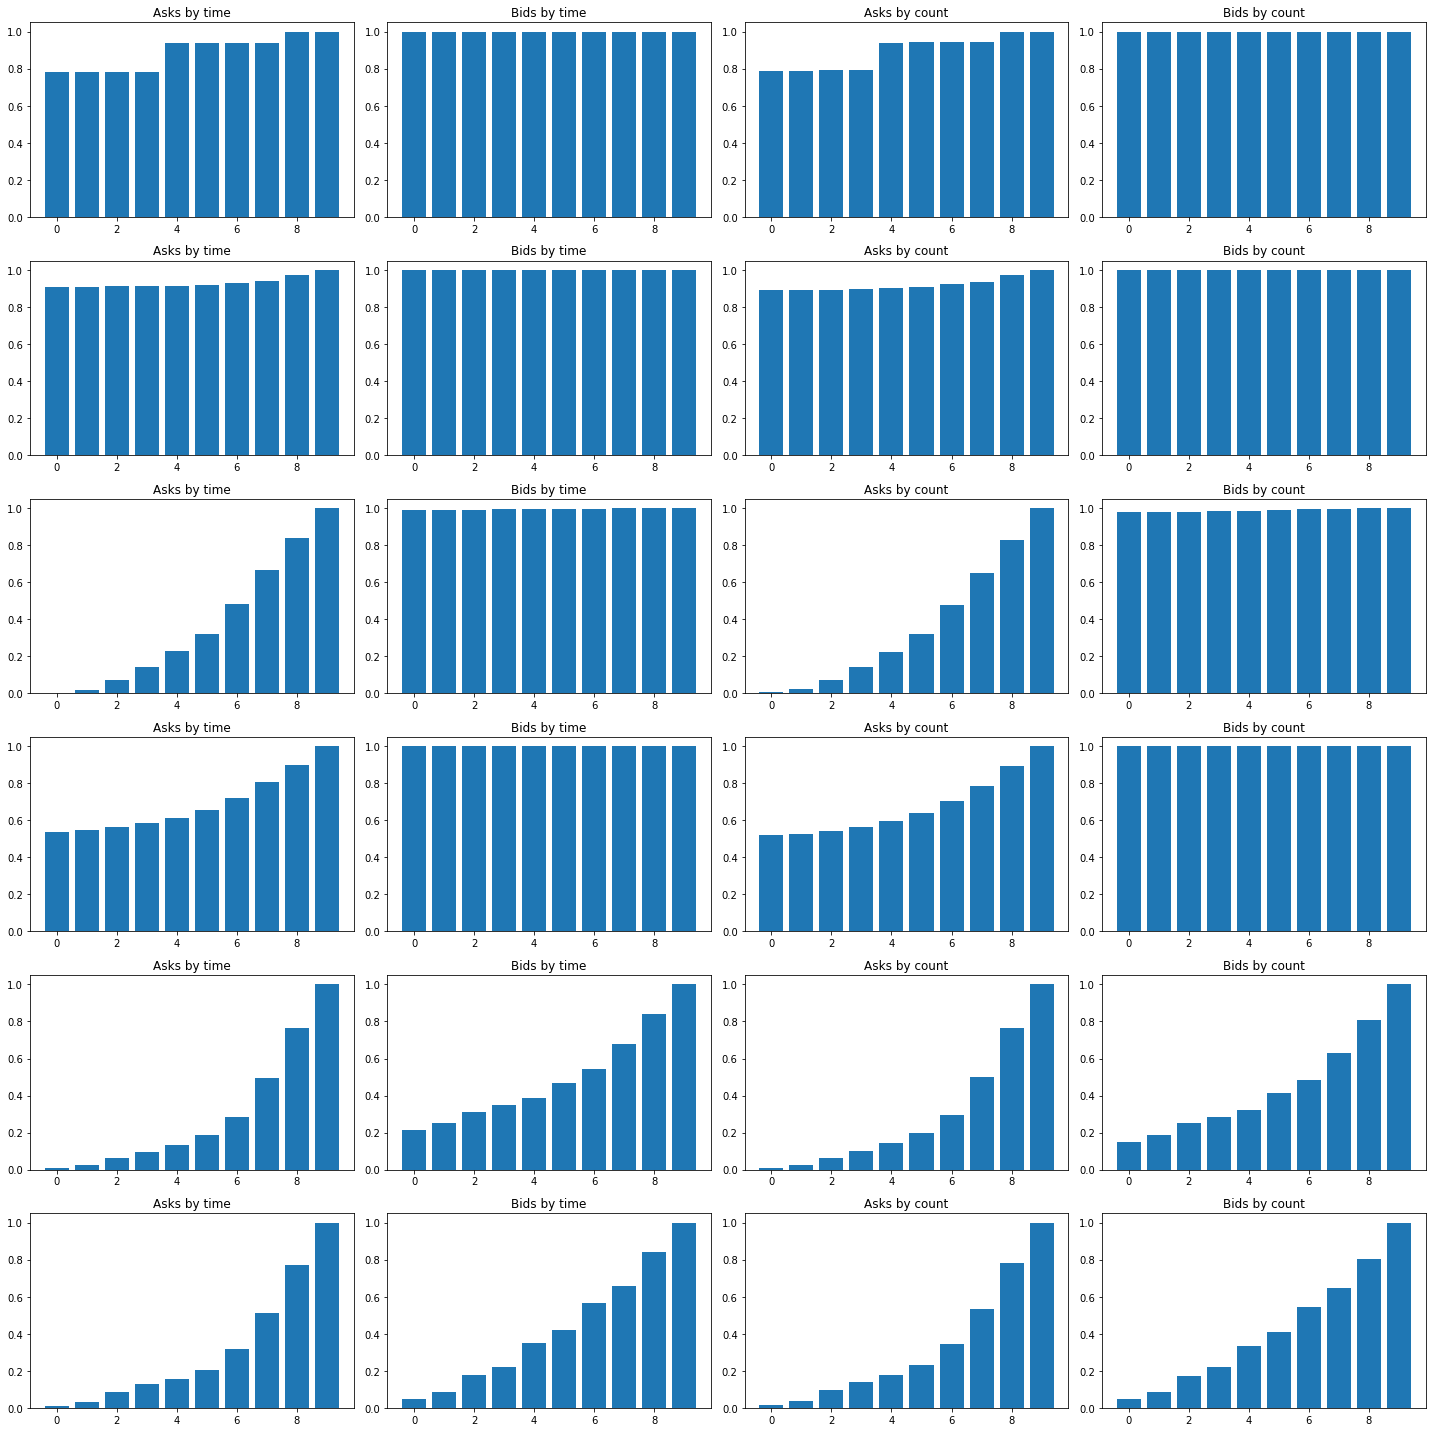

In [6]:
k = 1
plt.figure(figsize=(20,20))

for i in instruments:
    print('INSTRUMENT ' + i)
    filename = "spectrum/" + i + "_spectrum_day1.txt"
    avg_bids, avg_asks = norm_by_count(filename)
    weighted_avg_bids, weighted_avg_asks = weighted_norm(filename)

    kstest1 = kstest(avg_bids, avg_asks)
    kstest2 = kstest(weighted_avg_bids, weighted_avg_asks)
    kstest3 = kstest(avg_bids, weighted_avg_bids)
    kstest4 = kstest(avg_asks, weighted_avg_asks)

    if kstest1.pvalue < 0.025:
        print(f'For average by count bids and asks distributions are different, pval={kstest1.pvalue}')
    else:
        print(f'For average by count bids and asks distributions are the same, pval={kstest1.pvalue}')
        
    if kstest2.pvalue < 0.025:
        print(f'For average by time bids and asks distributions are different, pval={kstest2.pvalue}')
    else:
        print(f'For average by time bids and asks distributions are the same, pval={kstest2.pvalue}')
        
    if kstest3.pvalue < 0.025:
        print(f'For bids average by count and by time distributions are different, pval={kstest3.pvalue}')
    else:
        print(f'For bids average by count and by time distributions are the same, pval={kstest3.pvalue}')
        
    if kstest4.pvalue < 0.025:
        print(f'For asks average by count and by time distributions are different, pval={kstest4.pvalue}')
    else:
        print(f'For asks average by count and by time distributions are the same, pval={kstest4.pvalue}') 
        
    plt.subplot(6, 4, k)
    plt.bar(np.arange(10), weighted_avg_asks)
    plt.title('Asks by time')
    plt.subplot(6, 4, k+1)
    plt.bar(np.arange(10), weighted_avg_bids)
    plt.title('Bids by time')
    
    plt.subplot(6, 4, k+2)
    plt.bar(np.arange(10), avg_asks)
    plt.title('Asks by count')
    plt.subplot(6, 4, k+3)
    plt.bar(np.arange(10), avg_bids)
    plt.title('Bids by count')
    
    k += 4
    
        
    print('---------------------------------')
    
plt.tight_layout()

# KS-Test for all days

In [96]:
tom_instruments = ['EURUSD000TOM', 'EUR_RUB__TOM', 'USD000UTSTOM']

In [101]:
def another_norm_by_count(filename):
    sp = pd.read_csv(filename, header=None).to_numpy()
    max_time = np.max(sp[:, 0])
    
    if max_time > 150000000000:
        first = np.argwhere(sp[:, 0] > 150000000000)[0][0]
    else:
        results = np.array([np.mean(sp[:, 1:], axis=0), np.zeros(10), np.zeros(10)])
    if max_time > 190000000000:
        second = np.argwhere(sp[:, 0] > 190000000000)[0][0]
        results = np.array([np.mean(sp[:first, 1:], axis=0), np.mean(sp[first:second, 1:], axis=0), np.mean(sp[second:, 1:], axis=0)])
    else:
        results = np.array([np.mean(sp[:first, 1:], axis=0), np.mean(sp[first:, 1:], axis=0), np.zeros(10), np.zeros(10)])
        
    return np.cumsum(results[:, 0:10], axis=1), np.cumsum(results[:, 10:20], axis=1)
    
    
def another_weighted_norm(filename):
    start_time = np.array([100000000000])
    sp = pd.read_csv(filename, header=None)
    sp_np = sp.to_numpy()
    max_time = np.max(sp[0].to_numpy())
    total_time = sp[0].max() - 100000000000
    weights = np.diff(np.concatenate((start_time, sp[0].to_numpy())))
    results = np.array([np.zeros(20), np.zeros(20), np.zeros(20)])
    
    if max_time > 150000000000:
        first = np.argwhere(sp_np[:, 0] > 150000000000)[0][0]
    else:
        for index in range(1, 21):
            results[0, index - 1] = np.average(sp[index].to_numpy(), weights=weights)
    if max_time > 190000000000:
        second = np.argwhere(sp_np[:, 0] > 190000000000)[0][0]
        for index in range(1, 21):
            results[0, index - 1] = np.average(sp[index].to_numpy()[:first], weights=weights[:first])
            results[1, index - 1] = np.average(sp[index].to_numpy()[first:second], weights=weights[first:second])
            results[2, index - 1] = np.average(sp[index].to_numpy()[second:], weights=weights[second:])
    else:
        for index in range(1, 21):
            results[0, index - 1] = np.average(sp[index].to_numpy()[:first], weights=weights[:first])
            results[1, index - 1] = np.average(sp[index].to_numpy()[first:], weights=weights[first:])
    
    return np.cumsum(results[:, 0:10], axis=1), np.cumsum(results[:, 10:20], axis=1)

## Output 1: bids and asks for different times

In [108]:
pairs = [[0, 1], [1, 2], [0, 2]]
for i in tqdm(tom_instruments):
    f = open('task4_output1_' + i + '.txt', 'w+')
    f.write('10vs15; 15vs19; 10vs19\n')
    for j in tqdm(range(1, 65)):
        to_write = ''
        filename = "spectrum/" + i + "_spectrum_day" + str(j) + ".txt"
        avg_bids, avg_asks = another_norm_by_count(filename)
        for pair in pairs:
            kstest1 = kstest(avg_bids[pair[0]], avg_bids[pair[1]])
            kstest2 = kstest(avg_asks[pair[0]], avg_asks[pair[1]])
            if kstest1.pvalue < 0.025:
                to_write = to_write + 'false, '
            else:
                to_write = to_write + 'true, '
            if kstest2.pvalue < 0.025:
                to_write = to_write + 'false'
            else:
                to_write = to_write + 'true'
            to_write = to_write + '; '
        f.write(to_write[:-2] + '\n')

 95%|█████████████████████████████████████████████████████████████████████████████████▉    | 61/64 [03:30<00:08,  2.85s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [08:46<00:00, 175.35s/it]


## Output2: bids and asks for previous day

In [109]:
for i in tqdm(tom_instruments):
    f = open('task4_output2_' + i + '.txt', 'w+')
    f.write('10vs15; 15vs19; 10vs19\n')
    f.write('-; -; -\n')
    avg_bids_prev, avg_asks_prev = another_norm_by_count("spectrum/" + i + "_spectrum_day1.txt")
    for j in tqdm(range(2, 65)):
        to_write = ''
        filename = "spectrum/" + i + "_spectrum_day" + str(j) + ".txt"
        avg_bids, avg_asks = another_norm_by_count(filename)
        for k in range(3):
            kstest1 = kstest(avg_bids_prev[k], avg_bids[k])
            kstest2 = kstest(avg_asks_prev[k], avg_asks[k])
            if kstest1.pvalue < 0.025:
                to_write = to_write + 'false, '
            else:
                to_write = to_write + 'true, '
            if kstest2.pvalue < 0.025:
                to_write = to_write + 'false'
            else:
                to_write = to_write + 'true'
            to_write = to_write + '; '
        avg_bids_prev = avg_bids
        avg_asks_prev = avg_asks
        f.write(to_write[:-2] + '\n')

 98%|████████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [03:35<00:03,  3.10s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [08:39<00:00, 173.33s/it]
